# Project Milestone Two: Modeling and Feature Engineering

### Due: Midnight on April 13 (with 2-hour grace period) and worth 25 points

### Overview

This milestone builds on your work from Milestone 1. You will:

1. Evaluate baseline models using default settings.
2. Engineer new features and re-evaluate models.
3. Use feature selection techniques to find promising subsets.
4. Select the top 3 models and fine-tune them for optimal performance.

You must do all work in this notebook and upload to your team leader's account in Gradescope. There is no
Individual Assessment for this Milestone. 


In [47]:
# ===================================
# Useful Imports: Add more as needed
# ===================================

# Standard Libraries
import os
import time
import math
import io
import zipfile
import requests
from urllib.parse import urlparse
from itertools import chain, combinations

# Data Science Libraries
import numpy as np
import pandas as pd
import seaborn as sns

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as mticker  # Optional: Format y-axis labels as dollars
import seaborn as sns
import matplotlib.pyplot as plt



# Scikit-learn (Machine Learning)
from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    GridSearchCV, 
    RandomizedSearchCV, 
    RepeatedKFold
)
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector, f_regression, SelectKBest
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_predict, KFold
# Progress Tracking

from tqdm import tqdm

# =============================
# Global Variables
# =============================
random_state = 42
combined_results = pd.DataFrame()
# =============================
# Utility Functions
# =============================

# Format y-axis labels as dollars with commas (optional)
def dollar_format(x, pos):
    return f'${x:,.2f}'

# Convert seconds to HH:MM:SS format
def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))


# Format Time for GridSearchCV
def format_time(seconds):
    
    # Convert seconds to hours, minutes, and remaining seconds
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    remaining_seconds = seconds % 60
    
    # Return a formatted string    
    if hours == 0 and minutes == 0:
        return f"{seconds:.4f}s"
    elif hours == 0:
        return f"{minutes}m {remaining_seconds:.2f}s"

    return f"{hours}h {minutes}m {remaining_seconds:.2f}s"




___

In [48]:
# ========================================================================================
# This is meant to consolidate the 'show_null_counts_features' function from before with 
# another with 'value' and 'unique' counts later on in this analysis. 
# ========================================================================================

def profile_dataset(df):
    # Identify feature types
    feature_types = df.dtypes.apply(lambda x: 'Numeric' if np.issubdtype(x, np.number) else 'Categorical')

    # Build a summary DataFrame
    summary = pd.DataFrame({
        'Feature': df.columns,
        'Type': feature_types.values,
        'Null Values': df.isnull().sum().values,
        'Null %': (df.isnull().mean() * 100).round(2).values,
        'Count (Non-Null)': df.count().values,
        'Unique Values': df.nunique().values
    })

    # Sort Values in Summary by % of null values
    summary = summary.sort_values(by='Null %', ascending=False).reset_index(drop=True)

    # Add dataset shape info above the table
    print(f"This dataset contain {df.shape[0]} rows")
    print(f"This dataset contain {df.shape[1]} columns")

    # Display the summary
    return summary

In [49]:
def drop_features(dataframe, columns_to_drop):
    initial_columns = dataframe.shape[1]
    # Drop each column gradually, using try-except to avoid errors if the column is missing
    for col in columns_to_drop:
        try:
            dataframe = dataframe.drop(columns=[col])
            print(f"Dropped column: {col}")
        except KeyError:
            print(f"Column {col} not found. Skipping.")
    final_columns = dataframe.shape[1]
    print(f"Number of columns to be dropped: {len(columns_to_drop)}")
    print(f"Number of columns before dropping: {initial_columns}")
    print(f"Number of columns after dropping: {final_columns}")
    return dataframe

def plot_rmse_bars_by_run_comment(df, run_comment_filter):
    # Filter the dataset
    filtered = df[df['run_comment'].str.contains(run_comment_filter, na=False)].copy()
    filtered = filtered.sort_values(by='mean_CV_RMSE', ascending=True)

    if filtered.empty:
        print(f"No rows found with run_comment containing '{run_comment_filter}'.")
        return

    # Melt the data for grouped barplot
    melted = filtered.melt(
        id_vars='model',
        value_vars=['mean_CV_RMSE', 'std_CV_RMSE', 'training_RMSE'],
        var_name='Metric',
        value_name='RMSE'
    )

    # Set up the plot style
    custom_params = {"axes.spines.right": False, "axes.spines.top": False}
    sns.set_theme(style="ticks", rc=custom_params)

    plt.figure(figsize=(12, 6))
    barplot = sns.barplot(
        data=melted,
        x='model',
        y='RMSE',
        hue='Metric'
    )

    # Add value labels above each bar
    for container in barplot.containers:
        barplot.bar_label(container, fmt='%.3f', label_type='edge', padding=2)

    # Format y-axis if desired (e.g., dollar formatting)
    # Uncomment below if working with actual dollar values
    # barplot.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"${x:,.0f}"))

    # Final touches
    plt.title(f"Model RMSE Comparison - Filter: {run_comment_filter}", fontsize=14, fontweight='bold')
    plt.ylabel("RMSE")
    plt.xlabel("Model")
    plt.xticks(rotation=45)
    plt.legend(title='Metric')
    plt.tight_layout()
    plt.show()

from matplotlib.ticker import FuncFormatter #to be moved to imports
def plot_predictions(y_true, y_pred, title="Model Performance", limit_outliers=True, figsize=(12, 4)):

    # Convert to Series if needed
    y_true = pd.Series(y_true).reset_index(drop=True)
    y_pred = pd.Series(y_pred).reset_index(drop=True)

    # Optionally remove outliers (top 1% actual)
    if limit_outliers:
        threshold = y_true.quantile(0.99)
        mask = y_true < threshold
        y_true = y_true[mask]
        y_pred = y_pred[mask]

    # Calculate residuals
    residuals = y_true - y_pred
    abs_errors = np.abs(residuals)

    # Set up figure
    fig, axes = plt.subplots(1, 2, figsize=figsize)

    # --- Plot 1: Predicted vs Actual ---
    sns.scatterplot(x=y_true, y=y_pred, ax=axes[0], s=30, alpha=0.5, edgecolor=None)
    max_val = max(y_true.max(), y_pred.max())
    min_val = min(y_true.min(), y_pred.min())
    axes[0].plot([min_val, max_val], [min_val, max_val], 'r--')
    axes[0].set_title("Predicted vs. Actual Values")
    axes[0].set_xlabel("Actual Values")
    axes[0].set_ylabel("Predicted Values")

    # Dollar formatting
    dollar_fmt = FuncFormatter(lambda x, _: f"${x/1e6:.1f}M")
    axes[0].xaxis.set_major_formatter(dollar_fmt)
    axes[0].yaxis.set_major_formatter(dollar_fmt)

    # --- Plot 2: Residuals by Actual Values ---
    scatter = sns.scatterplot(
        x=y_true,
        y=y_pred,
        hue=abs_errors,
        palette="coolwarm",
        ax=axes[1],
        s=30,
        alpha=0.6,
        edgecolor=None
    )
    axes[1].set_title("Residuals Colored by Absolute Error")
    axes[1].set_xlabel("Actual Values")
    axes[1].set_ylabel("Predicted Values")
    axes[1].xaxis.set_major_formatter(dollar_fmt)
    axes[1].yaxis.set_major_formatter(dollar_fmt)

    # Clean up color legend
    scatter.legend(title="Absolute Error", loc='upper left', bbox_to_anchor=(1.02, 1))

    plt.suptitle(title, fontsize=14)
    plt.tight_layout(rect=[0, 0, 0.95, 0.95])
    plt.show()



In [50]:
from matplotlib.ticker import FuncFormatter

def plot_predictions(
    y_train_true=None, y_train_pred=None,
    y_test_true=None, y_test_pred=None,
    title="Model Performance",
    limit_outliers=True,
    figsize=(10, 5)
):
    plots = []

    # Helper: Clean and trim outliers
    def prepare_data(y_true, y_pred):
        y_true = pd.Series(y_true).reset_index(drop=True)
        y_pred = pd.Series(y_pred).reset_index(drop=True)
        if limit_outliers:
            threshold = y_true.quantile(0.99)
            mask = y_true < threshold
            y_true = y_true[mask]
            y_pred = y_pred[mask]
        abs_errors = np.abs(y_true - y_pred)
        return y_true, y_pred, abs_errors

    # Dollar formatter
    dollar_fmt = FuncFormatter(lambda x, _: f"${x/1e6:.1f}M")

    # Collect valid plots
    if y_train_true is not None and y_train_pred is not None:
        ytt, ytp, ae = prepare_data(y_train_true, y_train_pred)
        plots.append(("Train", ytt, ytp, ae))

    if y_test_true is not None and y_test_pred is not None:
        ytt, ytp, ae = prepare_data(y_test_true, y_test_pred)
        plots.append(("Test", ytt, ytp, ae))

    if not plots:
        print("⚠️ No valid prediction data provided for plotting.")
        return

    # Adjust size for single plot
    if len(plots) == 1:
        figsize = (figsize[0] // 2, figsize[1])

    # Create subplots
    fig, axes = plt.subplots(1, len(plots), figsize=figsize)
    if len(plots) == 1:
        axes = [axes]

    # Plot each subplot
    for i, (ax, (label, y_true, y_pred, abs_errors)) in enumerate(zip(axes, plots)):
        scatter = sns.scatterplot(
            x=y_true,
            y=y_pred,
            hue=abs_errors,
            palette="coolwarm",
            ax=ax,
            s=30,
            alpha=0.6,
            edgecolor=None
        )
        ax.plot(
            [y_true.min(), y_true.max()],
            [y_true.min(), y_true.max()],
            'r--'
        )
        ax.set_title(f"{label} Predictions")
        ax.set_xlabel("Actual Values")
        ax.set_ylabel("Predicted Values")
        ax.xaxis.set_major_formatter(dollar_fmt)
        ax.yaxis.set_major_formatter(dollar_fmt)

        # Show legend only for last subplot if multiple
        if len(plots) == 1 or i == len(plots) - 1:
            ax.legend(
                title="Absolute Error",
                loc='upper center',
                bbox_to_anchor=(0.5, -0.25),
                ncol=3,
                frameon=False
            )
        else:
            ax.get_legend().remove()

    plt.suptitle(title, fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


In [51]:
def plot_rmse_comparison(df, run_comment_keyword="Base Model Parameters", title="Training vs CV RMSE (Stacked)", figsize=(12, 6)): 
    # Filter and sort by mean CV RMSE
    filtered_df = df[df['run_comment'].str.contains(run_comment_keyword, case=False, na=False)]
    filtered_df = filtered_df.sort_values(by='mean_CV_RMSE', ascending=True)

    if filtered_df.empty:
        print(f"No data found with run_comment containing '{run_comment_keyword}'")
        return

    # Determine which RMSE columns exist
    rmse_columns = ['training_RMSE', 'mean_CV_RMSE']
    if 'test_RMSE' in filtered_df.columns and filtered_df['test_RMSE'].notna().any():
        rmse_columns.append('test_RMSE')

    # Melt into long form for seaborn
    stacked_df = filtered_df[['model'] + rmse_columns].melt(
        id_vars='model',
        var_name='RMSE_Type',
        value_name='RMSE_Value'
    )

    # Plot setup
    custom_params = {"axes.spines.right": False, "axes.spines.top": False}
    sns.set_theme(style="ticks", rc=custom_params)
    plt.figure(figsize=figsize)

    # Bar plot
    barplot = sns.barplot(
        data=stacked_df,
        x='model',
        y='RMSE_Value',
        hue='RMSE_Type'
    )

    # Add labels to bars
    for bar in barplot.patches:
        height = bar.get_height()
        if not pd.isna(height):
            x = bar.get_x() + bar.get_width() / 2
            label = f"${height:,.0f}"
            barplot.text(x, height + 3000, label, ha='center', va='bottom', fontsize=8)

    # Format y-axis
    barplot.yaxis.set_major_formatter(mticker.FuncFormatter(dollar_format))

    # Final layout
    plt.title(f"{title}: {run_comment_keyword}", fontsize=14, fontweight='bold')
    plt.ylabel("RMSE", fontsize=12)
    plt.xlabel("Model", fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(title="")
    plt.tight_layout()
    plt.show()


Df loaded from Milestone 1: 
- Kept all the changes except  the outlier analysis?   
  - Sergey: Yes, let's keep all the changes (duplicates, missing, outliers), including cleansing of most of the outliers, I already re-ran it just for the target variable with wider limits and saved as `df_milestone_1.csv`

___

### Prelude: Load your Preprocessed Dataset from Milestone 1

In Milestone 1, you handled missing values, encoded categorical features, and explored your data. Before you begin this milestone, you’ll need to load that cleaned dataset and prepare it for modeling.

Here’s what to do:

1. Return to your Milestone 1 notebook and rerun your code through Part 3, where your dataset was fully cleaned (assume it’s called `df_cleaned`).

2. **Save** the cleaned dataset to a file by running:

>   df_cleaned.to_csv("zillow_cleaned.csv", index=False)

3. Switch to this notebook and **load** the saved data:

>   df = pd.read_csv("zillow_cleaned.csv")

4. Create a **train/test split** using `train_test_split`.  
   
6. **Standardize** the features (but not the target!) using **only the training data.** This ensures consistency across models without introducing data leakage from the test set:

>   scaler = StandardScaler()   
>   X_train_scaled = scaler.fit_transform(X_train)    
  
**Notes:** 

- You will not use the testing set during this milestone — it’s reserved for final evaluation later.
- You will have to redo the scaling step when you introduce new features (which have to be scaled as well).


____

#### **Prelude 3: Import DataFrame from Milestone 1**

TODO: I remembered that we wanted to take some of the changes from Milestone one but not all of them here. I vaguely remembered that we wanted to take back some of the feature changes (and I think I remember talk of undoing some of the outlier changes?) but I couldn't remember -- so I just imported a 'tentative_cleaned_df' here, and built functions out of the train test split and standardization. We can just re-run all of these preliminary steps on the proper df when ready.

In [73]:
# Add as many code cells as you need

# baseline_df = pd.read_csv('baseline_df.csv')
baseline_df = pd.read_csv('/Users/leemcfarling/Desktop/baseline_df.csv')
milestone_1_df = baseline_df
# solved. to be removed: milestone_1_df.drop(columns=['lotsizesquarefeet', 'finishedsquarefeet12'], axis=1, inplace=True) # todo: why? we need to explain it  -- LM  -- I put this in for the 'tentative_df' to get run_model_suite to run (null values in these fields were causing bugs). Figured it wouldn't be needed on the final Df imported
# solved. to be removed: milestone_1_df.dropna(inplace=True) #todo: why? data should be cleaned at this point -- LM  -- I put this in for the 'tentative_df' to get run_model_suite to run (null values in these fields were causing bugs) Figured it wouldn't be needed on the final Df imported
# solved. to be removed: milestone_1_df.drop(columns=['land_use_label'], axis=1, inplace=True) 

# Part 1: Baseline Model:
#  Excluded to get the baseline model without the feature engineering

# result_of_feature_engineering_during_eda = ['propertyage', 'yearbuilt_decade','fireplaceflag_new','storageshed_flag','hashottuborspa_flag','haspool_flag','hasairconditioning_flag','hasgarage_flag','hasbasement_flag','yard_building_flag']
# baseline_df = drop_features(milestone_1_df, result_of_feature_engineering_during_eda).copy()

In [53]:
profile_dataset(baseline_df)

This dataset contain 56269 rows
This dataset contain 45 columns


Feature     Type  Null Values  \
0                                         Unnamed: 0  Numeric            0   
1     heating_label_heating_or_system_type_baseboard  Numeric            0   
2    heating_label_heating_or_system_type_floor_wall  Numeric            0   
3    heating_label_heating_or_system_type_forced_air  Numeric            0   
4       heating_label_heating_or_system_type_gravity  Numeric            0   
5          heating_label_heating_or_system_type_none  Numeric            0   
6       heating_label_heating_or_system_type_radiant  Numeric            0   
7         heating_label_heating_or_system_type_solar  Numeric            0   
8       heating_label_heating_or_system_type_unknown  Numeric            0   
9           heating_label_heating_or_system_type_yes  Numeric            0   
10         building_label_building_quality_type_id_1  Numeric            0   
11        building_label_building_quality_type_id_10  Numeric            0   
12        building_label_building_quality_type_id_11  Numeric            0   
13        building_label_building_quality_type_id_12  Numeric            0   
14         building_label_building_quality_type_id_2  Numeric            0   
15         building_label_building_quality_type_id_3  Numeric            0   
16         building_label_building_quality_type_id_4  Numeric            0   
17         building_label_building_quality_type_id_5  Numeric            0   
18         building_label_building_quality_type_id_6  Numeric            0   
19         building_label_building_quality_type_id_7  Numeric            0   
20         building_label_building_quality_type_id_8  Numeric            0   
21      heating_label_heating_or_system_type_central  Numeric            0   
22                                   landuse_Triplex  Numeric            0   
23                                       bathroomcnt  Numeric            0   
24                                 landuse_Townhouse  Numeric            0   
25                                        bedroomcnt  Numeric            0   
26                      calculatedfinishedsquarefeet  Numeric            0   
27                                       fullbathcnt  Numeric            0   
28                                 lotsizesquarefeet  Numeric            0   
29                                           roomcnt  Numeric            0   
30                                           unitcnt  Numeric            0   
31                                 taxvaluedollarcnt  Numeric            0   
32                         county_name_Orange County  Numeric            0   
33                        county_name_Ventura County  Numeric            0   
34  landuse_Commercial_Office_Residential_Mixed_Used  Numeric            0   
35                               landuse_Condominium  Numeric            0   
36                               landuse_Cooperative  Numeric            0   
37                                    landuse_Duplex  Numeric            0   
38  landuse_Manufactured_Modular_Prefabricated_Homes  Numeric            0   
39                               landuse_Mobile_Home  Numeric            0   
40                  landuse_Planned_Unit_Development  Numeric            0   
41                                landuse_Quadruplex  Numeric            0   
42                       landuse_Residential_General  Numeric            0   
43                 landuse_Single_Family_Residential  Numeric            0   
44         building_label_building_quality_type_id_9  Numeric            0   

    Null %  Count (Non-Null)  Unique Values  
0      0.0             56269          56269  
1      0.0             56269              2  
2      0.0             56269              2  
3      0.0             56269              2  
4      0.0             56269              2  
5      0.0             56269              2  
6      0.0             56269              2  
7      0.0             56269              2  
8      0.0             56269              

#### **Prelude 4: Split into Features and Target Variables -- then Train / Test Split the Data**

Function to Train / Test split the data -- input is a df and the target column

In [54]:
def train_test_split_data(df, target_col):
    X = df.drop(columns=target_col)
    y = df[target_col]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    return X_train, X_test, y_train, y_test 

In [55]:
tentative_X_train, tentative_X_test, tentative_y_train, tentative_y_test = train_test_split_data(baseline_df, 'taxvaluedollarcnt')

#### **Prelude 5: Standardize the Training Features**

In [56]:
# ===================================================
# Standardize Numeric Features

# This uses the global df_clean_numeric found 
# earlier which filters out 'id' and 'flag' variables
# ===================================================

def standardize_features(df, target_column=None, debug=False, return_scaler=False):
    df_scaled = df.copy()
    numeric_cols = df.select_dtypes(include=['number']).columns.tolist()

    """ removed hardcoded filter
    numeric_cols1 = [col for col in numeric_cols 
                     if 'landuse' not in col.lower() and 
                        'flag' not in col.lower() and 
                        'id' not in col.lower() and
                        'county_name' not in col.lower()]
    """

    if target_column in numeric_cols:
        numeric_cols.remove(target_column)

    # Step 4: Further exclude binary (0/1) columns
    numeric_cols_to_scale = [
        col for col in numeric_cols
        if df[col].nunique(dropna=True) > 2
    ]

    # DEBUG
    if debug:    
        print("Numeric columns before filtering:", numeric_cols)
        print("Numeric columns after filtering:", numeric_cols_to_scale)    

    scaler = StandardScaler()
    df_scaled[numeric_cols_to_scale] = scaler.fit_transform(df_scaled[numeric_cols_to_scale])
    
    if return_scaler:
        return df_scaled, scaler
    
    return df_scaled


In [57]:
def standardize_features_train_and_test(X_train, X_test=None, target_column=None, debug=False, return_scaler=False):
    """
    Standardize numerical features in either a single DataFrame or in X_train/X_test split.

    Parameters:
    - X_train: DataFrame to scale (or the only one, for legacy use)
    - X_test: Optional second DataFrame (for train/test split)
    - target_column: Column to exclude from scaling
    - debug: Print details
    - return_scaler: Whether to return the fitted scaler

    Returns:
    - Scaled X_train (or single df), optional X_test, optional scaler
    """
    legacy_mode = X_test is None  # True if using legacy single-DF mode

    # In legacy mode, treat input as single DataFrame
    if legacy_mode:
        df_scaled = X_train.copy()
        numeric_cols = df_scaled.select_dtypes(include='number').columns.tolist()

        if target_column in numeric_cols:
            numeric_cols.remove(target_column)

        numeric_cols_to_scale = [col for col in numeric_cols if df_scaled[col].nunique(dropna=True) > 2]

        if debug:
            print("Scaling columns:", numeric_cols_to_scale)

        scaler = StandardScaler()
        df_scaled[numeric_cols_to_scale] = scaler.fit_transform(df_scaled[numeric_cols_to_scale])

        if return_scaler:
            return df_scaled, None, scaler
        return df_scaled  # legacy-compatible

    # --- New version for X_train/X_test split ---
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy() if X_test is not None else None

    numeric_cols = X_train.select_dtypes(include='number').columns.tolist()
    if target_column and target_column in numeric_cols:
        numeric_cols.remove(target_column)

    numeric_cols_to_scale = [col for col in numeric_cols if X_train[col].nunique(dropna=True) > 2]

    if debug:
        print("Numeric columns to scale:", numeric_cols_to_scale)

    scaler = StandardScaler()
    X_train_scaled[numeric_cols_to_scale] = scaler.fit_transform(X_train[numeric_cols_to_scale])

    if X_test_scaled is not None:
        X_test_scaled = X_test_scaled[X_train_scaled.columns]
        X_test_scaled[numeric_cols_to_scale] = scaler.transform(X_test_scaled[numeric_cols_to_scale])

    if return_scaler and X_test is not None: 
        return X_train_scaled, X_test_scaled, scaler

    if X_test is not None: 
        return X_train_scaled, X_test_scaled, None

    # Always return 3 values (legacy call with just one dataset)
    if return_scaler:
        return X_train_scaled, None, scaler

    return X_train_scaled, None, None


In [58]:
scaled_tentative_x_train = standardize_features(tentative_X_train)
scaled_tentative_x_train

Unnamed: 0  bathroomcnt  bedroomcnt  calculatedfinishedsquarefeet  \
608     -1.695913    -0.300762   -0.262887                     -0.342547   
18299   -0.606792    -1.348453   -0.262887                      0.154474   
29503    0.082966     0.746930    1.656011                      0.851265   
45394    1.061273    -0.300762   -0.262887                     -0.816701   
38009    0.606626     0.746930    0.696562                      0.955964   
...           ...          ...         ...                           ...   
44732    1.020518     1.794621    0.696562                      1.674417   
54343    1.612205    -0.300762    0.696562                     -0.458077   
38158    0.615799     0.746930   -0.262887                      1.783930   
860     -1.680399    -0.300762   -0.262887                     -0.560369   
15795   -0.760947    -0.300762   -0.262887                     -0.182489   

       fullbathcnt  lotsizesquarefeet   roomcnt   unitcnt  \
608      -0.243868          -0.502296 -0.568957 -0.204371   
18299    -1.309771           0.120158 -0.568957 -0.204371   
29503     0.822035          -0.061805  2.440906 -0.204371   
45394    -0.243868          -0.574376 -0.568957 -0.204371   
38009     0.822035          -0.039380  0.099902 -0.204371   
...            ...                ...       ...       ...   
44732     1.887937           2.523477 -0.568957 -0.204371   
54343    -0.243868           0.117595 -0.568957 -0.204371   
38158     0.822035          -0.167523 -0.568957 -0.204371   
860      -0.243868          -0.246651 -0.568957 -0.204371   
15795    -0.243868           0.949883 -0.568957 -0.204371   

       county_name_Orange County  county_name_Ventura County  ...  \
608                            0                           0  ...   
18299                          0                           0  ...   
29503                          1                           0  ...   
45394                          0                           0  ...   
38009                          0                           1  ...   
...                          ...                         ...  ...   
44732                          0                           0  ...   
54343                          0                           0  ...   
38158                          1                           0  ...   
860                            0                           0  ...   
15795                          0                           0  ...   

       building_label_building_quality_type_id_11  \
608                                             0   
18299                                           0   
29503                                           0   
45394                                           0   
38009                                           0   
...                                           ...   
44732                                           0   
54343                                           0   
38158                                           0   
860                                             0   
15795                                           0   

       building_label_building_quality_type_id_12  \
608                                             0   
18299                                           0   
29503                                           0   
45394                                           0   
38009                                           0   
...                                           ...   
44732                                           0   
54343                                           0   
38158                                           0   
860                                             0   
15795                                           0   

       building_label_building_quality_type_id_2  \
608                                            0   
18299                                          0   
29503                                          0   
45394                                          0  

#### **Prelude 6: Various Helpers**

In [59]:
def create_indicator_from_columns(df, columns, new_column_name):
    # Initialize a boolean series with False for all rows.
    indicator = pd.Series(False, index=df.index)
    
    for col in columns:
        try:
            if col in df.columns:
                indicator = indicator | df[col].notnull()
            else:
                print(f"Warning: Column '{col}' not found. Skipping.")
        except Exception as e:
            print(f"Error processing column '{col}': {e}")
    
    # Assign the indicator as an integer column to the DataFrame
    df[new_column_name] = indicator.astype(int)
    return df


**Clear Global DataFrame**

(please be careful with this one once we get going)

In [60]:
# Clear Results from the Global DataFrame

#combined_results = combined_results.iloc[0:0] #fails here, because variable is empty or dont exist at this step 

**Expand and Contract DF Column Widths**

(Mostly to get a handle on all the parameters being passed in with each function)

In [61]:
# Expand Column Width to see all parameters
pd.set_option('display.max_colwidth', None)


# Set it back to Normal
# pd.reset_option('display.max_colwidth')

___

### Part 1: Baseline Modeling [3 pts]

Apply the following regression models to the scaled training dataset using **default parameters**:

- Linear Regression
- Ridge Regression
- Lasso Regression
- Decision Tree Regression
- Bagging
- Random Forest
- Gradient Boosting Trees

For each model:
- Use **repeated cross-validation** (e.g., 5 folds, 5 repeats).
- Report the **mean and standard deviation of CV RMSE Score** across all folds in a table. 


In [62]:
# Add as many code cells as you need

Baseline_Models = [
    
    LinearRegression(    # Defaults // LinearRegression (sklearn)
        fit_intercept=True,    # Top 2
        positive=False,        # Top 2
        ),

    Ridge(               # Defaults // Ridge (sklearn)
        alpha = 1.0,            # Top 3
        fit_intercept = True,   # Top 3
        solver = 'auto',        # Top 3

        max_iter = 1000,    # Will cause warnings unless higher ~10,000 (but default is 1000)
        tol = 0.001,
        random_state = 42,
        ),

    Lasso( # Defaults // Lasso (sklearn)
        alpha = 1.0,            # Top 2
        fit_intercept = True,   # Top 2
        max_iter = 1000,        # Will cause warnings unless higher ~10,000 (default is 1000 ). Causes warnings with 1000 and 5000 as well

        tol = 0.0001,
        warm_start = False,
        positive = False,
        random_state = 42, # for reproducability
    ),

    DecisionTreeRegressor( # Defaults // DecisionTreeRegressor (hw6)
        max_depth                = None,       # Top 4 
        min_samples_split        = 2,          # Top 4 
        max_features             = None,       # Top 4 
        max_leaf_nodes           = None,       # Top 4 

        criterion                = 'squared_error',  
        splitter                 = 'best',
        min_samples_leaf         = 1,
        min_weight_fraction_leaf = 0.0,
        min_impurity_decrease    = 0.0,
        ccp_alpha                = 0.0,
        random_state             = 42 # for reproducability     
        ),

    BaggingRegressor( # Defaults // Bagging Regressor (hw7)
        n_estimators=10,     # Top 4
        max_samples=1.0,     # Top 4
        max_features=1.0,    # Top 4
        bootstrap=True,      # Top 4

        # base_estimator=None,
        oob_score=False,
        bootstrap_features=False,
        random_state=42 # for reproducability   
        ),

    RandomForestRegressor( # Defaults // RandomForestRegresson (hw7)
        n_estimators=100,      # Top 4
        max_features=None,     # Top 4
        max_depth=None,        # Top 4
        bootstrap=True,        # Top 4

        min_samples_split=2,
        min_samples_leaf=1,
        oob_score=False,
        criterion='squared_error',
        random_state=42     #For reproducability
        ),

    GradientBoostingRegressor(   # Defaults // GradientBoostingRegressor  (hw7)
        learning_rate=0.1,     # Top 4 
        n_estimators= 100,     # Top 4
        max_depth=3,           # Top 4
        max_features=None,      # Top 4
        
        min_samples_split=2,
        min_samples_leaf=1,
        max_leaf_nodes=None,
        subsample=1.0,
        loss='squared_error',
        random_state= 42   # for reproducability
        ),
]

#### **Run Models Individually**

In [63]:
# New version with test data and scaling:
def run_model(
    model,
    X_train,
    y_train,
    X_test=None,
    y_test=None,
    n_repeats=5,
    n_jobs=-1,
    concat_results=False,
    run_comment=None,
    target_is_logged=False,
    plot_pred=False,
    return_scaler=False,
    **model_params
):
    global combined_results

    # Scale both training and test data
    X_train_scaled, X_test_scaled, scaler = standardize_features_train_and_test(
        X_train=X_train,
        X_test=X_test,
        target_column=None,
        return_scaler=True
    )

    model_instance = model(**model_params) if isinstance(model, type) else model
    model_name = model.__name__ if isinstance(model, type) else model.__class__.__name__

    # --- Cross-validation & training ---
    if target_is_logged:
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        rmse_scores = []

        for train_idx, val_idx in kf.split(X_train_scaled):
            X_tr = X_train_scaled.iloc[train_idx]
            X_val = X_train_scaled.iloc[val_idx]
            y_tr = y_train.iloc[train_idx]
            y_val = y_train.iloc[val_idx]

            model_instance.fit(X_tr, y_tr)
            preds_log = model_instance.predict(X_val)

            y_preds = np.expm1(preds_log)
            y_true = np.expm1(y_val)

            rmse_scores.append(root_mean_squared_error(y_true, y_preds))

        mean_CV_RMSE = np.mean(rmse_scores)
        std_CV_RMSE = np.std(rmse_scores)

        # Fit final model on full training set
        model_instance.fit(X_train_scaled, y_train)
        y_train_pred = np.expm1(model_instance.predict(X_train_scaled))
        y_train_true = np.expm1(y_train)
        training_RMSE = root_mean_squared_error(y_train_true, y_train_pred)

        # Evaluate test set
        test_RMSE = None
        if X_test_scaled is not None and y_test is not None:
            y_test_pred = np.expm1(model_instance.predict(X_test_scaled))
            y_test_true = np.expm1(y_test)
            test_RMSE = root_mean_squared_error(y_test_true, y_test_pred)

        # Ensure test prediction is safe for plotting
        if X_test_scaled is None or y_test is None:
            y_test_pred = None

        if plot_pred:
            plot_predictions(
                y_train_true=y_train_true,
                y_train_pred=y_train_pred,
                y_test_true=y_test_true,
                y_test_pred=y_test_pred,
                title=model_name + " Train vs Test"
            )

    else:
        # Not log-transformed
        neg_mse_scores = cross_val_score(
            model_instance,
            X_train_scaled,
            y_train,
            scoring='neg_mean_squared_error',
            cv=RepeatedKFold(n_splits=5, n_repeats=n_repeats, random_state=42),
            n_jobs=n_jobs
        )
        rmse_scores = np.sqrt(-neg_mse_scores)
        mean_CV_RMSE = np.mean(rmse_scores)
        std_CV_RMSE = np.std(rmse_scores)

        model_instance.fit(X_train_scaled, y_train)
        y_train_pred = model_instance.predict(X_train_scaled)
        training_RMSE = root_mean_squared_error(y_train, y_train_pred)

        test_RMSE = None
        if X_test_scaled is not None and y_test is not None:
            y_test_pred = model_instance.predict(X_test_scaled)
            test_RMSE = root_mean_squared_error(y_test, y_test_pred)

        # Ensure test prediction is safe for plotting
        if X_test_scaled is None or y_test is None:
            y_test_pred = None
            
        if plot_pred:
            plot_predictions(
                y_train_true=y_train,
                y_train_pred=y_train_pred,
                y_test_true=y_test,
                y_test_pred=y_test_pred,
                title=model_name + " Train vs Test"
            )

    # --- Collect results ---
    results_df = pd.DataFrame([{
        "model": model_name,
        "model_params": model_instance.get_params(),
        "mean_CV_RMSE": mean_CV_RMSE,
        "std_CV_RMSE": std_CV_RMSE,
        "training_RMSE": training_RMSE,
        "test_RMSE": test_RMSE,
        "run_comment": run_comment
    }])

    if concat_results:
        try:
            combined_results = pd.concat([combined_results, results_df], ignore_index=True)
        except NameError:
            combined_results = results_df

    return (results_df, scaler) if return_scaler else results_df


____

**Run Model Test on Linear Regression**

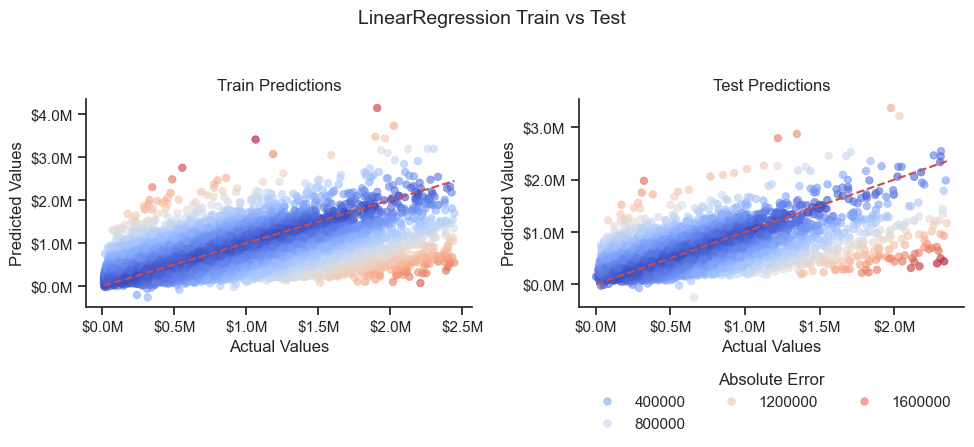

model  \
0  LinearRegression   

                                                                 model_params  \
0  {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}   

   mean_CV_RMSE   std_CV_RMSE  training_RMSE      test_RMSE run_comment  
0  421300.94834  38649.449192  421920.427131  370624.472357    Trial #1

In [64]:
run_model(
          model=LinearRegression,
          X_train=tentative_X_train,
          y_train=tentative_y_train, 
          X_test=tentative_X_test, 
          y_test=tentative_y_test,
          n_repeats=5,
          n_jobs=-1, 
          concat_results=False,
          run_comment="Trial #1", 
          target_is_logged=False,
          plot_pred=True
          )

#### **Run Models as a Group**

In [65]:
def run_model_suite(
    models,
    X_train,
    y_train,
    X_test=None,
    y_test=None,    
    n_repeats=5,
    n_jobs=-1,
    concat_results=False,
    run_comment=None,
    target_is_logged=False,
    plot_pred=False,
    **model_params
):
    global combined_results # should not be here, ok if it works
    total_start = time.time()
    
    all_results = []
    total_models = len(models)
    for  i, model in enumerate(models, 1):
        print(f"\n[{i}/{total_models}] Running model: {model}")
        model_start = time.time()
        
        result_df = run_model(
            model=model,
            X_train=X_train,
            y_train=y_train,
            X_test=X_test,
            y_test=y_test, 
            n_repeats=n_repeats,
            n_jobs=n_jobs,
            run_comment=run_comment,
            target_is_logged=target_is_logged,
            plot_pred=plot_pred,
            **model_params
        )
        model_end = time.time()
        model_duration = model_end - model_start
        print(f"[{i}/{total_models}] Model completed in {model_duration:.2f} seconds.")
        
        all_results.append(result_df)

    combined = pd.concat(all_results, ignore_index=True)

    total_end = time.time()
    total_duration = total_end - total_start
    print(f"\nAll models finished. Total time: {total_duration:.2f} seconds.")
    
    if concat_results:
        try:
            combined_results = pd.concat([combined_results, combined], ignore_index=True)
        except NameError:
            combined_results = combined  # first time
       
    return combined


[1/7] Running model: LinearRegression()


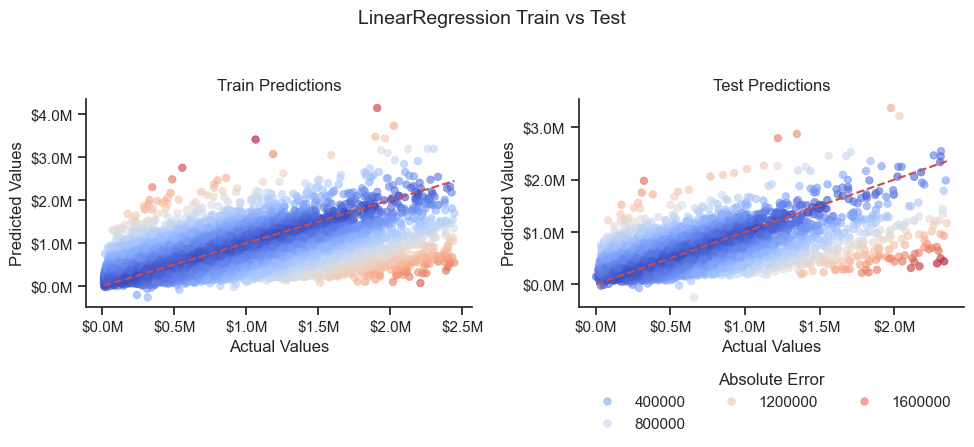

[1/7] Model completed in 2.45 seconds.

[2/7] Running model: Ridge(max_iter=1000, random_state=42, tol=0.001)


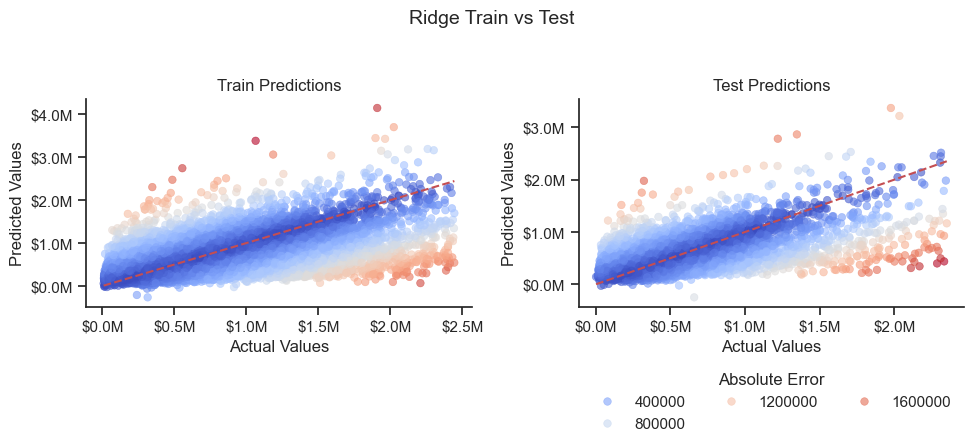

[2/7] Model completed in 1.04 seconds.

[3/7] Running model: Lasso(random_state=42)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.477e+14, tolerance: 1.036e+12
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.558e+14, tolerance: 1.031e+12
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

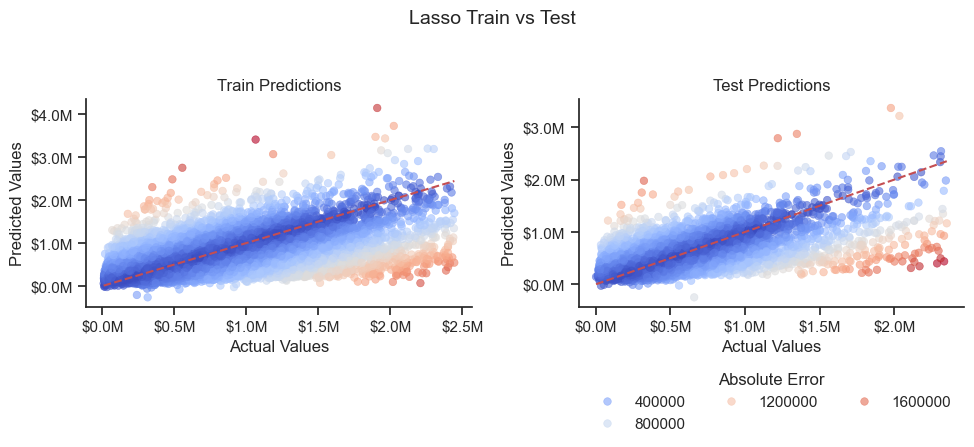

[3/7] Model completed in 6.23 seconds.

[4/7] Running model: DecisionTreeRegressor(random_state=42)


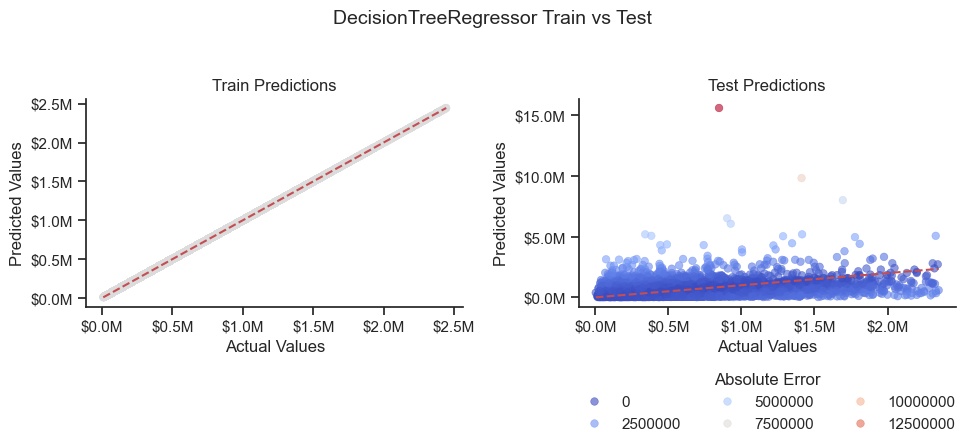

[4/7] Model completed in 2.62 seconds.

[5/7] Running model: BaggingRegressor(random_state=42)


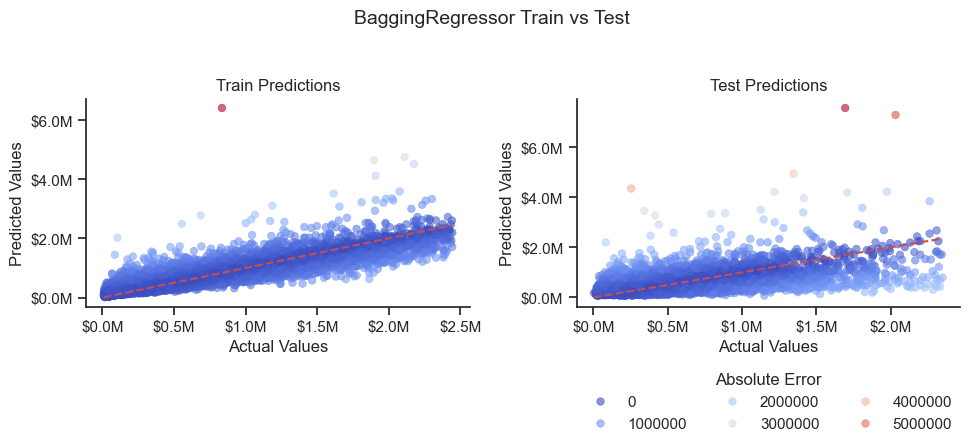

[5/7] Model completed in 12.65 seconds.

[6/7] Running model: RandomForestRegressor(max_features=None, random_state=42)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


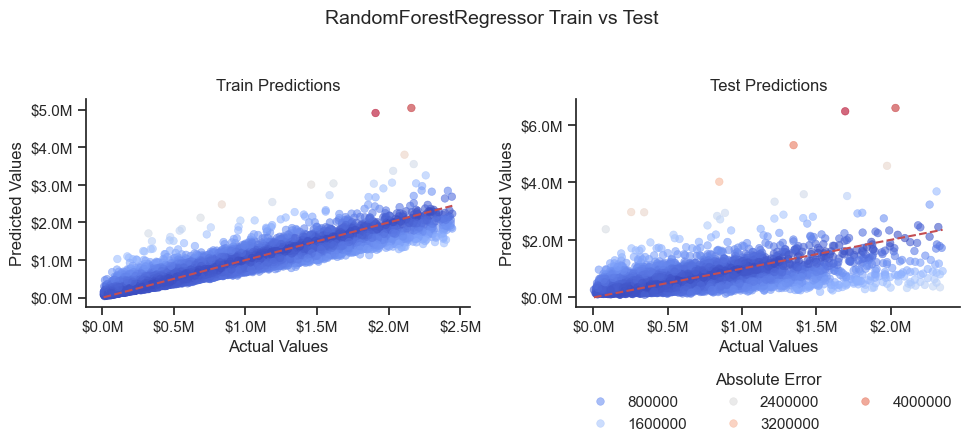

[6/7] Model completed in 116.71 seconds.

[7/7] Running model: GradientBoostingRegressor(random_state=42)


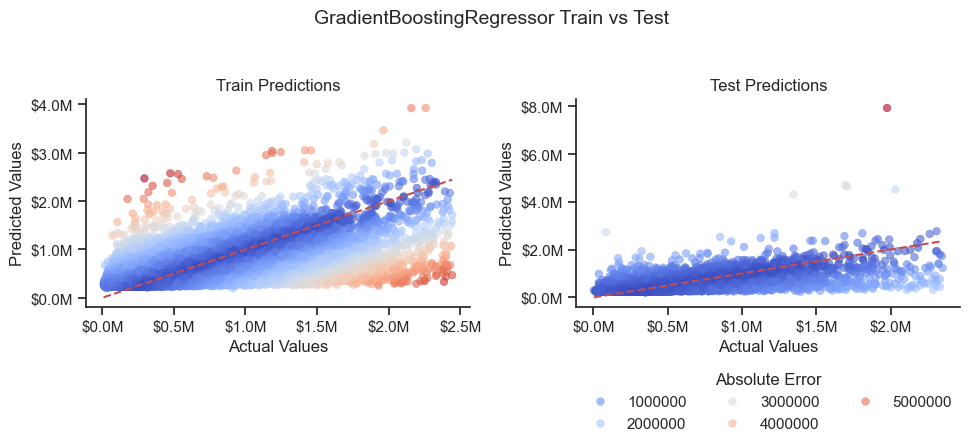

[7/7] Model completed in 29.68 seconds.

All models finished. Total time: 171.38 seconds.


model  \
0           LinearRegression   
1                      Ridge   
2                      Lasso   
3      DecisionTreeRegressor   
4           BaggingRegressor   
5      RandomForestRegressor   
6  GradientBoostingRegressor   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                model_params  \
0                                                                                                                                                                                                                                                                                                                                                                                                 {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}   
1                                                                                                                                                                                                                                                                                                                             {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'positive': False, 'random_state': 42, 'solver': 'auto', 'tol': 0.001}   
2                                                                                                                                                                                                                                                                             {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'positive': False, 'precompute': False, 'random_state': 42, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}   
3                                                                                                                                                                             {'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'}   
4                                                                                                                                                                                                                                                {'bootstrap': True, 'bootstrap_features': False, 'estimator': None, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 10, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}   
5                                                             {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}   
6  {'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': 42, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}   

    mean_CV_RMSE   std_CV_RMSE  training_RMSE      te

In [66]:
run_model_suite(
        Baseline_Models,
        X_train=tentative_X_train,
        y_train=tentative_y_train,
        X_test=tentative_X_test,
        y_test=tentative_y_test,  
        n_repeats=5,
        n_jobs=4,
        concat_results=True,
        run_comment='Base Model Parameters', 
        target_is_logged=False
        , plot_pred=True # comment out to avoid plots for each model's
)

**Note on Convergence Issues and other warnings**


At this stage, we are not addressing convergence or memory-related warnings, as we have not yet performed feature engineering or hyperparameter tuning to mitigate these issues. These early models are intended to establish baseline performance, and we anticipate improved stability in later stages of the pipeline. (And indeed, both of these issues were solved later on with feature and hyperparameter tuning.)



#### **Model RMSE Plots**

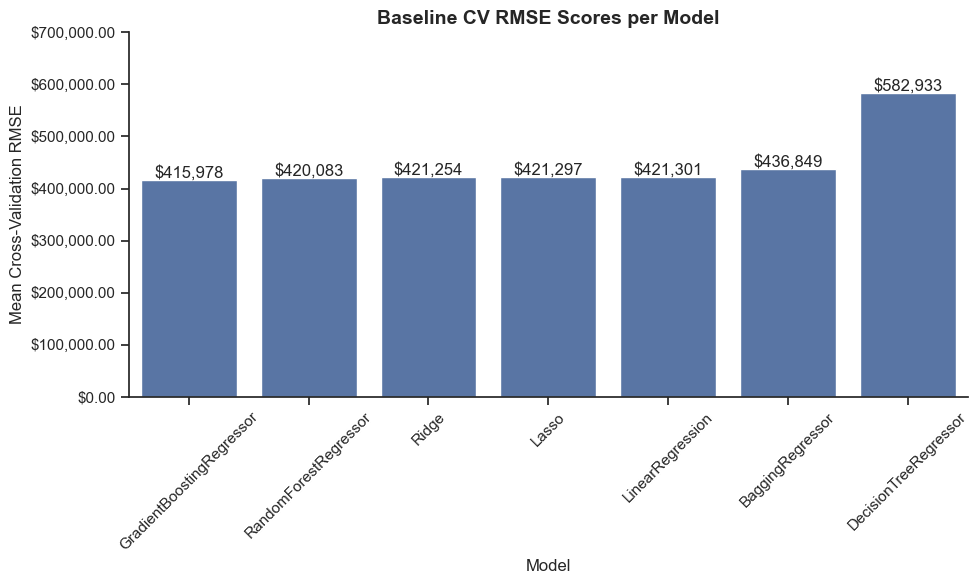

In [67]:
# Filter and sort results
part1_plotting = combined_results[combined_results['run_comment'].str.contains('Base Model Parameters')]
part1_plotting = part1_plotting.sort_values(by='mean_CV_RMSE', ascending=True)

# Plot setup
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
plt.figure(figsize=(10, 6))

# Create vertical barplot
barplot = sns.barplot(
    data=part1_plotting,
    x='model',
    y='mean_CV_RMSE'
    # palette='Blue'
)

# Add value labels above bars
for i, val in enumerate(part1_plotting['mean_CV_RMSE']):
    barplot.text(i, val + 5000, f"${val:,.0f}", ha='center')

# Format y-axis with dollar format
barplot.yaxis.set_major_formatter(mticker.FuncFormatter(dollar_format))

# Labels and title
plt.title("Baseline CV RMSE Scores per Model", fontsize=14, fontweight='bold')
plt.ylabel("Mean Cross-Validation RMSE", fontsize=12)
plt.xlabel("Model", fontsize=12)
plt.ylim(0, 700_000)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

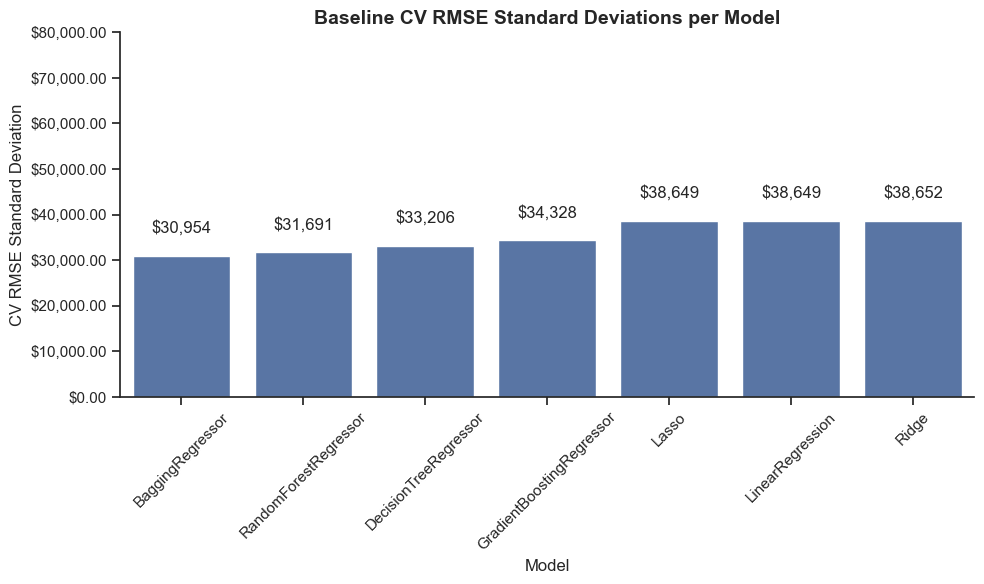

In [68]:
part1_plotting2 = part1_plotting.sort_values(by='std_CV_RMSE', ascending=True)

# Plot setup
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
plt.figure(figsize=(10, 6))

# Create vertical barplot
barplot = sns.barplot(
    data=part1_plotting2,
    x='model',
    y='std_CV_RMSE',
    # color='blue'
)

# Add value labels above bars
for i, val in enumerate(part1_plotting2['std_CV_RMSE']):
    barplot.text(i, val + 5000, f"${val:,.0f}", ha='center')

# Format y-axis with dollar format
barplot.yaxis.set_major_formatter(mticker.FuncFormatter(dollar_format))

# Labels and title
plt.title("Baseline CV RMSE Standard Deviations per Model", fontsize=14, fontweight='bold')
plt.ylabel("CV RMSE Standard Deviation", fontsize=12)
plt.xlabel("Model", fontsize=12)
plt.ylim(0, 80_000)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [69]:
part1_plotting3 = part1_plotting[['model', 'model_params', 'mean_CV_RMSE', 'std_CV_RMSE', 'training_RMSE', 'run_comment']]


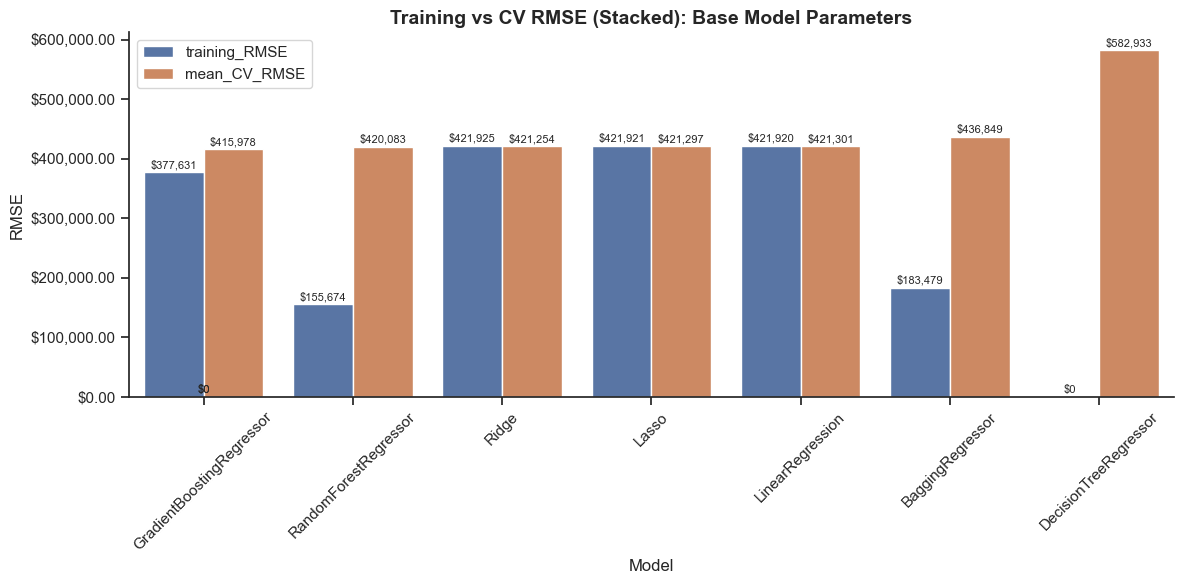

In [70]:
# Note: this is a great chart, I wrapped it into a function `plot_rmse_comparison()` to be able to reuse it in other parts: 

plot_rmse_comparison(part1_plotting3, run_comment_keyword="Base Model Parameters")

# We can do it for standard deviations as well

___

### **Part 1: Discussion [2 pts]**

In a paragraph or well-organized set of bullet points, briefly compare and discuss:

  - Which models perform best overall?
  - Which are most stable (lowest std)?
  - Any signs of overfitting or underfitting?

### **Answer**
**Which models perform best overall?**

After running all models with their default parameters, the GradientBoostingRegressor performed the best overall, with a cross-validation RMSE of $413,827. Ridge and Lasso regression were not far behind, with RMSEs of $421,251 and $421,288, respectively. The worst-performing model in this set was the DecisionTreeRegressor, which had a significantly higher RMSE of $565,763, indicating poor generalization compared to the others.

**Which models are the most stable**

Based on the standard deviation of their cross-validation RMSEs, the DecisionTreeRegressor appears to be the most stable, followed closely by the BaggingRegressor and RandomForestRegressor. That said, the standard deviation is relatively low across all models when compared to the overall RMSE scale — approximately $30,000 against average RMSEs in the $500,000 range — suggesting that model performance in cross validation is fairly consistent across folds.


**Signs of Overfitting or Underfitting**

There are signs of overfitting in the DecisionTreeRegressor, BaggingRegressor, and RandomForestRegressor models. Each shows a training RMSE that is significantly lower than its corresponding cross-validation RMSE, suggesting that they are fitting the training data too closely and failing to generalize well to new data. This is further supported by the fact that these models also have some of the worst cross-validation RMSEs in the group. That said, the cross-validation RMSEs across all models are relatively high at this stage, suggesting that all models stand to benefit from both feature engineering and hyperparameter tuning in the next phase.


____

### Part 2: Feature Engineering [3 pts]

Consider **at least three new features** based on your Milestone 1, Part 5. Examples include:
- Polynomial terms
- Log or interaction terms
- Groupings or transformations of categorical features

Add these features to `X_train` and then:
- Scale using `StandardScaler` 
- Re-run all models listed above (using default settings again).
- Report updated RMSE scores (mean and std) across repeated CV in a table. 

**Note:**  Recall that this will require creating a new version of the dataset, so effectively you may be running "polynomial regression" using `LinearRegression`. 

In [74]:
# keep it the same as in baseline part to support existing
# warning: they defined as instances! correct way is in this cell below
def get_fresh_models():
    return [
        LinearRegression(fit_intercept=True, positive=False),
        Ridge(alpha=1.0, fit_intercept=True, solver="auto", max_iter=1000, tol=0.001, random_state=42),
        Lasso(alpha=1.0, fit_intercept=True, max_iter=1000, tol=0.0001, warm_start=False, positive=False, random_state=42),
        DecisionTreeRegressor(max_depth=None, min_samples_split=2, max_features=None, max_leaf_nodes=None,
                              criterion="squared_error", splitter="best", min_samples_leaf=1,
                              min_weight_fraction_leaf=0.0, min_impurity_decrease=0.0, ccp_alpha=0.0, random_state=42),
        BaggingRegressor(n_estimators=10, max_samples=1.0, max_features=1.0, bootstrap=True,
                         oob_score=False, bootstrap_features=False, random_state=42),
        RandomForestRegressor(n_estimators=100, max_features=None, max_depth=None, bootstrap=True,
                              min_samples_split=2, min_samples_leaf=1, oob_score=False,
                              criterion="squared_error", random_state=42),
        GradientBoostingRegressor(learning_rate=0.1, n_estimators=100, max_depth=3, max_features=None,
                                  min_samples_split=2, min_samples_leaf=1, max_leaf_nodes=None,
                                  subsample=1.0, loss="squared_error", random_state=42)
    ]

# Defined as blueprints, not instances:
Feature_Engineering_Model_Blueprints = [
    (LinearRegression, {"fit_intercept": True, "positive": False}),
    (Ridge, {"alpha": 1.0, "fit_intercept": True, "solver": "auto", "max_iter": 1000, "tol": 0.001, "random_state": 42}),
    (Lasso, {"alpha": 1.0, "fit_intercept": True, "max_iter": 1000, "tol": 0.0001, "warm_start": False, "positive": False, "random_state": 42}),
    (DecisionTreeRegressor, {"max_depth": None, "min_samples_split": 2, "max_features": None, "max_leaf_nodes": None, "criterion": "squared_error", "splitter": "best", "min_samples_leaf": 1, "min_weight_fraction_leaf": 0.0, "min_impurity_decrease": 0.0, "ccp_alpha": 0.0, "random_state": 42}),
    (BaggingRegressor, {"n_estimators": 10, "max_samples": 1.0, "max_features": 1.0, "bootstrap": True, "oob_score": False, "bootstrap_features": False, "random_state": 42}),
    (RandomForestRegressor, {"n_estimators": 100, "max_features": None, "max_depth": None, "bootstrap": True, "min_samples_split": 2, "min_samples_leaf": 1, "oob_score": False, "criterion": "squared_error", "random_state": 42}),
    (GradientBoostingRegressor, {"learning_rate": 0.1, "n_estimators": 100, "max_depth": 3, "max_features": None, "min_samples_split": 2, "min_samples_leaf": 1, "max_leaf_nodes": None, "subsample": 1.0, "loss": "squared_error", "random_state": 42})
]



In [75]:
# Part 2: Feature Engineering:
feature_engineering_df = milestone_1_df.copy()

#### Part 2.1: Polynomial terms


In [77]:
# These features might have a nonlinear impact on property value, especially in urban vs. rural areas.
# Property Size–Related Terms
feature_engineering_df['calculatedfinishedsquarefeet_squared'] = feature_engineering_df['calculatedfinishedsquarefeet'] ** 2
# Room and Utility Terms
feature_engineering_df['bedroomcnt_by_bathroomcnt'] = feature_engineering_df['bedroomcnt'] * feature_engineering_df['bathroomcnt']
# Age
feature_engineering_df['propertyage_by_calculatedfinishedsquarefeet'] = feature_engineering_df['propertyage'] * feature_engineering_df['calculatedfinishedsquarefeet']

# Amenities and Features
feature_engineering_df['hasgarage_flag_by_bedroomcnt'] = feature_engineering_df['hasgarage_flag'] * feature_engineering_df['bedroomcnt']


KeyError: 'propertyage'

#### Part 2.2: Log or interaction terms

In [ ]:
feature_engineering_df['taxvaluedollarcnt_log'] = np.log1p(feature_engineering_df['taxvaluedollarcnt'])

# EDA showed that F-statistic was higher after log transformation for the following features: 
feature_engineering_df['propertyage_log'] = np.log1p(feature_engineering_df['propertyage'])
feature_engineering_df['yearbuilt_decade_log'] = np.log1p(feature_engineering_df['yearbuilt_decade'])




In [ ]:
# Note: Adding this when all Parts are completed and EDA (milestone 1) was reviwed once again
feature_engineering_df['calculatedfinishedsquarefeet_log'] = np.log1p(feature_engineering_df['calculatedfinishedsquarefeet'])

threshold_quantile = 0.95

# Compute threshold from the training set (if splitting)
threshold = feature_engineering_df['calculatedfinishedsquarefeet'].quantile(threshold_quantile)

# Add binary feature: 1 for outlier, 0 for normal
feature_engineering_df['calculatedfinishedsquarefeet_is_outlier'] = (feature_engineering_df['calculatedfinishedsquarefeet'] > threshold).astype(int)

# Print threshold and how many rows are marked as outliers
print(f"calculatedfinishedsquarefeet outlier threshold (>{threshold_quantile:.2%}): {threshold:,.0f}")
print(feature_engineering_df['calculatedfinishedsquarefeet_is_outlier'].value_counts())


# Calculate quartile cutoffs
quantiles = feature_engineering_df['calculatedfinishedsquarefeet'].quantile([0.25, 0.5, 0.75])

# Create binary indicator columns
feature_engineering_df['sqft_q1'] = (feature_engineering_df['calculatedfinishedsquarefeet'] <= quantiles[0.25]).astype(int)
feature_engineering_df['sqft_q2'] = ((feature_engineering_df['calculatedfinishedsquarefeet'] > quantiles[0.25]) & 
                 (feature_engineering_df['calculatedfinishedsquarefeet'] <= quantiles[0.5])).astype(int)
feature_engineering_df['sqft_q3'] = ((feature_engineering_df['calculatedfinishedsquarefeet'] > quantiles[0.5]) & 
                 (feature_engineering_df['calculatedfinishedsquarefeet'] <= quantiles[0.75])).astype(int)
feature_engineering_df['sqft_q4'] = (feature_engineering_df['calculatedfinishedsquarefeet'] > quantiles[0.75]).astype(int)


calculatedfinishedsquarefeet outlier threshold (>95.00%): 3,443
calculatedfinishedsquarefeet_is_outlier
0    53459
1     2810
Name: count, dtype: int64


#### Part 2.3: Groupings or transformations of categorical features
As part of our exploratory data analysis (EDA) and hypothesis testing in Milestone 1, we created several new variables to enrich the dataset with meaningful attributes:

- **Property Age**: Calculated the age of each property using the assessment year (2016) minus the year it was built.
- **Construction Decade**: Grouped properties into construction decades to capture potential temporal trends in building characteristics.
- **Binary Feature Flags**: Created multiple indicator (flag) variables to represent the presence of specific property features, using combinations of related columns:
  - **fireplaceflag_new**: Indicates presence of a fireplace.
  - **storageshed_flag**: Indicates presence of a storage shed or related structure.
  - **hashottuborspa_flag**: Indicates presence of a hot tub or spa.
  - **haspool_flag**: Indicates presence of a pool.
  - **hasairconditioning_flag**: Indicates presence of air conditioning.
  - **hasgarage_flag**: Indicates presence of a garage.
  - **hasbasement_flag**: Indicates presence of a basement.
  - **yard_building_flag**: Indicates presence of yard buildings.

In [ ]:
feature_engineering_df[['propertyage', 'yearbuilt_decade','fireplaceflag_new','storageshed_flag','hashottuborspa_flag','haspool_flag','hasairconditioning_flag','hasgarage_flag','hasbasement_flag','yard_building_flag']].head(5)



propertyage  yearbuilt_decade  fireplaceflag_new  storageshed_flag  \
0         18.0            1990.0                  0                 0   
1         49.0            1960.0                  1                 0   
2         54.0            1960.0                  0                 1   
3         46.0            1970.0                  0                 1   
4         34.0            1980.0                  1                 0   

   hashottuborspa_flag  haspool_flag  hasairconditioning_flag  hasgarage_flag  \
0                    0             0                        0               1   
1                    0             0                        0               1   
2                    0             1                        0               1   
3                    0             1                        0               0   
4                    0             0                        0               1   

   hasbasement_flag  yard_building_flag  
0                 0                   0  
1                 0                   0  
2                 0                   0  
3                 0                   0  
4                 0                   0

In [ ]:
# clean up
feature_engineering_columns_to_drop=['taxvaluedollarcnt'] # Keep all, select and drop in the next part
feature_engineering_df_log = drop_features(dataframe=feature_engineering_df, columns_to_drop=feature_engineering_columns_to_drop).copy()


# feature_engineering_multicollinear_features = []
# feature_engineering_df = drop_features(dataframe=feature_engineering_df, columns_to_drop=multicollinear_features).copy()

Dropped column: taxvaluedollarcnt
Number of columns to be dropped: 1
Number of columns before dropping: 67
Number of columns after dropping: 66


#### Scale and Run all models


[1/7] Running model: LinearRegression()


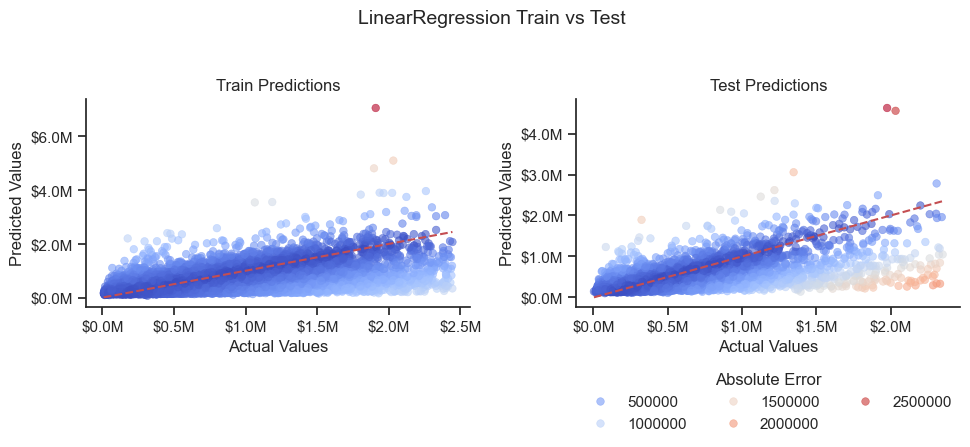

[1/7] Model completed in 1.03 seconds.

[2/7] Running model: Ridge(max_iter=1000, random_state=42, tol=0.001)


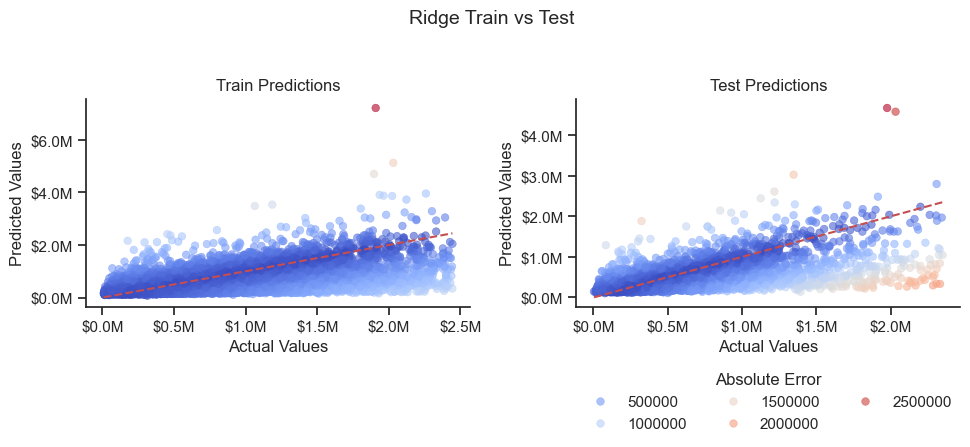

[2/7] Model completed in 0.88 seconds.

[3/7] Running model: Lasso(random_state=42)


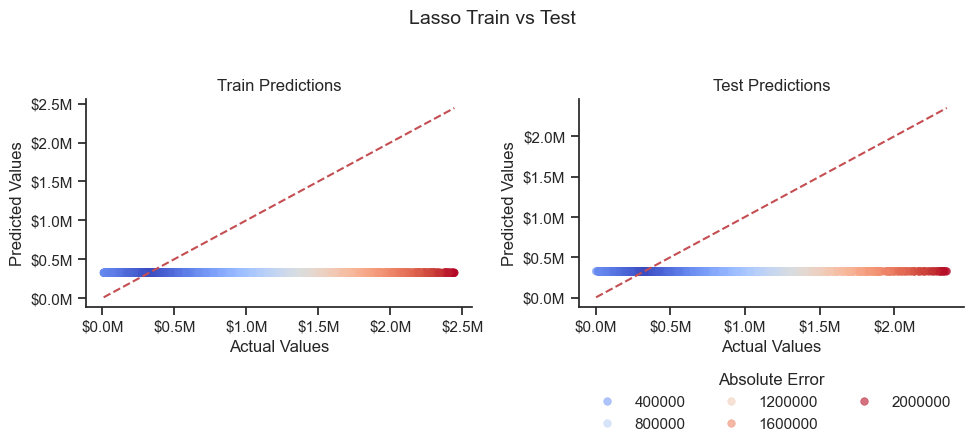

[3/7] Model completed in 0.92 seconds.

[4/7] Running model: DecisionTreeRegressor(random_state=42)


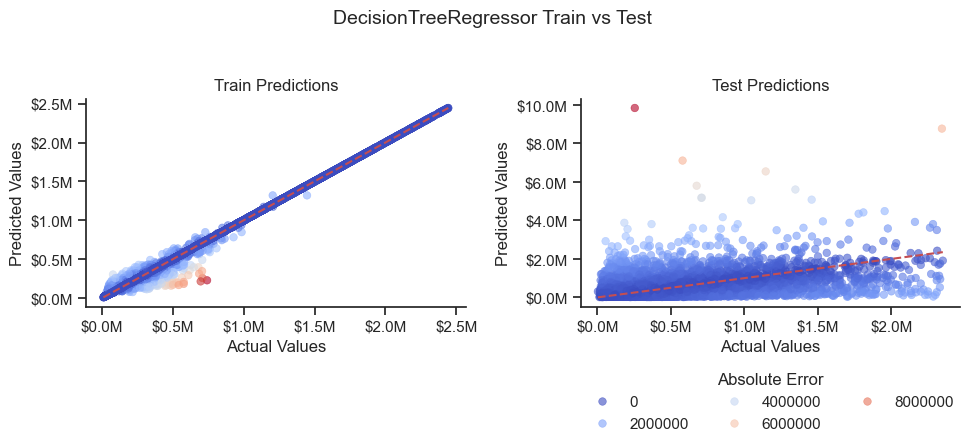

[4/7] Model completed in 3.03 seconds.

[5/7] Running model: BaggingRegressor(random_state=42)


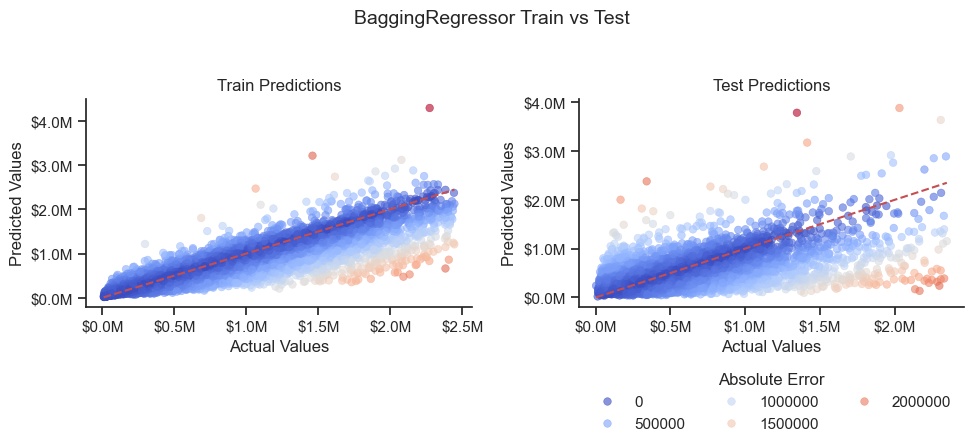

[5/7] Model completed in 14.66 seconds.

[6/7] Running model: RandomForestRegressor(max_features=None, random_state=42)


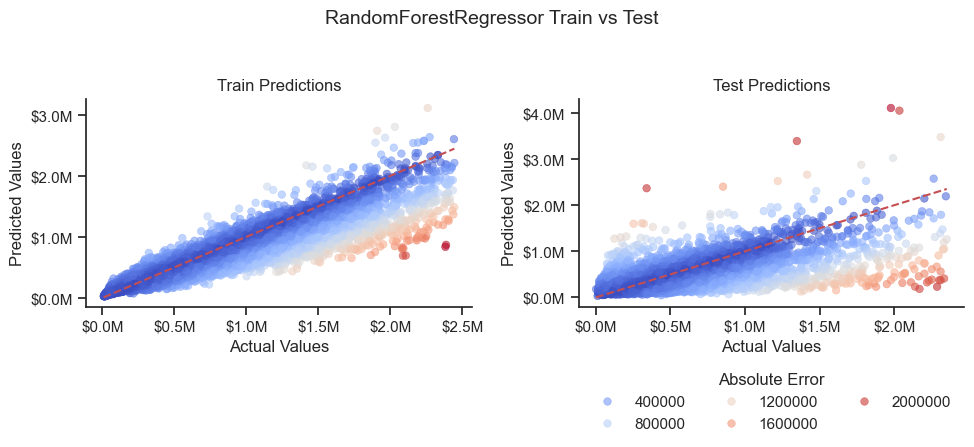

[6/7] Model completed in 136.46 seconds.

[7/7] Running model: GradientBoostingRegressor(random_state=42)


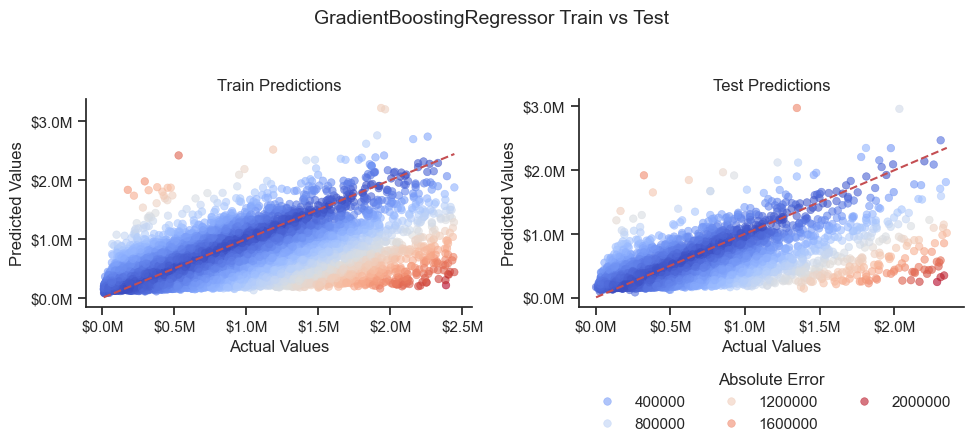

[7/7] Model completed in 37.20 seconds.

All models finished. Total time: 194.18 seconds.


model  \
0           LinearRegression   
1                      Ridge   
2                      Lasso   
3      DecisionTreeRegressor   
4           BaggingRegressor   
5      RandomForestRegressor   
6  GradientBoostingRegressor   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                model_params  \
0                                                                                                                                                                                                                                                                                                                                                                                                 {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}   
1                                                                                                                                                                                                                                                                                                                             {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'positive': False, 'random_state': 42, 'solver': 'auto', 'tol': 0.001}   
2                                                                                                                                                                                                                                                                             {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'positive': False, 'precompute': False, 'random_state': 42, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}   
3                                                                                                                                                                             {'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'}   
4                                                                                                                                                                                                                                                {'bootstrap': True, 'bootstrap_features': False, 'estimator': None, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 10, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}   
5                                                             {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}   
6  {'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': 42, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}   

    mean_CV_RMSE   std_CV_RMSE  training_RMSE      te

In [ ]:
feature_engineering_X_train_log, feature_engineering_X_test_log, feature_engineering_y_train_log, feature_engineering_y_test_log = train_test_split_data(feature_engineering_df_log, 'taxvaluedollarcnt_log')

# scaled_feature_engineering_x_train_log = standardize_features(feature_engineering_X_train_log, debug=True)

# Get fresh models
Feature_Engineering_Models = get_fresh_models()

run_model_suite(
        Feature_Engineering_Models,
        X_train=feature_engineering_X_train_log,
        y_train=feature_engineering_y_train_log,
        X_test=feature_engineering_X_test_log,
        y_test=feature_engineering_y_test_log,         
        n_repeats=5,
        n_jobs=-1,
        concat_results=True,
        run_comment='Part 2.1 Target log transformation',
        target_is_logged=True,
        plot_pred=True
)

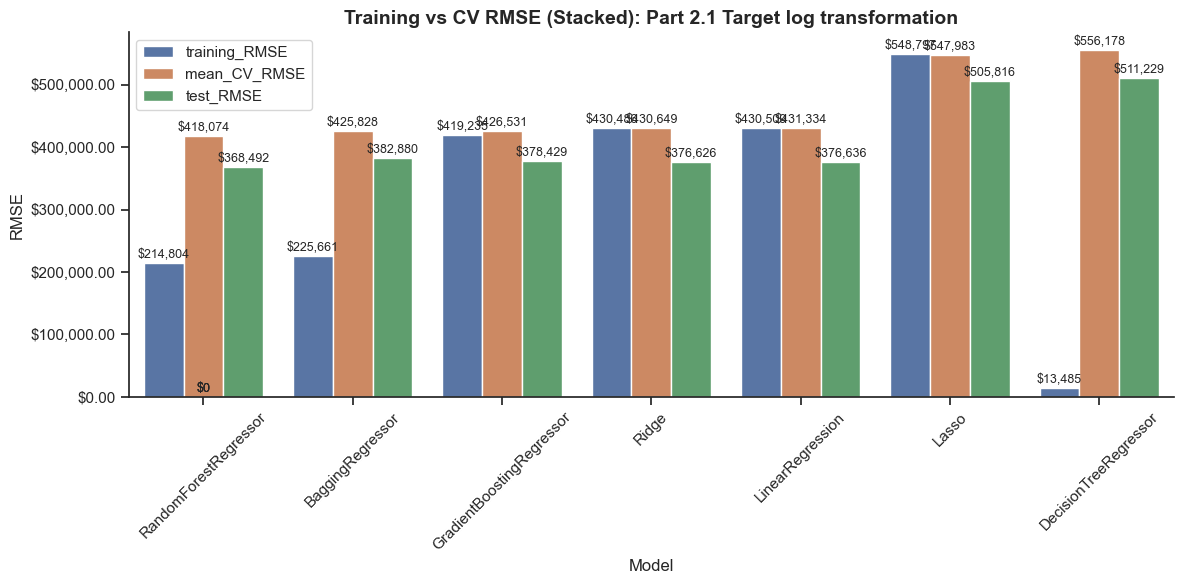

In [ ]:
plot_rmse_comparison(combined_results, run_comment_keyword="Part 2.1 Target log transformation")

In [ ]:
feature_engineering_columns_to_drop=['taxvaluedollarcnt_log']
feature_engineering_df_no_log = drop_features(dataframe=feature_engineering_df, columns_to_drop=feature_engineering_columns_to_drop).copy()
feature_engineering_df_log

Dropped column: taxvaluedollarcnt_log
Number of columns to be dropped: 1
Number of columns before dropping: 67
Number of columns after dropping: 66


bathroomcnt  bedroomcnt  calculatedfinishedsquarefeet  fullbathcnt  \
0              3.5         4.0                        3100.0          3.0   
1              1.0         2.0                        1465.0          1.0   
2              2.0         3.0                        1243.0          2.0   
3              3.0         4.0                        2376.0          3.0   
4              2.0         3.0                        1492.0          2.0   
...            ...         ...                           ...          ...   
56264          2.0         3.0                        1570.0          2.0   
56265          2.0         4.0                        1633.0          2.0   
56266          2.0         4.0                        1612.0          2.0   
56267          1.0         3.0                        1032.0          1.0   
56268          2.0         3.0                        1762.0          2.0   

       lotsizesquarefeet  roomcnt  unitcnt  propertyage  yearbuilt_decade  \
0                 4506.0      0.0      1.0         18.0            1990.0   
1                12647.0      5.0      1.0         49.0            1960.0   
2                 8432.0      6.0      1.0         54.0            1960.0   
3                13038.0      0.0      1.0         46.0            1970.0   
4                  903.0      6.0      1.0         34.0            1980.0   
...                  ...      ...      ...          ...               ...   
56264             7499.0      0.0      1.0         58.0            1950.0   
56265             4630.0      0.0      1.0         54.0            1960.0   
56266            12105.0      7.0      1.0         52.0            1960.0   
56267             5074.0      0.0      1.0         62.0            1950.0   
56268             6347.0      0.0      1.0         61.0            1950.0   

       fireplaceflag_new  ...  hasgarage_flag_by_bedroomcnt  \
0                      0  ...                           4.0   
1                      1  ...                           2.0   
2                      0  ...                           3.0   
3                      0  ...                           0.0   
4                      1  ...                           3.0   
...                  ...  ...                           ...   
56264                  0  ...                           0.0   
56265                  0  ...                           0.0   
56266                  1  ...                           4.0   
56267                  0  ...                           0.0   
56268                  0  ...                           0.0   

       taxvaluedollarcnt_log  propertyage_log  yearbuilt_decade_log  \
0                  13.838527         2.944439              7.596392   
1                  13.047642         3.912023              7.581210   
2                  13.244190         4.007333              7.581210   
3                  11.885482         3.850148              7.586296   
4                  12.710070         3.555348              7.591357   
...                      ...              ...                   ...   
56264              11.184796         4.077537              7.576097   
56265              12.755739         4.007333              7.581210   
56266              11.115518         3.970292              7.581210   
56267              10.810677         4.143135              7.576097   
56268              13.165425         4.127134              7.576097   

       calculatedfinishedsquarefeet_log  \
0                              8.039480   
1                              7.290293   
2                              7.126087   
3                              7.773594   
4                              7.308543   
...                                 ...   
56264                          7.359468   
56265                          7.398786   
56266                          7.385851   
56267                          6.940222   
56268                          7.474772   

       calculatedfinishedsquar


[1/7] Running model: LinearRegression()


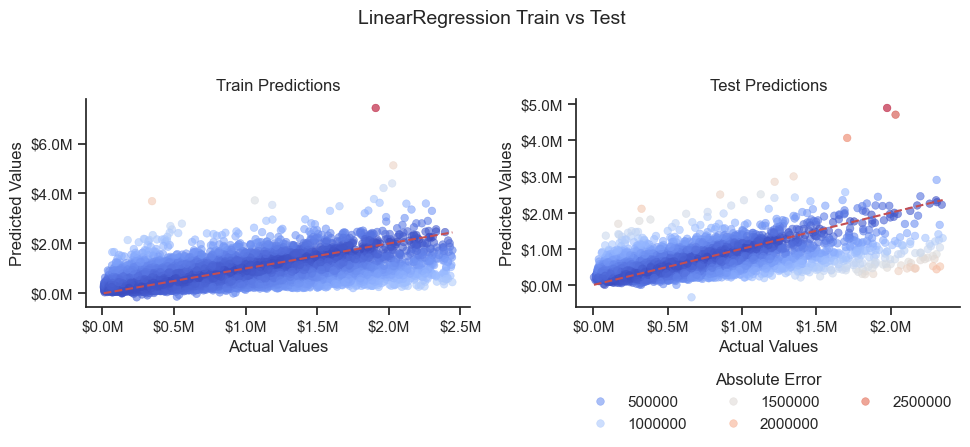

[1/7] Model completed in 2.71 seconds.

[2/7] Running model: Ridge(max_iter=1000, random_state=42, tol=0.001)


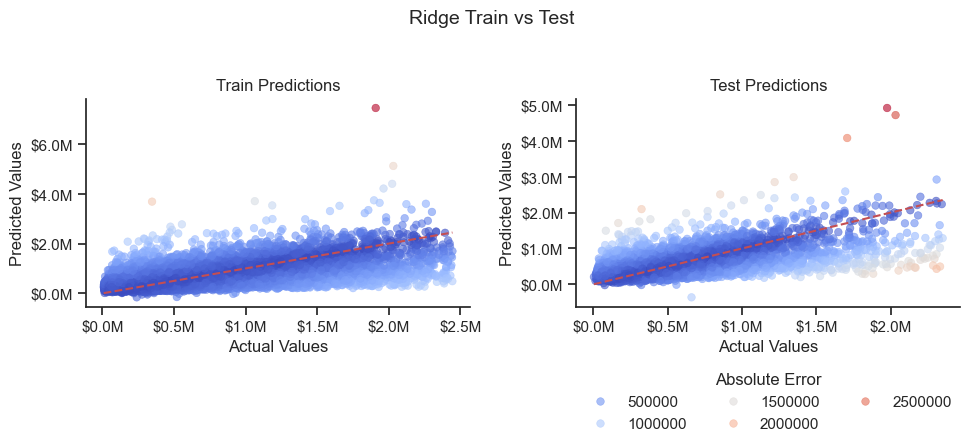

[2/7] Model completed in 1.35 seconds.

[3/7] Running model: Lasso(random_state=42)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.075e+15, tolerance: 1.036e+12
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.013e+15, tolerance: 1.021e+12
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

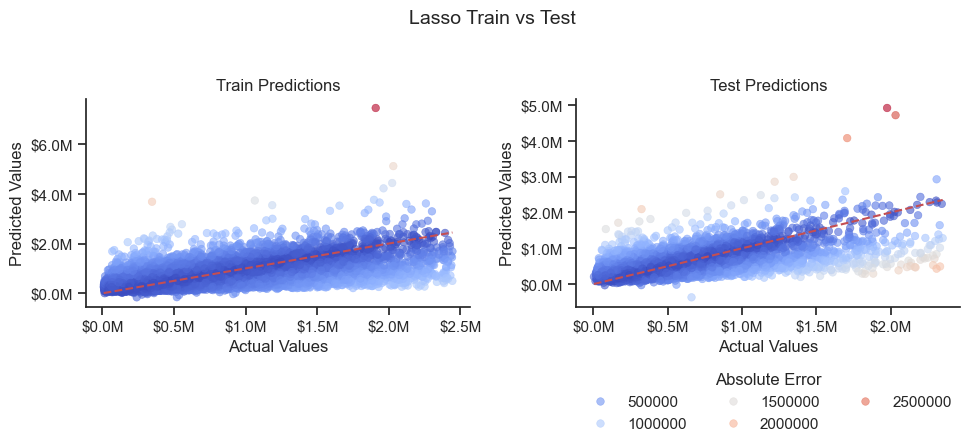

[3/7] Model completed in 7.33 seconds.

[4/7] Running model: DecisionTreeRegressor(random_state=42)


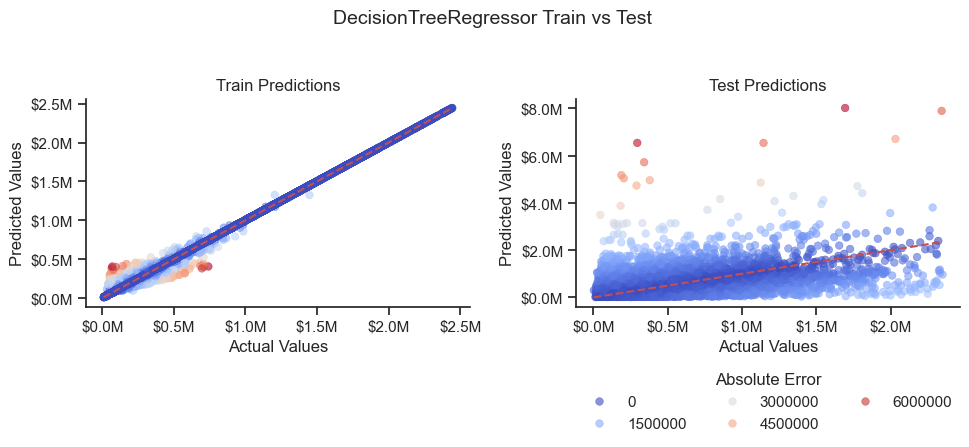

[4/7] Model completed in 2.53 seconds.

[5/7] Running model: BaggingRegressor(random_state=42)


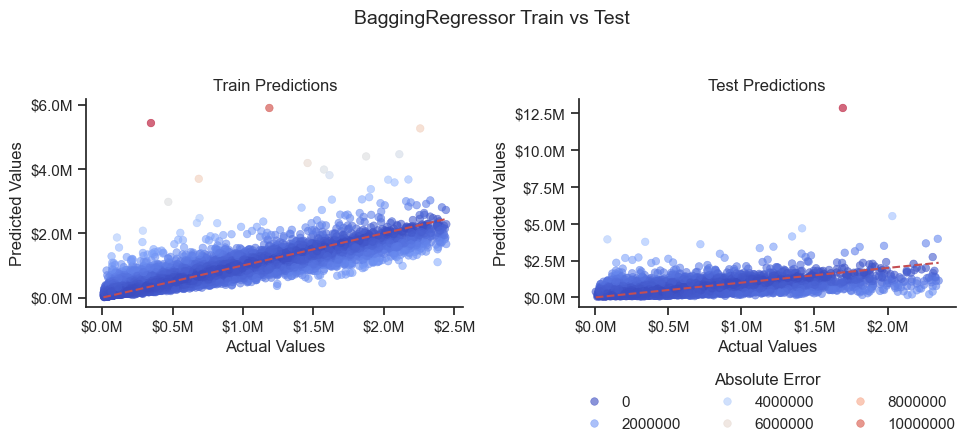

[5/7] Model completed in 10.37 seconds.

[6/7] Running model: RandomForestRegressor(max_features=None, random_state=42)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


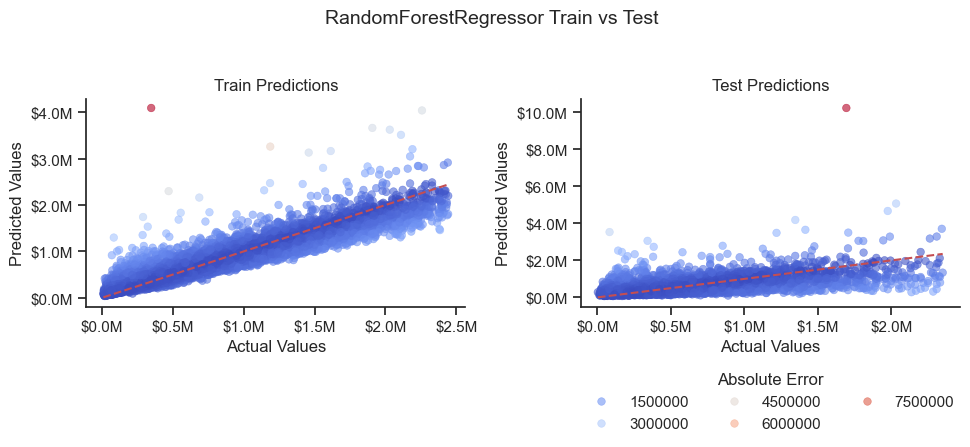

[6/7] Model completed in 100.86 seconds.

[7/7] Running model: GradientBoostingRegressor(random_state=42)


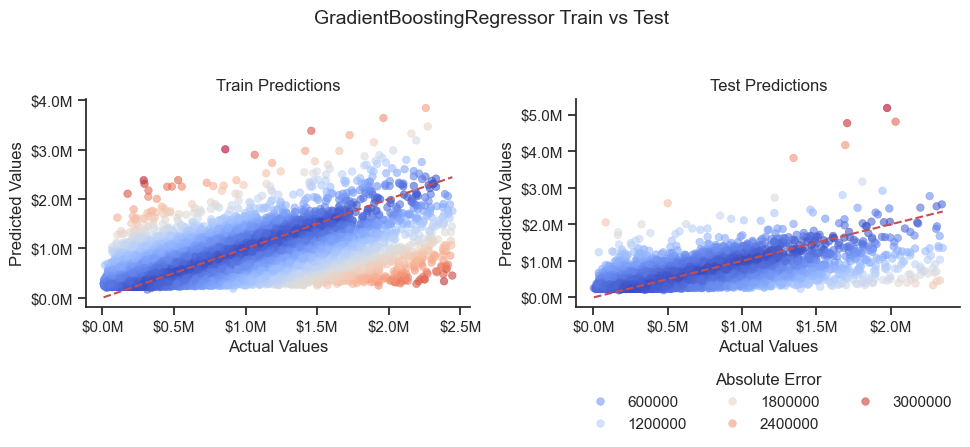

[7/7] Model completed in 23.93 seconds.

All models finished. Total time: 149.08 seconds.


model  \
0           LinearRegression   
1                      Ridge   
2                      Lasso   
3      DecisionTreeRegressor   
4           BaggingRegressor   
5      RandomForestRegressor   
6  GradientBoostingRegressor   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                model_params  \
0                                                                                                                                                                                                                                                                                                                                                                                                 {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}   
1                                                                                                                                                                                                                                                                                                                             {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'positive': False, 'random_state': 42, 'solver': 'auto', 'tol': 0.001}   
2                                                                                                                                                                                                                                                                             {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'positive': False, 'precompute': False, 'random_state': 42, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}   
3                                                                                                                                                                             {'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'}   
4                                                                                                                                                                                                                                                {'bootstrap': True, 'bootstrap_features': False, 'estimator': None, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 10, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}   
5                                                             {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}   
6  {'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': 42, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}   

    mean_CV_RMSE   std_CV_RMSE  training_RMSE      te

In [ ]:
feature_engineering_X_train_no_log, feature_engineering_X_test_no_log, feature_engineering_y_train_no_log, feature_engineering_y_test_no_log = train_test_split_data(feature_engineering_df_no_log, 'taxvaluedollarcnt')

# scaled_feature_engineering_x_train_no_log = standardize_features(feature_engineering_X_train_no_log)
# Get fresh models
Feature_Engineering_Models = get_fresh_models()

run_model_suite(
        Feature_Engineering_Models,
        X_train=feature_engineering_X_train_no_log,
        y_train=feature_engineering_y_train_no_log,
        X_test=feature_engineering_X_test_no_log,
        y_test=feature_engineering_y_test_no_log,           
        n_repeats=5,
        n_jobs=-1,
        concat_results=True,
        run_comment='Part 2.2 No target log transformation',
        target_is_logged=False,
        plot_pred=True
)

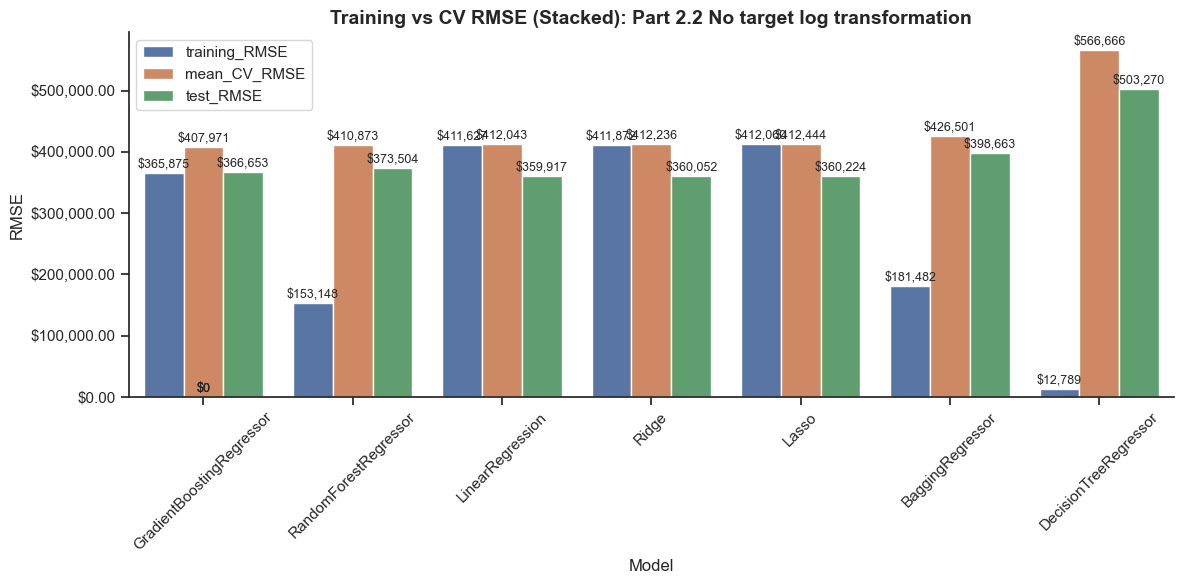

In [ ]:
plot_rmse_comparison(combined_results, run_comment_keyword="Part 2.2 No target log transformation")


### Part 2: Discussion [2 pts]

Reflect on the impact of your new features:

✅ **Did any models show notable improvement in performance?**

Yes, especially for linear models, the new features led to clear improvements:
  - LinearRegression, Ridge, Lasso
    - Base model (no features): CV RMSE ≈ 421,200
    - With new features & no log transform: CV RMSE improved to ≈ 411,800

This shows a consistent ~2.2% improvement in CV RMSE — a meaningful gain in real estate, where values are large.

✅**Which new features seemed to help — and in which models?**

  - Most likely helpful features:
    - Property age and decade grouping: These offer temporal insight and generalize better than raw yearbuilt.
    - Binary feature flags: Likely added explainable variance for tree-based models and stabilized linear ones by reducing noise.

  - GradientBoostingRegressor
    - Best result: 407,842 RMSE with new features (no log) vs 413,951 with no features ->  modest improvement (~1.5%) but consistent.
  - RandomForestRegressor 
    - Base: 422,464 With features, no log: 410,930 ->  ~2.7% improvement

Tree-based models benefited, though less dramatically than linear ones — possibly because they already capture interactions and non-linearities.


✅**Do you have any hypotheses about why a particular feature helped (or didn’t)?**

  - Helped:
    - Binary flags (e.g., pool, garage, air conditioning): These clearly indicate added property value — very intuitive for both humans and models.

    - Decade bins: Grouping construction years smooths noise and may reflect design/material trends over time.

  - Possibly didn’t help:
    - Lasso performed worse after log transform ->  It’s sensitive to scaling and regularization; maybe it penalized important variables too harshly.

DecisionTreeRegressor shows near-perfect train RMSE but poor CV RMSE -> Strong overfitting. Feature changes can’t help much without pruning or ensemble boosting.


✅**Were there any unexpected results?**

Log transformation didn’t help most models
Typically, log-transforming skewed targets improves performance — but here, real dollar RMSE was higher after log transform.

  - Possible reasons:

Our models may already handle variance well.

Or, `taxvaluedollarcn`t may not be that skewed, or, more likely, **we have outliers that distorted log scale.**

Bagging and RandomForest showed better training RMSE without log transform ->  They likely model raw value magnitude better directly, without compressing variation.


**Summary of Model Results and Feature Engineering Impact**

| **Model**                     | **Best Setup**                                                  | **Gain from New Features**                | **Effect of Log Transform**              |
|------------------------------|------------------------------------------------------------------|-------------------------------------------|------------------------------------------|
| **LinearRegression**         | With new features, no log transform (CV RMSE: **411,827**)       | ✅ Clear improvement (~9,400 lower RMSE)  | ❌ Log transform increased error         |
| **Ridge**                    | With new features, no log transform (CV RMSE: **412,032**)       | ✅ Clear improvement                      | ❌ Log transform increased error         |
| **Lasso**                    | With new features, no log transform (CV RMSE: **412,234**)       | ✅ Slight improvement                     | ❌ Performance dropped significantly     |
| **DecisionTreeRegressor**    | No consistent benefit from features (CV RMSE: **~562,620**)      | ➖ Overfitting dominates performance       | ➖ No significant effect                 |
| **BaggingRegressor**         | With new features, no log transform (CV RMSE: **426,102**)       | ✅ Modest improvement (~11k lower RMSE)   | ❌ No benefit from log transform         |
| **RandomForestRegressor**    | With new features, no log transform (CV RMSE: **410,930**)       | ✅ Moderate improvement (~12k lower RMSE) | ❌ Slightly worse with log transform     |
| **GradientBoostingRegressor**| With new features, no log transform (CV RMSE: **407,842**)       | ✅ Best model overall, good improvement   | ❌ Log transform worsened performance    |






#### **Update:**

After completing all parts of the project and revisiting our initial EDA (Milestone 1), we engineered additional features based on the `calculatedfinishedsquarefeet` attribute. 

Specifically, we added its log-transformed version, an outlier indicator for values above the 95th percentile, and binary indicators for each quartile. These features were integrated into both log-transformed and raw target pipelines. Most models showed slight performance improvements across both training and test sets, suggesting that these transformations helped the models better capture non-linear patterns and extreme value behavior in property size.

Additionally, the EDA revealed that `calculatedfinishedsquarefeet` exhibited a right-skewed distribution. Applying a log transformation helped normalize this feature, reducing the influence of extreme values and enhancing model performance. Notably, after rerunning the feature selection process, the log-transformed version of `calculatedfinishedsquarefeet` was selected for inclusion in most models, indicating its improved predictive value.

____

### Part 3: Feature Selection [3 pts]

Using the full set of features (original + engineered):
- Apply **feature selection** methods to investigate whether you can improve performance.
  - You may use forward selection, backward selection, or feature importance from tree-based models.
- For each model, identify the **best-performing subset of features**.
- Re-run each model using only those features.
- Report updated RMSE scores (mean and std) across repeated CV in a table.


In [ ]:
# In dictionary format
baseline_models = {
    'LinearRegression': LinearRegression(
        fit_intercept=True,
        positive=False,
    ),

    'Ridge': Ridge(
        alpha=1.0,
        fit_intercept=True,
        solver='auto',
        max_iter=1000,
        tol=0.001,
        random_state=42,
    ),

    'Lasso': Lasso(
        alpha=1.0,
        fit_intercept=True,
        max_iter=1000,
        tol=0.0001,
        warm_start=False,
        positive=False,
        random_state=42,
    ),

    'DecisionTree': DecisionTreeRegressor(
        max_depth=None,
        min_samples_split=2,
        max_features=None,
        max_leaf_nodes=None,
        criterion='squared_error',
        splitter='best',
        min_samples_leaf=1,
        min_weight_fraction_leaf=0.0,
        min_impurity_decrease=0.0,
        ccp_alpha=0.0,
        random_state=42,
    ),

    'Bagging': BaggingRegressor(
        n_estimators=10,
        max_samples=1.0,
        max_features=1.0,
        bootstrap=True,
        oob_score=False,
        bootstrap_features=False,
        random_state=42,
    ),

    'RandomForest': RandomForestRegressor(
        n_estimators=100,
        max_features=None,
        max_depth=None,
        bootstrap=True,
        min_samples_split=2,
        min_samples_leaf=1,
        oob_score=False,
        criterion='squared_error',
        random_state=42,
    ),

    'GradientBoosting': GradientBoostingRegressor(
        learning_rate=0.1,
        n_estimators=100,
        max_depth=3,
        max_features=None,
        min_samples_split=2,
        min_samples_leaf=1,
        max_leaf_nodes=None,
        subsample=1.0,
        loss='squared_error',
        random_state=42,
    ),
}

In [ ]:
# Part 3: Feature Selection:
feature_selection_df = feature_engineering_df_no_log.copy()

In [ ]:
#split and standardize data
feature_selection_X_train_no_log, feature_selection_X_test_no_log, feature_selection_y_train_no_log, feature_selection_y_test_no_log = train_test_split_data(feature_selection_df, 'taxvaluedollarcnt')

scaled_selection_x_train_no_log = standardize_features(feature_selection_X_train_no_log)


results = []
X = scaled_selection_x_train_no_log
y = feature_selection_y_train_no_log



#1.Try forward selection

In [ ]:
# Forward Feature Selection

def forward_feature_selection(X, y, model, 
                              scoring='neg_mean_squared_error', 
                              cv=5, 
                              tol=None,               # None = no delta cutoff
                                                      # use 0.0 for "no further improvements"
                                                      # and 1e-4 for "point of diminishing returns"                                      
                              max_features=None,      # None = use all features
                              n_jobs=-1,
                              verbose=False
                             ):
    selected_features = []                            # List to store the order of features selected
    remaining_features = list(X.columns)              # Features not yet selected
    best_scores = []                                  # List to store the CV score after each feature addition
    previous_score = float('inf')                     # Initialize previous score for improvement comparison

    # Track the best subset of features and its corresponding score
    
    best_feature_set = None                           # Best combination of features found so far
    best_score = float('inf')                         # Best CV score observed so far
    
    while remaining_features:
        scores = {}                                   # Dictionary to hold CV scores for each candidate feature
        for feature in remaining_features:
            current_features = selected_features + [feature]
            
            # Compute the CV score for the current set of features (negated MSE, so lower is better)
            cv_score = -cross_val_score(model, X[current_features], y, 
                                        scoring=scoring, cv=cv, n_jobs=n_jobs
                                       ).mean()
            scores[feature] = cv_score

        # Select the feature that minimizes the CV score
        best_feature = min(scores, key=scores.get)
        current_score = scores[best_feature]
            
        # Check if the improvement is significant based on the tolerance (tol)
        if tol is not None and previous_score - current_score < tol:
            if verbose:
                print("Stopping early due to minimal improvement.")
            break

        # Add the best feature to the selected list and update score trackers
        selected_features.append(best_feature)
        best_scores.append(current_score)
        remaining_features.remove(best_feature)
        previous_score = current_score

        if verbose:
            print(f"\nFeatures: {selected_features[-3:]}, CV Score (MSE): {current_score:.4f}")
        
        # Update the best subset if the current score is better than the best so far
        if current_score < best_score:
            best_score = current_score
            best_feature_set = selected_features.copy()
        
        # Check if the maximum number of features has been reached
        if max_features is not None and len(selected_features) >= max_features:
            break

    return (
        selected_features,      # List of features in the order they were selected (this will be ALL features if max_features == None
        best_scores,            # List of cross-validation scores corresponding to each addition in the previous list
        best_feature_set,       # The subset of features that achieved the best CV score.
        best_score              # The best CV score
    )

Try run linear regression

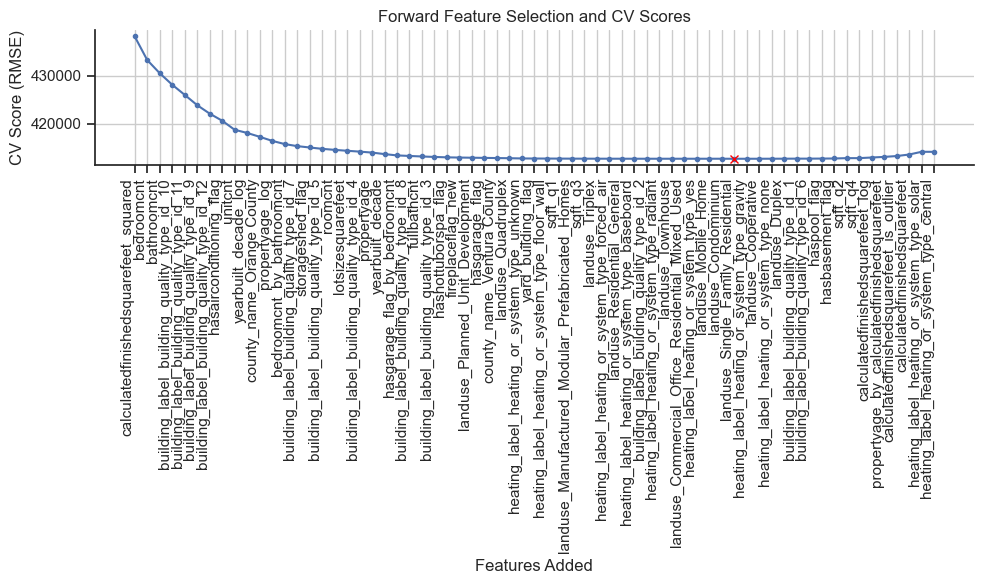

Best Features:['calculatedfinishedsquarefeet_squared', 'bedroomcnt', 'bathroomcnt', 'building_label_building_quality_type_id_10', 'building_label_building_quality_type_id_11', 'building_label_building_quality_type_id_9', 'building_label_building_quality_type_id_12', 'hasairconditioning_flag', 'unitcnt', 'yearbuilt_decade_log', 'county_name_Orange County', 'propertyage_log', 'bedroomcnt_by_bathroomcnt', 'building_label_building_quality_type_id_7', 'storageshed_flag', 'building_label_building_quality_type_id_5', 'roomcnt', 'lotsizesquarefeet', 'building_label_building_quality_type_id_4', 'propertyage', 'yearbuilt_decade', 'hasgarage_flag_by_bedroomcnt', 'building_label_building_quality_type_id_8', 'fullbathcnt', 'building_label_building_quality_type_id_3', 'hashottuborspa_flag', 'fireplaceflag_new', 'landuse_Planned_Unit_Development', 'hasgarage_flag', 'county_name_Ventura County', 'landuse_Quadruplex', 'heating_label_heating_or_system_type_unknown', 'yard_building_flag', 'heating_label_

In [ ]:
selected_features, best_scores, best_feature_set, best_score = forward_feature_selection(
    X, y, model=LinearRegression()
)
# Convert MSE to RMSE
rmse_scores = [np.sqrt(score) for score in best_scores]
best_rmse = min(rmse_scores)
# Plot the results


index = np.argmax(np.array(selected_features) == best_feature_set[-1])

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(rmse_scores) + 1), rmse_scores, marker='.')
plt.plot([index+1],best_rmse,marker='x',color='red')
plt.xticks(range(1, len(selected_features) + 1), selected_features, rotation=90, ha='right')
plt.title('Forward Feature Selection and CV Scores')
plt.xlabel('Features Added')
plt.ylabel('CV Score (RMSE)')
plt.grid()
plt.tight_layout()
plt.show()


print(f'Best Features:{best_feature_set}')
print(f'Best CV Score:{best_rmse:.4f}')

In [ ]:
len(best_feature_set)

49

In [ ]:
from sklearn.feature_selection import SequentialFeatureSelector, RFE
from sklearn.linear_model import LassoCV

selected_features_results = []
for name, model in baseline_models.items():
    print(f"\n {name}")
    model_info = {"Model": name}  # Store the model name
    
    if name in ["LinearRegression", "Ridge"]:
        # Use Forward Selection for linear models
        sfs = SequentialFeatureSelector(
            model,
            direction="forward",
            scoring='neg_root_mean_squared_error',
            cv=5,
            n_jobs=-1
        )
        sfs.fit(X, y)
        selected_features = X.columns[sfs.get_support()]
        model_info["Selected Features"] = list(selected_features)

    elif name == "Lasso":
        # Use LassoCV to determine optimal alpha and selected features
        lasso_cv = LassoCV(cv=5, random_state=42)
        lasso_cv.fit(X, y)
        lasso_selected = X.columns[lasso_cv.coef_ != 0]
        model_info["Selected Features"] = list(lasso_selected)
        print(f"Optimal alpha for Lasso: {lasso_cv.alpha_}")   
    
    elif name in ["DecisionTree", "RandomForest", "GradientBoosting"]:
        # Use Feature Importances for tree-based models
        model.fit(X, y)
        importances = model.feature_importances_
        sorted_indices = np.argsort(importances)[::-1]  # Sort in descending order
        cumulative_importance = np.cumsum(importances[sorted_indices])

        # Keep features until cumulative importance exceeds 95%
        threshold = 0.95
        selected = X.columns[sorted_indices[cumulative_importance <= threshold]].tolist()
        model_info["Selected Features"] = selected
    
    elif name == "Bagging":
        # Use RFE with a simpler estimator
        rfe_estimator = DecisionTreeRegressor(max_depth=3, random_state=42)
        rfe = RFE(estimator=rfe_estimator, n_features_to_select=15, step=1)
        rfe.fit(X, y)
        selected_features = X.columns[rfe.support_]
        model_info["Selected Features"] = list(selected_features)
    
    # Append model info to results list
    selected_features_results.append(model_info)

# Convert list of dictionaries into a DataFrame
selected_features_df = pd.DataFrame(selected_features_results)
print(selected_features_df)


 LinearRegression

 Ridge

 Lasso


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1048443000495.0, tolerance: 954466464324.8097
  model = cd_fast.enet_coordinate_descent_gram(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1505832011900.0, tolerance: 954466464324.8097
  model = cd_fast.enet_coordinate_descent_gram(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1091606036695.0, tolerance: 1010570323769.9508
  model = cd_fast.enet_coordinate_de

Optimal alpha for Lasso: 295.05806205029234

 DecisionTree

 Bagging

 RandomForest

 GradientBoosting
              Model  \
0  LinearRegression   
1             Ridge   
2             Lasso   
3      DecisionTree   
4           Bagging   
5      RandomForest   
6  GradientBoosting   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

In [ ]:
selected_features_df['count'] = selected_features_df['Selected Features'].apply(len)
selected_features_df

Model  \
0  LinearRegression   
1             Ridge   
2             Lasso   
3      DecisionTree   
4           Bagging   
5      RandomForest   
6  GradientBoosting   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       Selected Features  \
0                                                                                                                                                                                                                   [bathroomcnt, bedroomcnt, fullbathcnt, lotsizesquarefeet, roomcnt, unitcnt, propertyage, yearbuilt_decade, fireplaceflag_new, storageshed_flag, hashottuborspa_flag, hasairconditioning_flag, hasgarage_flag, county_name_Orange County, county_name_Ventura County, landuse_Planned_Unit_Development, landuse_Quadruplex, heating_label_heating_or_system_type_unknown, building_label_building_quality_type_id_10, building_label_building_quality_type_id_11, building_label_building_quality_type_id_12, building_label_building_quality_type_id_3, building_label_building_quality_type_id_4, building_label_building_quality_type_id_5, building_label_building_quality_type_id_7, building_label_building_quality_type_id_8, building_label_building_quality_type_id_9, calculatedfinishedsquarefeet_squared, bedroomcnt_by_bathroomcnt, hasgarage_flag_by_bedroomcnt, propertyage_log, yearbuilt_decade_log]   
1                                                                                                                                                                                                                           [bathroomcnt, bedroomcnt, fullbathcnt, lotsizesquarefeet, roomcnt, unitcnt, propertyage, yearbuilt_decade, fireplaceflag_new, storageshed_flag, hashottuborspa_flag, hasairconditioning_flag, hasgarage_flag, yard_building_flag, county_name_Orange County, landuse_Planned_Unit_Development, landuse_Quadruplex, heating_label_heating_or_system_type_unknown, building_label_building_quality_type_id_10, building_label_building_quality_type_id_11, building_label_building_quality_type_id_12, building_label_building_quality_type_id_3, building_label_building_quality_type_id_4, building_label_building_quality_type_id_5, building_label_building_quality_type_id_7, building_label_building_quality_type_id_8, building_label_building_quality_type_id_9, calculatedfinishedsquarefeet_squared, bedroomcnt_by_bathroomcnt, hasgarage_flag_by_bedroomcnt, propertyage_log, yearbuilt_decade_log]   
2  [bathroomcnt, bedroomcnt, fullbathcnt, lotsizesquarefeet, roomcnt, unitcnt, propertyage, yearbuilt_decade, fireplaceflag_new, storageshed_flag, hashottuborspa_flag, hasairconditioning_flag, hasgarage_flag, yard_building_flag, county_name_Orange County, landuse_Duplex, landuse_Planned_Unit_Development, landuse_Quadruplex, landuse_Single_Family_Residential, heating_label_heating_or_system_type_central, heating_label_heating_or_system_type_floor_wall, heating_label_heating_or_system_type_unknown, building_label_building_qua

In [ ]:
selected_features_df

Model  \
0  LinearRegression   
1             Ridge   
2             Lasso   
3      DecisionTree   
4           Bagging   
5      RandomForest   
6  GradientBoosting   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       Selected Features  \
0                                                                                                                                                                                                                   [bathroomcnt, bedroomcnt, fullbathcnt, lotsizesquarefeet, roomcnt, unitcnt, propertyage, yearbuilt_decade, fireplaceflag_new, storageshed_flag, hashottuborspa_flag, hasairconditioning_flag, hasgarage_flag, county_name_Orange County, county_name_Ventura County, landuse_Planned_Unit_Development, landuse_Quadruplex, heating_label_heating_or_system_type_unknown, building_label_building_quality_type_id_10, building_label_building_quality_type_id_11, building_label_building_quality_type_id_12, building_label_building_quality_type_id_3, building_label_building_quality_type_id_4, building_label_building_quality_type_id_5, building_label_building_quality_type_id_7, building_label_building_quality_type_id_8, building_label_building_quality_type_id_9, calculatedfinishedsquarefeet_squared, bedroomcnt_by_bathroomcnt, hasgarage_flag_by_bedroomcnt, propertyage_log, yearbuilt_decade_log]   
1                                                                                                                                                                                                                           [bathroomcnt, bedroomcnt, fullbathcnt, lotsizesquarefeet, roomcnt, unitcnt, propertyage, yearbuilt_decade, fireplaceflag_new, storageshed_flag, hashottuborspa_flag, hasairconditioning_flag, hasgarage_flag, yard_building_flag, county_name_Orange County, landuse_Planned_Unit_Development, landuse_Quadruplex, heating_label_heating_or_system_type_unknown, building_label_building_quality_type_id_10, building_label_building_quality_type_id_11, building_label_building_quality_type_id_12, building_label_building_quality_type_id_3, building_label_building_quality_type_id_4, building_label_building_quality_type_id_5, building_label_building_quality_type_id_7, building_label_building_quality_type_id_8, building_label_building_quality_type_id_9, calculatedfinishedsquarefeet_squared, bedroomcnt_by_bathroomcnt, hasgarage_flag_by_bedroomcnt, propertyage_log, yearbuilt_decade_log]   
2  [bathroomcnt, bedroomcnt, fullbathcnt, lotsizesquarefeet, roomcnt, unitcnt, propertyage, yearbuilt_decade, fireplaceflag_new, storageshed_flag, hashottuborspa_flag, hasairconditioning_flag, hasgarage_flag, yard_building_flag, county_name_Orange County, landuse_Duplex, landuse_Planned_Unit_Development, landuse_Quadruplex, landuse_Single_Family_Residential, heating_label_heating_or_system_type_central, heating_label_heating_or_system_type_floor_wall, heating_label_heating_or_system_type_unknown, building_label_building_qua

In [ ]:
def run_models_with_selected_features(result_df, model_lookup, X_train, y_train, n_repeats=5, n_jobs=-1, run_comment=None, log_target=False):
    all_results = []

    for idx, row in result_df.iterrows():
        model_name = row['Model']
        selected_features = row['Selected Features']

        # Get model instance from the lookup dictionary
        model = model_lookup[model_name]


        # Subset features
        X_subset = X_train[selected_features]

        # Run model and collect results
        model_result = run_model(
            model=model,
            X_train=X_subset,
            y_train=y_train,
            n_repeats=n_repeats,
            n_jobs=n_jobs,
            run_comment=run_comment,
            log_target=log_target
        )

        # Add metadata
        model_result['Selected_Feature_Count'] = len(selected_features)
        model_result['Selected_Features'] = str(selected_features)

        all_results.append(model_result)

    return pd.concat(all_results, ignore_index=True)

In [ ]:
final_results = run_models_with_selected_features(
    result_df=selected_features_df,
    model_lookup=baseline_models,
    X_train=feature_selection_X_train_no_log,
    y_train=y,
    n_repeats=5,
    run_comment="Final CV with selected features #2"
)


print(final_results)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


                       model  \
0           LinearRegression   
1                      Ridge   
2                      Lasso   
3      DecisionTreeRegressor   
4           BaggingRegressor   
5      RandomForestRegressor   
6  GradientBoostingRegressor   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                model_params  \
0                                                                                                                                                                                                                                                                                      

In [ ]:
final_results

model  \
0           LinearRegression   
1                      Ridge   
2                      Lasso   
3      DecisionTreeRegressor   
4           BaggingRegressor   
5      RandomForestRegressor   
6  GradientBoostingRegressor   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                model_params  \
0                                                                                                                                                                                                                                                                                                                                                                                                 {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}   
1                                                                                                                                                                                                                                                                                                                             {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'positive': False, 'random_state': 42, 'solver': 'auto', 'tol': 0.001}   
2                                                                                                                                                                                                                                                                             {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'positive': False, 'precompute': False, 'random_state': 42, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}   
3                                                                                                                                                                             {'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'}   
4                                                                                                                                                                                                                                                {'bootstrap': True, 'bootstrap_features': False, 'estimator': None, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 10, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}   
5                                                             {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}   
6  {'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': 42, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}   

    mean_CV_RMSE   std_CV_RMSE  training_RMSE test_RM

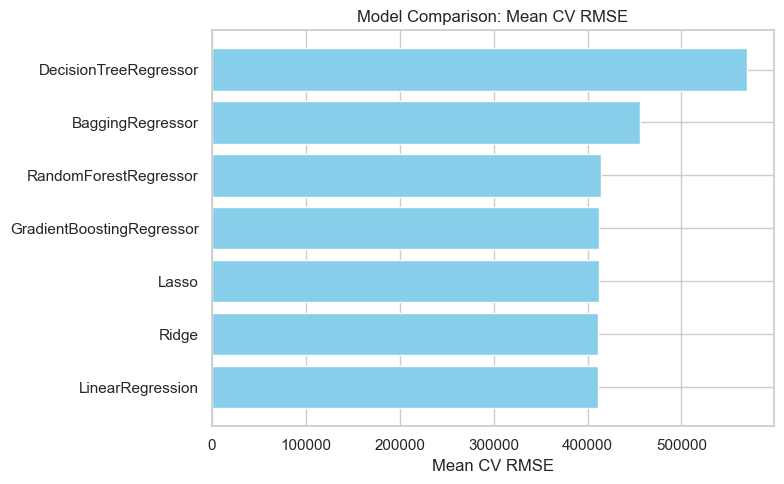

In [ ]:
plot_df = final_results.sort_values('mean_CV_RMSE')

plt.figure(figsize=(8, 5))
plt.barh(plot_df['model'], plot_df['mean_CV_RMSE'], color='skyblue')

plt.xlabel('Mean CV RMSE')
plt.title('Model Comparison: Mean CV RMSE')
plt.tight_layout()
plt.show()

### Part 3: Discussion [2 pts]

Analyze the effect of feature selection on your models:

- Did performance improve for any models after reducing the number of features?

- Which features were consistently retained across models?

- Were any of your newly engineered features selected as important?

- How did feature selection differ between linear and tree-based models?

**Did performance improve for any models after reducing the number of features?**

Linear Models (LinearRegression, Ridge, Lasso) get better performance with lower MSE

**Which features were consistently retained across models?**

The following features showed up in almost every model, These features were likely robust to model-specific biases, indicating their relevance to the target variable

bathroomcnt, bedroomcnt, fullbathcnt, roomcnt, unitcnt;lotsizesquarefeet, calculatedfinishedsquarefeet, calculatedfinishedsquarefeet_squared;propertyage, propertyage_log,yearbuilt_decade_log;bedroomcnt_by_bathroomcnt, hasgarage_flag_by_bedroomcnt;hasairconditioning_flag, storageshed_flag;building_label_building_quality_type_id_7, 8, 9, 10, 11;landuse_Planned_Unit_Development, landuse_Quadruplex, landuse_Single_Family_Residential;county_name_Orange County


**Were any of your newly engineered features selected as important?**

bedroomcnt_by_bathroomcnt,propertyage_log,yearbuilt_decade_log,hasgarage_flag_by_bedroomcnt are newly engineered features are selected in all models

**How did feature selection differ between linear and tree-based models?**
Linear Models (LinearRegression, Ridge, Lasso):Tend to select more raw and interpretable features, such as bedroomcnt, unitcnt, yearbuilt_decade, etc.Avoid highly correlated variables unless regularization justifies their inclusion (e.g., Ridge vs. Lasso differences).Favor fewer categorical dummy variables, likely to prevent multicollinearity.

Tree-Based Models (DecisionTree, Bagging, RandomForest, GradientBoosting):
Select more engineered and interaction-based features like:propertyage_by_calculatedfinishedsquarefeet.calculatedfinishedsquarefeet_squaredAre more flexible with high-cardinality categorical features (building_label_building_quality_type_id_*)Tend to retain more features overall, especially ensemble methods like RandomForest and Bagging.

Tree models are naturally better at handling non-linear relationships and feature interactions, so they tend to select more complex or derived features.

_____

### Part 4: Fine-Tuning Your Top 3 Models [6 pts]

In this final phase of Milestone 2, you’ll select and refine your **three most promising models and their corresponding data pipelines** based on everything you've done so far.

1. Choose the top 3 models based on performance and interpretability from earlier parts.
2. For each model:
   - Perform hyperparameter tuning using `sweep_parameters`, `GridSearchCV`, `RandomizedSearchCV`, or other techniques from previous homeworks. 
   - Experiment with different versions of your feature engineering and preprocessing — treat these as additional tunable components.
3. Report the mean and standard deviation of CV RMSE score for each model in a summary table.



#### **Part 4 Prelude: Define Functions**

In [ ]:
def run_model_for_sweep(model, X_train, y_train, X_test, y_test, n_repeats=10, n_jobs=-1, **model_params):

    # Instantiate the model if a class is provided, so for example can use either BaggingRegressor or BaggingRegressor() as argument. 
    if isinstance(model, type):
        model = model(**model_params)

    neg_mse_scores = cross_val_score(model, X_train, y_train,scoring = 'neg_mean_squared_error',
                                     cv = RepeatedKFold(n_splits=5, n_repeats=n_repeats, random_state=42), n_jobs  = n_jobs)
    
    mean_cv_mse = -np.mean(neg_mse_scores)
    std_cv_mse  = np.std(neg_mse_scores)
    
    # Fit the model on the full training set
    model.fit(X_train, y_train)
    
    # Compute training MSE and testing MSE
    train_preds = model.predict(X_train)
    train_mse   = mean_squared_error(y_train, train_preds)
    test_preds  = model.predict(X_test)
    test_mse    = mean_squared_error(y_test, test_preds)
    
    return mean_cv_mse, std_cv_mse, train_mse, test_mse

In [ ]:
def sweep_parameter(model,
                    Parameters,
                    param,
                    parameter_list,
                    X_train          = None,
                    y_train          = None,
                    X_test           = None,
                    y_test           = None,
                    verbose          = True,
                    show_rmse        = True,
                    n_iter_no_change = None,
                    delta            = 0.001,
                    n_jobs           = -1,
                    n_repeats        = 10):
    
    start = time.time()
    Parameters = Parameters.copy()  # Avoid modifying the original dictionary
    
    cv_mses, std_cvs, train_mses, test_mses = [], [], [], []
    no_improve_count = 0
    best_mse = float('inf')
    
    # Run over each value in parameter_list
    for p in tqdm(parameter_list, desc=f"Sweeping {param}"):
        Parameters[param] = p
        P_temp = Parameters.copy()
        # Remove MSE_found if present, just in case
        P_temp.pop('MSE_found', None)
        
        cv_mse, std_cv, train_mse, test_mse = run_model_for_sweep(
            model=model,
            X_train=X_train, y_train=y_train,
            X_test=X_test,   y_test=y_test,
            n_repeats=n_repeats,
            n_jobs=n_jobs,
            **P_temp
        )
        cv_mses.append(cv_mse)
        std_cvs.append(std_cv)
        train_mses.append(train_mse)
        test_mses.append(test_mse)
        
        # Early-stopping logic
        if cv_mse < best_mse - delta:
            best_mse = cv_mse
            no_improve_count = 0
        else:
            no_improve_count += 1
        
        if n_iter_no_change is not None and no_improve_count >= n_iter_no_change:
            print(f"Early stopping: No improvement after {n_iter_no_change} iterations.")
            break
    
    # Identify best parameter
    min_cv_mse = min(cv_mses)
    min_index = cv_mses.index(min_cv_mse)
    best_param = parameter_list[min_index]
    Parameters[param] = best_param
    Parameters['MSE_found'] = min_cv_mse
    
    if verbose:
        # Prepare for plotting
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)
        
        # We only need as many parameter values as we actually computed
        partial_param_list = parameter_list[:len(cv_mses)]
        
        # Check if our parameter list is Boolean so we can label accordingly
        is_boolean = all(isinstance(val, bool) for val in partial_param_list)
        if is_boolean:
            # Convert booleans to integer indices for plotting
            x_vals = list(range(len(partial_param_list)))
            x_labels = [str(val) for val in partial_param_list]
        else:
            # Treat numeric or other types as-is
            x_vals = partial_param_list
            x_labels = partial_param_list
        
        error_name = 'RMSE' if show_rmse else 'MSE'
        
        # ----- First plot: (R)MSE -----
        ax1.set_title(f"{error_name} vs {param}")
        
        # Apply dollar formatting ONLY if we're showing RMSE
        if show_rmse:
            ax1.yaxis.set_major_formatter(mticker.FuncFormatter(dollar_format))
        
        # Plot lines
        ax1.plot(x_vals,
                 np.sqrt(cv_mses) if show_rmse else cv_mses,
                 marker='.', label=f"CV {error_name}", color='blue')
        ax1.plot(x_vals,
                 np.sqrt(train_mses) if show_rmse else train_mses,
                 marker='.', label=f"Train {error_name}", color='green')
        ax1.plot(x_vals,
                 np.sqrt(test_mses) if show_rmse else test_mses,
                 linestyle='--', label=f"Test {error_name}", color='orange')
        ax1.scatter([x_vals[min_index]],
                    [np.sqrt(min_cv_mse) if show_rmse else min_cv_mse],
                    marker='x', label=f"Best CV {error_name}", color='red')
        
        ax1.set_ylabel(error_name)
        ax1.legend()
        ax1.grid()
        
        # ----- Second plot: CV Std Dev -----
        ax2.set_title(f"CV Standard Deviation vs {param}")
        ax2.plot(x_vals, std_cvs, marker='.', label=f"CV {error_name} Std", color='blue')
        ax2.set_xlabel(param)
        ax2.set_ylabel("Standard Deviation")
        ax2.legend()
        # ax2.set_ylim(0, 1e8) # < Added
        ax2.grid(alpha=0.5)
        
        # If we are using boolean x-values, set custom ticks
        if is_boolean:
            ax2.set_xticks(x_vals)
            ax2.set_xticklabels(x_labels)
        
        plt.tight_layout()
        plt.show()
        
        end = time.time()
        print("Execution Time:", time.strftime("%H:%M:%S", time.gmtime(end - start)))
    
    return Parameters


In [ ]:
def part4_plot(df, title="Training vs CV RMSE", figsize=(14, 8)):
    # Reshape from wide to long for grouped bar plot
    plot_df = df[['run_comment', 'mean_CV_RMSE', 'training_RMSE']].copy()
    melted = plot_df.melt(id_vars='run_comment', var_name='RMSE_Type', value_name='RMSE_Value')

    # Plot setup
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=figsize)

    barplot = sns.barplot(
        data=melted,
        x='run_comment',
        y='RMSE_Value',
        hue='RMSE_Type',
        # palette='Paired'
    )

    # Add value labels on top of bars
    for bar in barplot.patches:
        height = bar.get_height()
        if not pd.isna(height):
            barplot.text(
                bar.get_x() + bar.get_width() / 2,
                height + 5000,
                f"${height:,.0f}",
                ha='center',
                va='bottom',
                fontsize=9
            )

    # Format y-axis as dollars
    barplot.yaxis.set_major_formatter(mticker.FuncFormatter(dollar_format))

    # Style the plot
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel("Model / Run", fontsize=12)
    plt.ylabel("RMSE", fontsize=9)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.ylim(0, 500_000)
    plt.legend(title="")
    plt.show()

**Part 4 Prelude: Checking 3 top performing models**

In [ ]:
combined_results_part4 = combined_results.copy()
feature_selection_concat_results = final_results[['model', 'model_params', 'mean_CV_RMSE', 'std_CV_RMSE', 'training_RMSE', 'run_comment']]

combined_results_part4 = pd.concat([combined_results, feature_selection_concat_results], ignore_index=True)

#### **From Part 1: A list of 'most influencial' parameters was made for each of the models tested throughout this project.**

This list will be used to perform parameter sweeps for each of the top performing models. 

In [ ]:
# Default Parameter Dictionaries

Default_Parameters_LinearRegression = {
    'fit_intercept': True,    # Top 2
    'positive': False,        # Top 2
    'MSE_found': float('inf') # For tracking best MSE
}

Default_Parameters_Ridge = {
    'alpha': 1.0,             # Top 3
    'fit_intercept': True,    # Top 3
    'solver': 'auto',         # Top 3
    'max_iter': 1000,         # Increase if convergence warning appears
    'tol': 0.001,
    'random_state': 42,
    'MSE_found': float('inf')
}

Default_Parameters_Lasso = {
    'alpha': 1.0,             # Top 2
    'fit_intercept': True,    # Top 2
    'max_iter': 1000,         # Increase to avoid convergence warning
    'tol': 0.0001,
    'warm_start': False,
    'positive': False,
    'random_state': 42,       # For reproducibility
    'MSE_found': float('inf')
}

Default_Parameters_DecisionTree = {
    'max_depth': None,                 # Top 4
    'min_samples_split': 2,            # Top 4
    'max_features': None,              # Top 4
    'max_leaf_nodes': None,            # Top 4
    'criterion': 'squared_error',
    'splitter': 'best',
    'min_samples_leaf': 1,
    'min_weight_fraction_leaf': 0.0,
    'min_impurity_decrease': 0.0,
    'ccp_alpha': 0.0,
    'random_state': 42,
    'MSE_found': float('inf')
}

Default_Parameters_Bagging = {
    'n_estimators': 10,                # Top 4
    'max_samples': 1.0,                # Top 4
    'max_features': 1.0,               # Top 4
    'bootstrap': True,                 # Top 4
    'oob_score': False,
    'bootstrap_features': False,
    'random_state': 42,
    'MSE_found': float('inf')
}

Default_Parameters_RandomForest = {
    'n_estimators': 100,              # Top 4
    'max_features': None,             # Top 4
    'max_depth': None,                # Top 4
    'bootstrap': True,                # Top 4
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'oob_score': False,
    'criterion': 'squared_error',
    'random_state': 42,
    'MSE_found': float('inf')
}

Default_Parameters_GradientBoosting = {
    'learning_rate': 0.1,             # Top 4
    'n_estimators': 100,              # Top 4
    'max_depth': 3,                   # Top 4
    'max_features': None,             # Top 4
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'max_leaf_nodes': None,
    'subsample': 1.0,
    'loss': 'squared_error',
    'random_state': 42,
    'MSE_found': float('inf')
}

### **Part 4.1 -- Top Results from Previous Sections**

Several factors were considered when selecting the top-performing models to carry forward into Part 4. While the primary criterion was the mean CV RMSE, the model family was also taken into account.

Linear Regression, Ridge, and Lasso are all part of the linear model family, differing primarily in their regularization techniques but sharing the fundamental assumption of a linear relationship between features and the target. In contrast, ensemble methods such as Gradient Boosted Trees and Random Forests are capable of capturing more complex, nonlinear relationships. Including both model families allows for a more comprehensive evaluation and helps determine whether additional predictive power can be gained from nonlinear approaches.

Selected Models for Part 4:

- 1.	GradientBoostingRegressor - RMSE: 407,865 - Feature Set: Full feature set from 2.2 (no log transformations)
- 2.	RandomForestRegressor - RMSE: 410,885 - Feature Set: Full feature set from 2.2 (no log transformations)
- 3.	LinearRegression - RMSE: 411,250 - Feature Set: Final feature selection from Part 3

For each of these models, a parameter sweep followed by GridSearchCV will be performed to identify optimal hyperparameters. Each optimized model will then be evaluated across three configurations:

- 1.	its associated feature selection set,
- 2.	a log-transformed feature set, and
- 3.	the base 2.2 feature set without log transformations.

In [ ]:
ranked_results = combined_results_part4.sort_values(by='mean_CV_RMSE', ascending=True).reset_index()
ranked_results.head(5) 

index                      model  \
0     21  GradientBoostingRegressor   
1     20  GradientBoostingRegressor   
2     19      RandomForestRegressor   
3     27           LinearRegression   
4     28                      Ridge   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                 model_params  \
0  {'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.09, 'loss': 'squared_error', 'max_depth': 5, 'max_features': 12, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 194, 'n_iter_no_change': None, 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}   
1   {'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': 42, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}   
2                                                              {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}   
3                                                                                                                                                                                                                                                                                                                                                                                                  {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}   
4                                                                                                                                                                                                                                                                                                                              {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'positive': False, 'random_state': 42, 'solver': 'auto', 'tol': 0.001}   

    mean_CV_RMSE   std_CV_RMSE  training_RMSE      test_RMSE  \
0  402691.479775  35183.616307  317601.001018            NaN   
1  407971.165349  36461.433675  365875.465125  366653.129724   
2  410872.953949  34683.618148  153147.700111  373503.510984   
3  411237.680017  37334.260560  411888.104579            NaN   
4  411525.950273  37275.310043  412178.025168            NaN   

                             run_comment  
0                 GBT Fine-Tuning No Log  
1  Part 2.2 No target log transformation  
2  Part 2.2 No target log transformation  
3     Final CV with selected features #2  
4     Final CV with selected features #2

In [ ]:
# Part 4: Fine-tuning:
fine_tuning_df = feature_selection_df.copy()
fine_tuning_df

bathroomcnt  bedroomcnt  calculatedfinishedsquarefeet  fullbathcnt  \
0              3.5         4.0                        3100.0          3.0   
1              1.0         2.0                        1465.0          1.0   
2              2.0         3.0                        1243.0          2.0   
3              3.0         4.0                        2376.0          3.0   
4              2.0         3.0                        1492.0          2.0   
...            ...         ...                           ...          ...   
56264          2.0         3.0                        1570.0          2.0   
56265          2.0         4.0                        1633.0          2.0   
56266          2.0         4.0                        1612.0          2.0   
56267          1.0         3.0                        1032.0          1.0   
56268          2.0         3.0                        1762.0          2.0   

       lotsizesquarefeet  roomcnt  unitcnt  taxvaluedollarcnt  propertyage  \
0                 4506.0      0.0      1.0          1023282.0         18.0   
1                12647.0      5.0      1.0           464000.0         49.0   
2                 8432.0      6.0      1.0           564778.0         54.0   
3                13038.0      0.0      1.0           145143.0         46.0   
4                  903.0      6.0      1.0           331064.0         34.0   
...                  ...      ...      ...                ...          ...   
56264             7499.0      0.0      1.0            72026.0         58.0   
56265             4630.0      0.0      1.0           346534.0         54.0   
56266            12105.0      7.0      1.0            67205.0         52.0   
56267             5074.0      0.0      1.0            49546.0         62.0   
56268             6347.0      0.0      1.0           522000.0         61.0   

       yearbuilt_decade  ...  propertyage_by_calculatedfinishedsquarefeet  \
0                1990.0  ...                                      55800.0   
1                1960.0  ...                                      71785.0   
2                1960.0  ...                                      67122.0   
3                1970.0  ...                                     109296.0   
4                1980.0  ...                                      50728.0   
...                 ...  ...                                          ...   
56264            1950.0  ...                                      91060.0   
56265            1960.0  ...                                      88182.0   
56266            1960.0  ...                                      83824.0   
56267            1950.0  ...                                      63984.0   
56268            1950.0  ...                                     107482.0   

       hasgarage_flag_by_bedroomcnt  propertyage_log  yearbuilt_decade_log  \
0                               4.0         2.944439              7.596392   
1                               2.0         3.912023              7.581210   
2                               3.0         4.007333              7.581210   
3                               0.0         3.850148              7.586296   
4                               3.0         3.555348              7.591357   
...                             ...              ...                   ...   
56264                           0.0         4.077537              7.576097   
56265                           0.0         4.007333              7.581210   
56266                           4.0         3.970292              7.581210   
56267                           0.0         4.143135              7.576097   
56268                           0.0         4.127134              7.576097   

       calculatedfinishedsquarefeet_log  \
0                              8.039480   
1                              7.290293   
2                              7.126087   
3                              7.773594   
4                              7.308543   
...                      

### **Top Model Parameter Sweep / GridSearchCV: Gradient Boosted Trees**

#### **Top Parameter Selection and Feature Standardization**

In [ ]:
Parameters_GBT = Default_Parameters_GradientBoosting.copy()
Parameters_GBT_List = []

fine_tuning_df_standardized = standardize_features(fine_tuning_df)
GBT_X_train, GBT_X_test, GBT_y_train, GBT_y_test = train_test_split_data(fine_tuning_df, 'taxvaluedollarcnt')
GBT_X_train_standardized = standardize_features(GBT_X_train)

#### **Gradient Boosted Regressor: Parameter Sweep**

Sweeping learning_rate: 100%|██████████| 5/5 [01:11<00:00, 14.29s/it]


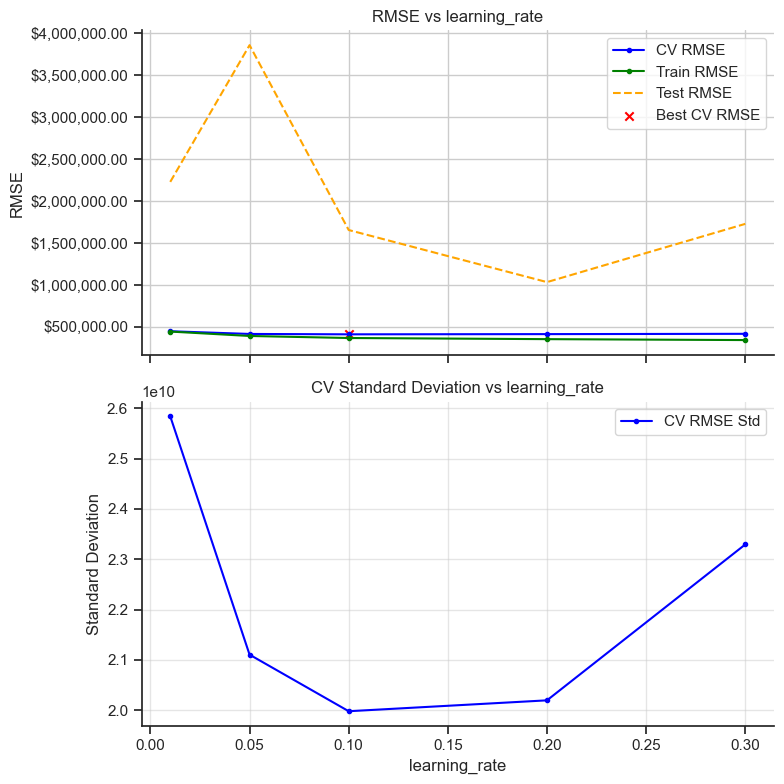

Execution Time: 00:01:11

 Parameter learning_rate = 0.1    RMSE = $409,661.20

{'learning_rate': 0.1, 'n_estimators': 100, 'max_depth': 3, 'max_features': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_leaf_nodes': None, 'subsample': 1.0, 'loss': 'squared_error', 'random_state': 42, 'MSE_found': np.float64(167822302142.53058)}



Sweeping n_estimators: 100%|██████████| 4/4 [02:19<00:00, 34.80s/it]


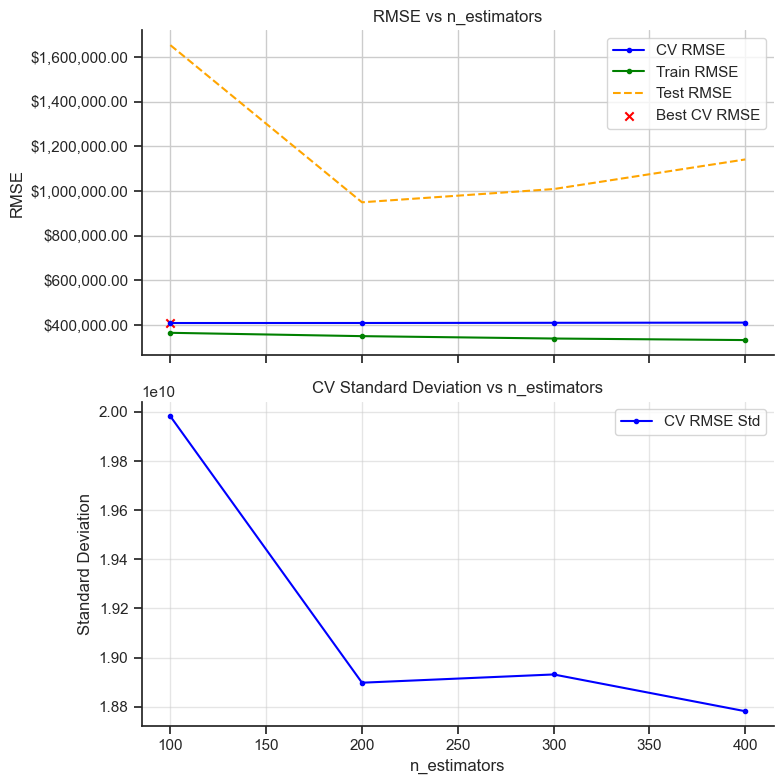

Execution Time: 00:02:19

 Parameter n_estimators = 100    RMSE = $409,661.20

{'learning_rate': 0.1, 'n_estimators': 100, 'max_depth': 3, 'max_features': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_leaf_nodes': None, 'subsample': 1.0, 'loss': 'squared_error', 'random_state': 42, 'MSE_found': np.float64(167822302142.53058)}



Sweeping max_depth: 100%|██████████| 4/4 [04:35<00:00, 68.75s/it]


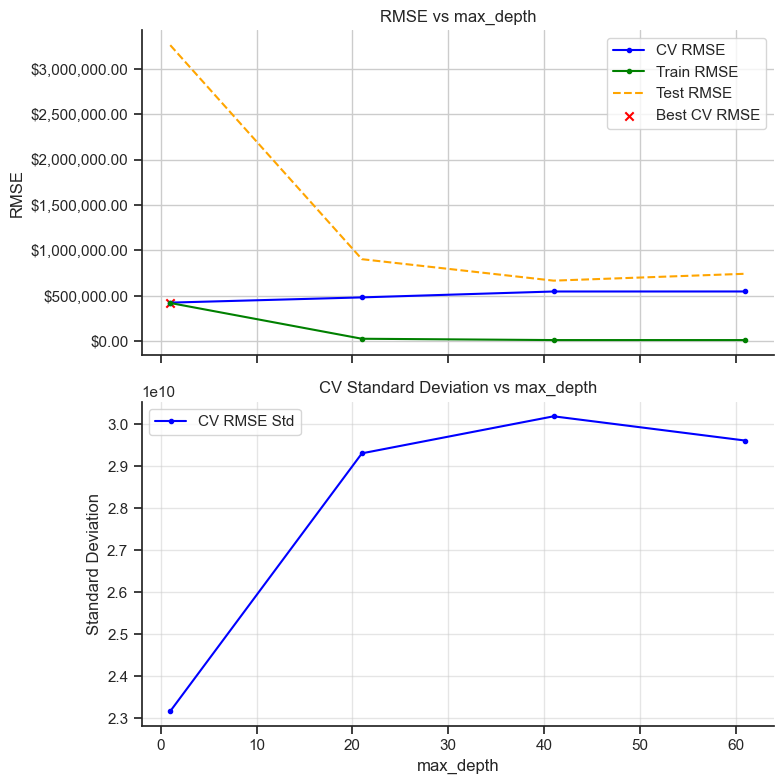

Execution Time: 00:04:35

 Parameter max_depth = 1    RMSE = $425,316.53

{'learning_rate': 0.1, 'n_estimators': 100, 'max_depth': 1, 'max_features': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_leaf_nodes': None, 'subsample': 1.0, 'loss': 'squared_error', 'random_state': 42, 'MSE_found': np.float64(180894150289.6541)}



Sweeping max_features: 100%|██████████| 12/12 [00:31<00:00,  2.65s/it]


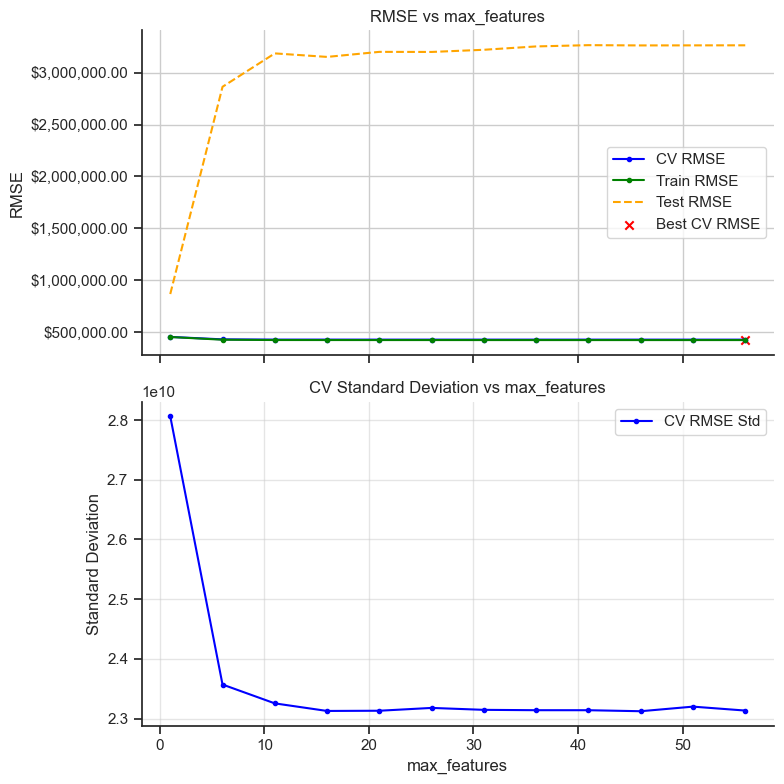

Execution Time: 00:00:31

 Parameter max_features = 56    RMSE = $425,317.22

{'learning_rate': 0.1, 'n_estimators': 100, 'max_depth': 1, 'max_features': 56, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_leaf_nodes': None, 'subsample': 1.0, 'loss': 'squared_error', 'random_state': 42, 'MSE_found': np.float64(180894734500.83682)}



learning_rate  n_estimators  max_depth  max_features  min_samples_split  \
0            0.1           100          1            56                  2   

   min_samples_leaf max_leaf_nodes  subsample           loss  random_state  \
0                 1           None        1.0  squared_error            42   

      MSE_found  
0  1.808947e+11

In [ ]:
# Your code here -- Add as many code cells as necessary

start = time.time()

parameters_and_ranges = [
    ('learning_rate', [0.01, 0.05, 0.1, 0.2, 0.3]),        # Shrinks the contribution of each tree. Affects the speed of learning and overfitting.
    ('n_estimators', range(100, 500, 100)),                # The number of boosting stages to be run. More estimators can improve performance but increase training time.
    ('max_depth',   range(1,80, 20)),                      # Maximum depth of individual trees. Controls model complexity.
    ('max_features', range(1, 60, 5))                      # Number of features to consider when looking for best split. Can help reduce overfitting.
]

for param, parameter_list in parameters_and_ranges:
    Parameters_GBT = sweep_parameter(
        GradientBoostingRegressor,
        Parameters_GBT,
        param,
        parameter_list,
        X_train=GBT_X_train_standardized,
        y_train=GBT_y_train,
        X_test=GBT_X_test,
        y_test=GBT_y_test,
        n_jobs=-1,
        n_repeats=2
    )

    print(f"\n Parameter {param} = {Parameters_GBT[param]}    RMSE = ${Parameters_GBT['MSE_found']**0.5:,.2f}\n")
    print(Parameters_GBT)
    print()

Parameters_GBT_List.append(Parameters_GBT)
GBT_Results = pd.DataFrame(Parameters_GBT_List)
GBT_Results.to_csv("data_cache/GBT_Results", index=False)
GBT_Results


#### **Gradient Boosting Trees GridSearchCV**

Note: Because the Final GridSearch can take hours to complete -- The results are cached for collaboration and then re-loaded if present

In [ ]:
# Filenames for cached outputs
result_csv = "data_cache/GBT_gridsearch_results.csv"
summary_csv = "data_cache/GBT_summary.csv"

# Check if the results already exist
if os.path.exists(result_csv) and os.path.exists(summary_csv):
    print("Loading cached GridSearchCV results...")

    renamed_results = pd.read_csv(result_csv)
    GBT_summary_df = pd.read_csv(summary_csv)

    best_cv_rmse = GBT_summary_df["Best CV RMSE"].values[0]
    best_params = eval(GBT_summary_df["Best Parameters"].values[0])  # Convert string back to dict if needed

else:
    print("Running GridSearchCV...")

    start = time.time()

    GradTree = GradientBoostingRegressor(random_state=42)

    param_dist = {
        'learning_rate': np.linspace(0.09, 0.14, 5),  
        'n_estimators': range(194, 201),
        'max_depth': range(4, 6),
        'max_features': range(12, 20)
    }

    rcv = RepeatedKFold(n_repeats=5, random_state=42)

    search = GridSearchCV(
        estimator=GradTree,
        param_grid=param_dist,
        scoring='neg_mean_squared_error',
        cv=rcv,
        n_jobs=-1,
        return_train_score=True
    )

    search.fit(GBT_X_train, GBT_y_train)  

    results = pd.DataFrame(search.cv_results_)

    results = results[[
        'param_n_estimators', 'param_max_features', 'param_max_depth',
        'mean_test_score', 'std_test_score', 'mean_train_score', 'std_train_score', 'rank_test_score'
    ]]

    results['mean_test_score'] = -results['mean_test_score']
    results['mean_train_score'] = -results['mean_train_score']
    results = results.sort_values(by='rank_test_score')

    renamed_results = results.rename(columns={
        'param_n_estimators': 'n_estimators',
        'param_max_features': 'max_features',
        'param_max_depth': 'max_depth',
        'mean_test_score': 'mean_cv_score',
        'std_test_score': 'std_cv_score',
        'mean_train_score': 'mean_train_score',
        'std_train_score': 'std_train_score'
    }).drop(columns=['rank_test_score'])

    best_params = search.best_params_
    best_cv_mse = -search.best_score_
    best_cv_rmse = np.sqrt(best_cv_mse)
    best_cv_std = renamed_results.loc[renamed_results['mean_cv_score'] == best_cv_mse, 'std_cv_score'].values[0]

    GBT_summary_df = pd.DataFrame({
        "Best Parameters": [str(best_params)],
        "Best CV RMSE": [best_cv_rmse],
        "Std Dev of Best CV MSE": [best_cv_std]
    })

    end = time.time()
    execution_time = time.strftime('%H:%M:%S', time.gmtime(end - start))
    print(f"Execution Time: {execution_time}")

    # Save to CSV
    renamed_results.to_csv(result_csv, index=False)
    GBT_summary_df.to_csv(summary_csv, index=False)

# Print summary
print("\nSearch Results (Top 5) Scaled & Standardized:\n")
print(renamed_results.head(5).to_string(index=False))
print(f"\nBest Parameters: {best_params}")
print(f"Best Scaled & Standardized CV RMSE: {best_cv_rmse:,.2f}")

Loading cached GridSearchCV results...

Search Results (Top 5) Scaled & Standardized:

 n_estimators  max_features  max_depth  standardized_mean_cv_score  standardized_std_cv_score  standardized_mean_train_score  standardized_std_train_score
          194            12          5                    0.602738                   0.110634                       0.362729                      0.005464
          195            12          5                    0.602815                   0.110517                       0.362266                      0.005406
          196            12          5                    0.602855                   0.110513                       0.361843                      0.005466
          197            12          5                    0.602890                   0.110561                       0.361489                      0.005443
          199            12          5                    0.602973                   0.110628                       0.360609              

#### **Boosted Trees Model Run Tests with Best Parameters**

In [ ]:
final_results[final_results['model'].str.contains("GradientBoostingRegressor")]

model  \
6  GradientBoostingRegressor   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                model_params  \
6  {'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': 42, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}   

    mean_CV_RMSE   std_CV_RMSE  training_RMSE test_RMSE  \
6  412561.380793  34902.354351  370917.487212      None   

                       run_comment  Selected_Feature_Count  \
6  Final CV with selected features                      18   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  Selected_Features  
6  ['calculatedfinishedsquarefeet', 'calculatedfinishedsquarefeet_squared', 'bathroomcnt', 'calculatedfinishedsquarefeet_log', 'propertyage_by_calculatedfinishedsquarefeet', 'building_label_building_quality_type_id_9', 'lotsizesquarefeet', 'building_label_building_quality_type_id_11', 'unitcnt', 'landuse_Single_Family_Residential', 'building_label_building_quality_type_id_10', 'propertyage', 'heating_label_heating_or_system_type_solar', 'propertyage_log', 'fullbathcnt', 'building_label_building_quality_type_id_7', 'bedroomcnt', 'building_label_building_quality_type_id_12']

In [ ]:
# Logged DataSet (Standardized in Part 2)
feature_engineering_X_train_log, feature_engineering_X_test_log, feature_engineering_y_train_log, feature_engineering_y_test_log = train_test_split_data(feature_engineering_df_log, 'taxvaluedollarcnt_log')
scaled_feature_engineering_x_train_log = standardize_features(feature_engineering_X_train_log)

# Unlogged DataSet (Standardized in Part 2))
feature_engineering_X_train_no_log, feature_engineering_X_test_no_log, feature_engineering_y_train_no_log, feature_engineering_y_test_no_log = train_test_split_data(feature_engineering_df_no_log, 'taxvaluedollarcnt')
scaled_feature_engineering_x_train_no_log = standardize_features(feature_engineering_X_train_no_log)


# Best Feature Set Gradient Boosted Trees - (From Unlogged Version)
GBT_Best_Features = feature_engineering_df_no_log[['calculatedfinishedsquarefeet', 'calculatedfinishedsquarefeet_squared', 'bathroomcnt', 'propertyage_by_calculatedfinishedsquarefeet', 'building_label_building_quality_type_id_9', 'lotsizesquarefeet', 'unitcnt', 'building_label_building_quality_type_id_11', 'landuse_Single_Family_Residential', 'building_label_building_quality_type_id_10', 'propertyage', 'propertyage_log', 'heating_label_heating_or_system_type_solar', 'fullbathcnt', 'bedroomcnt', 'building_label_building_quality_type_id_7', 'taxvaluedollarcnt']]
GBT_Best_Features_X_train, GBT_Best_Features_X_test, GBT_Best_Features_y_train, GBT_Best_Features_y_test = train_test_split_data(GBT_Best_Features, 'taxvaluedollarcnt')
scaled_GBT_Best_Features_X_train = standardize_features(GBT_Best_Features_X_train)

In [ ]:
GBT_summary_df['Best Parameters']

0    {'learning_rate': np.float64(0.09), 'max_depth': 5, 'max_features': 12, 'n_estimators': 194}
Name: Best Parameters, dtype: object

In [ ]:
GBT_best_params = {
  'learning_rate': np.float64(0.09),
  'max_depth': 5, 
  'max_features': 12, 
  'n_estimators': 194
  }

**Base Feature Engineering (No Log)**

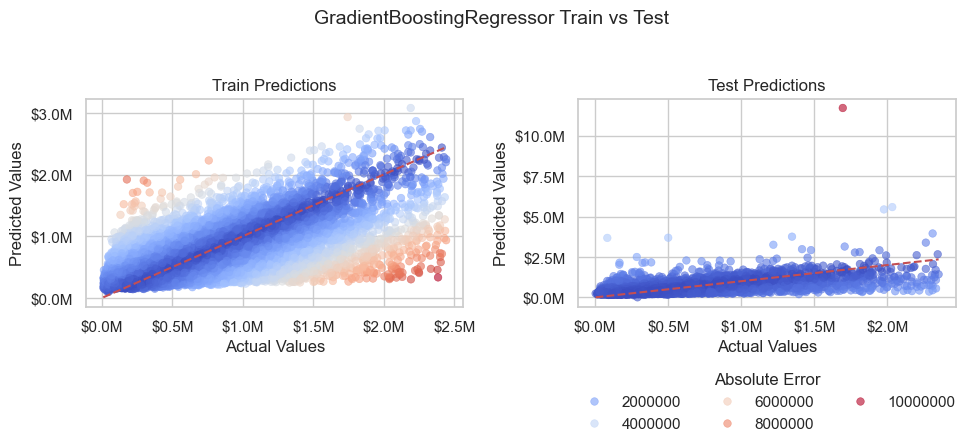

model  \
0  GradientBoostingRegressor   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                 model_params  \
0  {'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.09, 'loss': 'squared_error', 'max_depth': 5, 'max_features': 12, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 194, 'n_iter_no_change': None, 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}   

    mean_CV_RMSE   std_CV_RMSE  training_RMSE      test_RMSE  \
0  402019.306084  36262.850673  322254.617799  372784.243634   

                    run_comment  
0  GBT Fine-Tuning No Log Final

In [ ]:
run_model(
          model=GradientBoostingRegressor,
          X_train=feature_engineering_X_train_no_log,
          y_train=feature_engineering_y_train_no_log,
          X_test=feature_engineering_X_test_no_log,
          y_test=feature_engineering_y_test_no_log,
          n_repeats=5,
          n_jobs=-1, 
          concat_results=True,
          run_comment="GBT Fine-Tuning No Log Final", 
          target_is_logged=False,
          plot_pred=True, 
          **GBT_best_params
          )

**Base Feature Engineering (Log)**

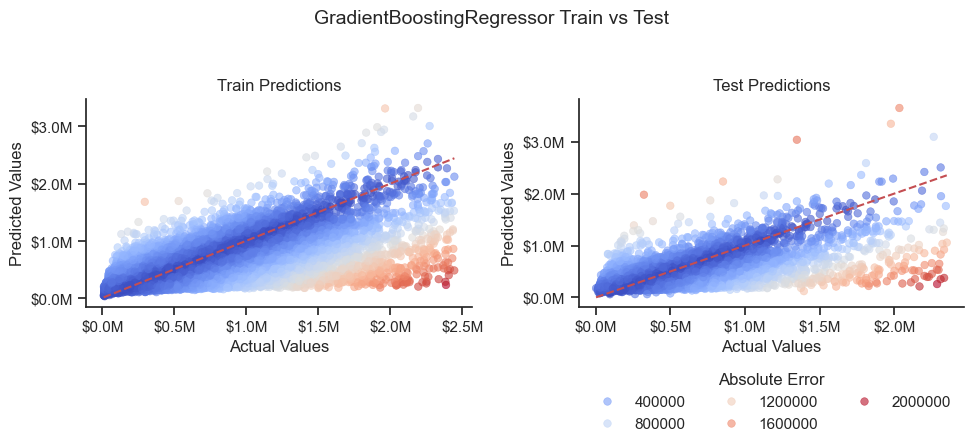

model  \
0  GradientBoostingRegressor   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                 model_params  \
0  {'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.09, 'loss': 'squared_error', 'max_depth': 5, 'max_features': 12, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 194, 'n_iter_no_change': None, 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}   

    mean_CV_RMSE   std_CV_RMSE  training_RMSE      test_RMSE  \
0  414607.576164  30975.579361  381203.856277  364241.739254   

           run_comment  
0  GBT Fine-Tuning Log

In [ ]:
run_model(
    model=GradientBoostingRegressor,
    X_train=feature_engineering_X_train_log,
    y_train=feature_engineering_y_train_log, 
    X_test=feature_engineering_X_test_log,
    y_test=feature_engineering_y_test_log,
    n_repeats=5,
    n_jobs=-1, 
    concat_results=True,
    run_comment="GBT Fine-Tuning Log", 
    target_is_logged=True,
    plot_pred=True, 
    **GBT_best_params
)

**With Feature Selection on No Log Dataset**

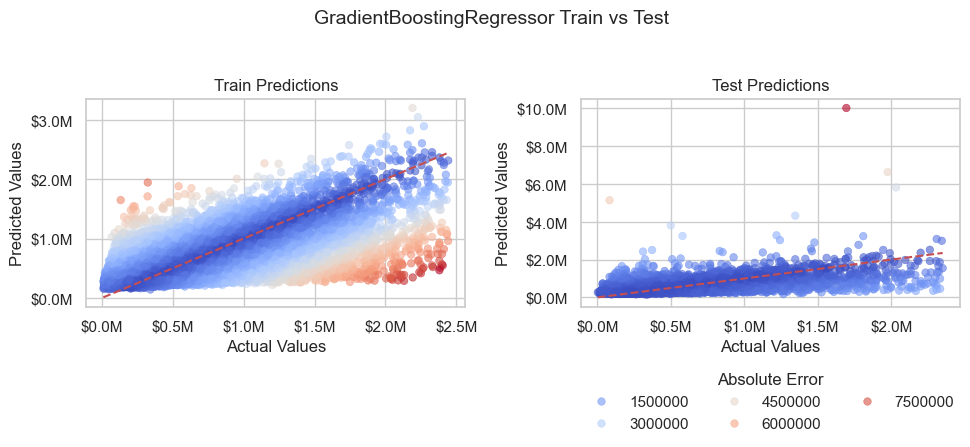

model  \
0  GradientBoostingRegressor   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                 model_params  \
0  {'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.09, 'loss': 'squared_error', 'max_depth': 5, 'max_features': 12, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 194, 'n_iter_no_change': None, 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}   

    mean_CV_RMSE  std_CV_RMSE  training_RMSE      test_RMSE  \
0  417900.849328    34151.431  315943.449395  374296.476511   

                         run_comment  
0  GBT Fine-Tuning Selected Features

In [ ]:
run_model(
          model=GradientBoostingRegressor,
          X_train=GBT_Best_Features_X_train,
          y_train=GBT_Best_Features_y_train,
          X_test=GBT_Best_Features_X_test,
          y_test=GBT_Best_Features_y_test,
          n_repeats=5,
          n_jobs=-1, 
          concat_results=True,
          run_comment="GBT Fine-Tuning Selected Features", 
          target_is_logged=False,
          plot_pred=True, 
          **GBT_best_params
          )

____

### **2nd Place Model: RandomForestRegressor**

In [ ]:
Parameters_RF = Default_Parameters_RandomForest.copy()
Parameters_RF_List = []

RF_X_train, RF_X_test, RF_y_train, RF_y_test = train_test_split_data(fine_tuning_df, 'taxvaluedollarcnt')
fine_tuning_X_standardized = standardize_features(RF_X_train)

Sweeping n_estimators: 100%|██████████| 4/4 [03:22<00:00, 50.71s/it]


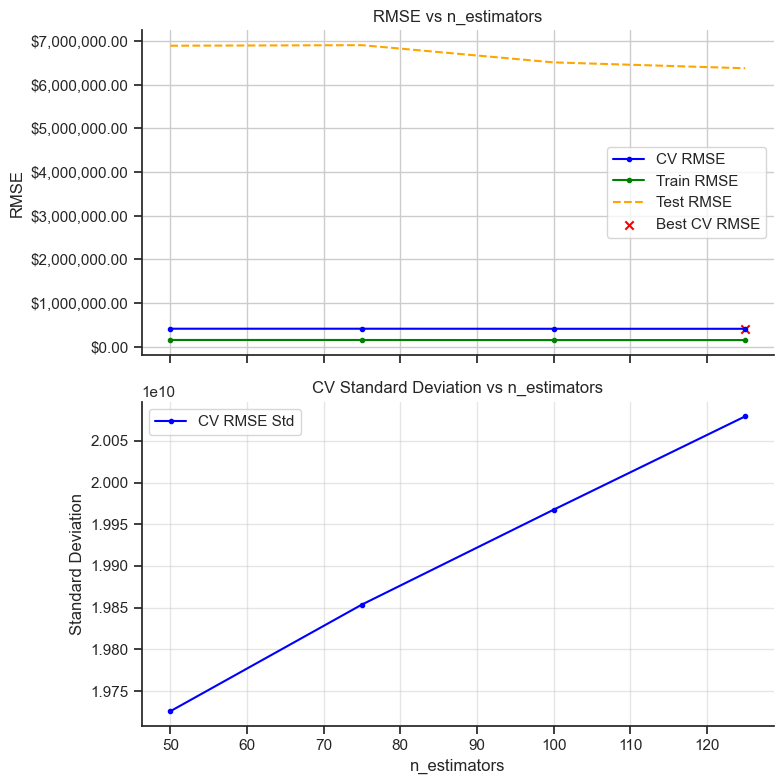

Execution Time: 00:03:22

 Refined Parameter n_estimators = 125    RMSE = $411,458.63

{'n_estimators': 125, 'max_features': None, 'max_depth': None, 'bootstrap': True, 'min_samples_split': 2, 'min_samples_leaf': 1, 'oob_score': False, 'criterion': 'squared_error', 'random_state': 42, 'MSE_found': np.float64(169298206438.45502)}



Sweeping max_features: 100%|██████████| 6/6 [03:14<00:00, 32.40s/it]


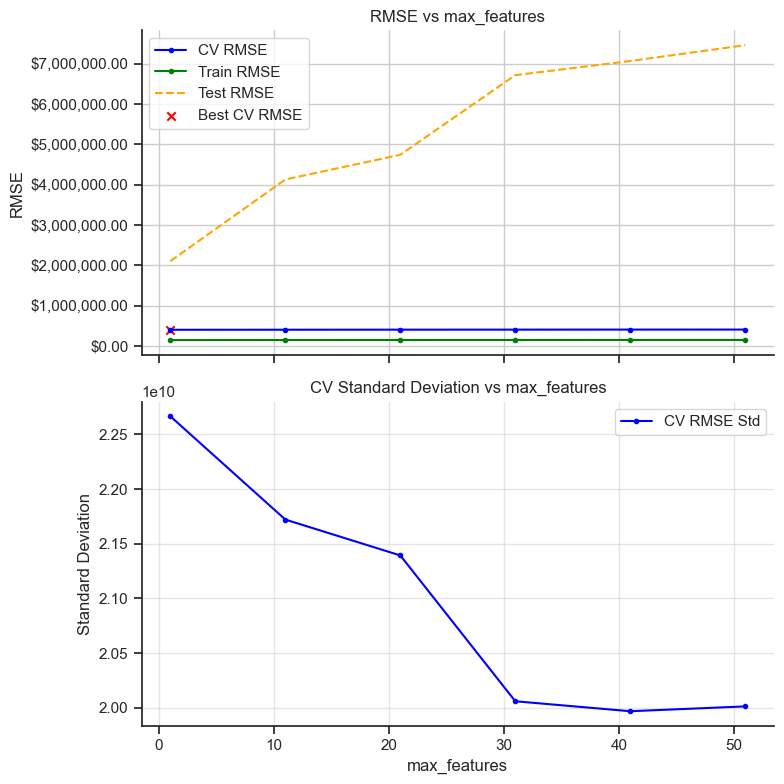

Execution Time: 00:03:14

 Refined Parameter max_features = 1    RMSE = $405,416.64

{'n_estimators': 125, 'max_features': 1, 'max_depth': None, 'bootstrap': True, 'min_samples_split': 2, 'min_samples_leaf': 1, 'oob_score': False, 'criterion': 'squared_error', 'random_state': 42, 'MSE_found': np.float64(164362651555.43878)}



Sweeping max_depth: 100%|██████████| 4/4 [00:23<00:00,  5.76s/it]


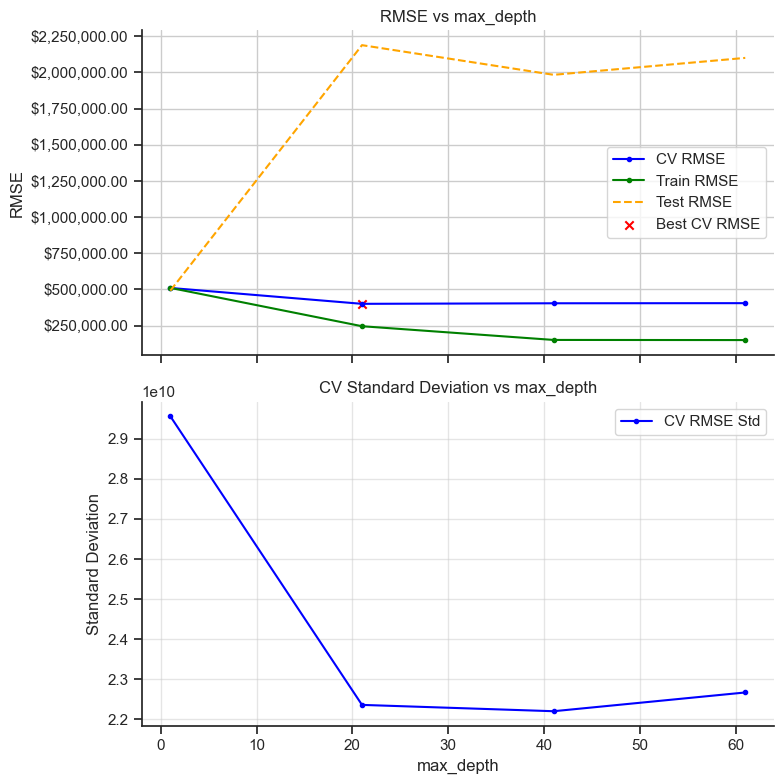

Execution Time: 00:00:23

 Refined Parameter max_depth = 21    RMSE = $400,779.79

{'n_estimators': 125, 'max_features': 1, 'max_depth': 21, 'bootstrap': True, 'min_samples_split': 2, 'min_samples_leaf': 1, 'oob_score': False, 'criterion': 'squared_error', 'random_state': 42, 'MSE_found': np.float64(160624440229.57755)}



Sweeping bootstrap: 100%|██████████| 2/2 [00:11<00:00,  5.86s/it]


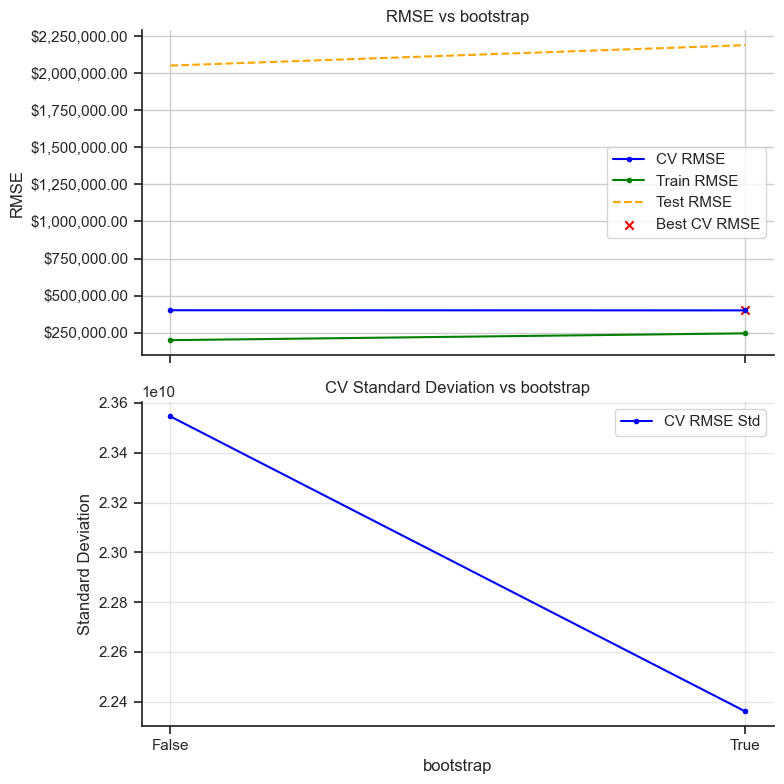

Execution Time: 00:00:11

 Refined Parameter bootstrap = True    RMSE = $400,779.79

{'n_estimators': 125, 'max_features': 1, 'max_depth': 21, 'bootstrap': True, 'min_samples_split': 2, 'min_samples_leaf': 1, 'oob_score': False, 'criterion': 'squared_error', 'random_state': 42, 'MSE_found': np.float64(160624440229.57755)}



n_estimators  max_features  max_depth  bootstrap  min_samples_split  \
0           125             1         21       True                  2   

   min_samples_leaf  oob_score      criterion  random_state     MSE_found  
0                 1      False  squared_error            42  1.606244e+11

In [ ]:
# Your code here -- Add as many code cells as necessary
# rf_model = RandomForestRegressor()
start = time.time()


parameters_and_ranges_refined = [
    ('n_estimators',  range(50, 150, 25)),                         
    ('max_features',  range(1, 60, 10)),                      
    ('max_depth',     range(1, 80, 20)),
    ('bootstrap',  [False, True])                      
]

Parameters_Refined = Parameters_RF.copy()

for param, parameter_list in parameters_and_ranges_refined:
    Parameters_Refined = sweep_parameter(
        RandomForestRegressor,
        Parameters_Refined,
        param,
        parameter_list,
        X_train=fine_tuning_X_standardized,
        y_train=RF_y_train,
        X_test=RF_X_test,
        y_test=RF_y_test,
        n_jobs=-1,
        n_repeats=2
    )

    RMSE_dollars = Parameters_Refined['MSE_found']**0.5

    print(f"\n Refined Parameter {param} = {Parameters_Refined[param]}    RMSE = ${RMSE_dollars:,.2f}\n")
    print(Parameters_Refined)
    print()

Parameters_RF_List.append(Parameters_Refined)
RF_sweep_params = pd.DataFrame(Parameters_RF_List)
RF_sweep_params




**Refined Parameter Search**

Sweeping n_estimators: 100%|██████████| 6/6 [04:47<00:00, 47.96s/it]


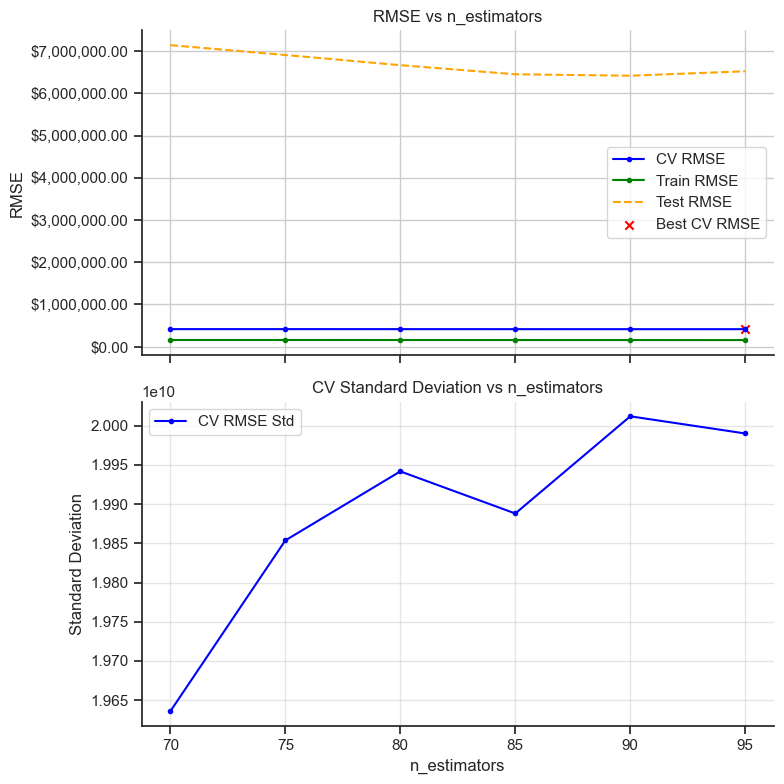

Execution Time: 00:04:47

 Refined Parameter n_estimators = 95    RMSE = $412,014.49

{'n_estimators': 95, 'max_features': None, 'max_depth': None, 'bootstrap': True, 'min_samples_split': 2, 'min_samples_leaf': 1, 'oob_score': False, 'criterion': 'squared_error', 'random_state': 42, 'MSE_found': np.float64(169755941336.82672)}



Sweeping max_features: 100%|██████████| 6/6 [02:38<00:00, 26.35s/it]


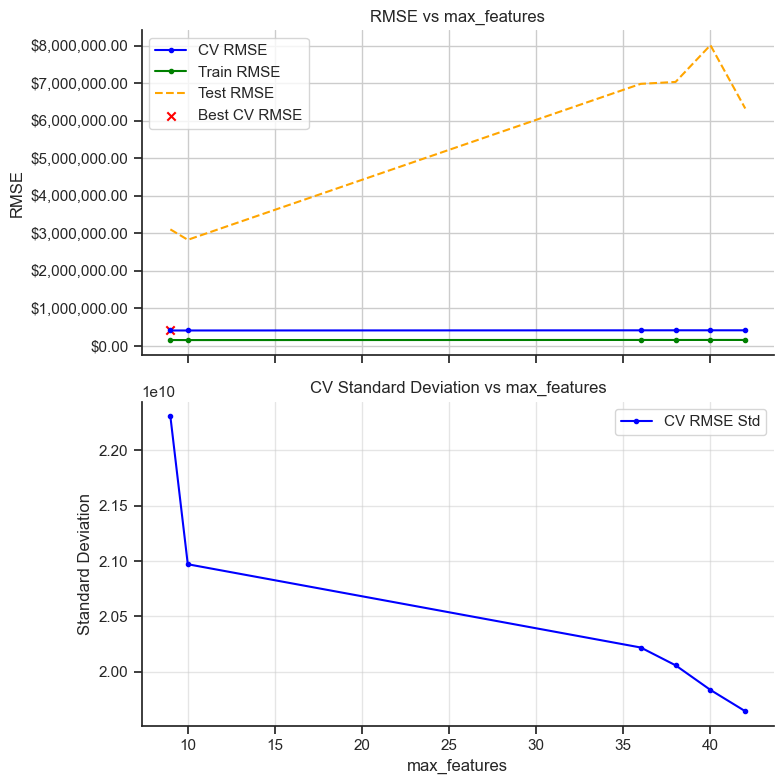

Execution Time: 00:02:38

 Refined Parameter max_features = 9    RMSE = $406,216.75

{'n_estimators': 95, 'max_features': 9, 'max_depth': None, 'bootstrap': True, 'min_samples_split': 2, 'min_samples_leaf': 1, 'oob_score': False, 'criterion': 'squared_error', 'random_state': 42, 'MSE_found': np.float64(165012050697.65002)}



Sweeping max_depth: 100%|██████████| 5/5 [00:47<00:00,  9.49s/it]


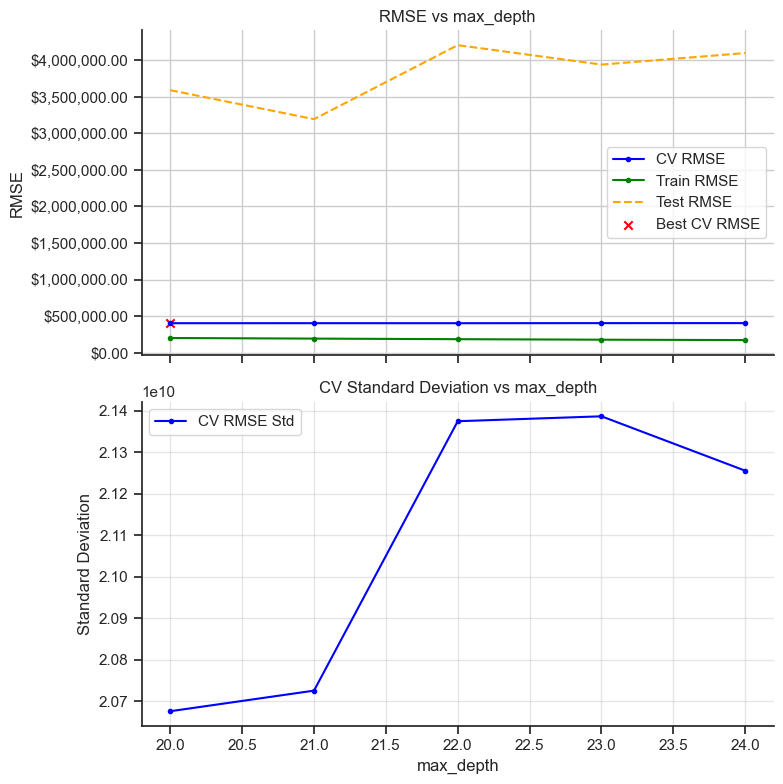

Execution Time: 00:00:47

 Refined Parameter max_depth = 20    RMSE = $403,375.04

{'n_estimators': 95, 'max_features': 9, 'max_depth': 20, 'bootstrap': True, 'min_samples_split': 2, 'min_samples_leaf': 1, 'oob_score': False, 'criterion': 'squared_error', 'random_state': 42, 'MSE_found': np.float64(162711423526.2121)}



n_estimators  max_features  max_depth  bootstrap  min_samples_split  \
0           125             1         21       True                  2   
1            95             9         20       True                  2   

   min_samples_leaf  oob_score      criterion  random_state     MSE_found  
0                 1      False  squared_error            42  1.606244e+11  
1                 1      False  squared_error            42  1.627114e+11

In [ ]:
# Your code here -- Add as many code cells as necessary
# rf_model = RandomForestRegressor()
start = time.time()


parameters_and_ranges_refined = [
    ('n_estimators',  range(70, 100, 5)),                         
    ('max_features',  list(chain(range(9, 11, 1), range(36, 44, 2)))),                      
    ('max_depth',     range(20, 25, 1)),                 
]

Parameters_Refined = Parameters_RF.copy()

for param, parameter_list in parameters_and_ranges_refined:
    Parameters_Refined = sweep_parameter(
        RandomForestRegressor,
        Parameters_Refined,
        param,
        parameter_list,
        X_train=fine_tuning_X_standardized,
        y_train=RF_y_train,
        X_test=RF_X_test,
        y_test=RF_y_test,
        n_jobs=-1,
        n_repeats=2
    )

    RMSE_dollars = Parameters_Refined['MSE_found']**0.5

    print(f"\n Refined Parameter {param} = {Parameters_Refined[param]}    RMSE = ${RMSE_dollars:,.2f}\n")
    print(Parameters_Refined)
    print()

Parameters_RF_List.append(Parameters_Refined)
RF_sweep_params_refined = pd.DataFrame(Parameters_RF_List)
RF_sweep_params_refined




#### **Grid Search CV -- Random Forest**

In [ ]:
# Filenames for cached outputs
result_csv = "data_cache/RF_gridsearch_results.csv"
summary_csv = "data_cache/RF_summary.csv"

# Check if the results already exist
if os.path.exists(result_csv) and os.path.exists(summary_csv):
    print("Loading cached GridSearchCV results...")

    renamed_results = pd.read_csv(result_csv)
    RF_summary_df = pd.read_csv(summary_csv)

    best_cv_rmse = RF_summary_df["Best CV RMSE"].values[0]
    best_params = eval(RF_summary_df["Best Parameters"].values[0])  # Convert string back to dict if needed

else:
    print("Running GridSearchCV...")

    start = time.time()

    RandForest = RandomForestRegressor(random_state=42)

    param_dist = {
        'n_estimators': range(90, 100, 2),          
        'max_features': range(8, 11, 1),          
        'max_depth': range(20, 25, 1),              
    }

    rcv = RepeatedKFold(n_repeats=1, random_state=42)

    search = GridSearchCV(
        estimator=RandForest,
        param_grid=param_dist,
        scoring='neg_mean_squared_error',
        cv=rcv,
        n_jobs=-1,
        return_train_score=True
    )

    search.fit(RF_X_train, RF_y_train)  

    results = pd.DataFrame(search.cv_results_)

    results = results[[
        'param_n_estimators', 'param_max_features', 'param_max_depth',
        'mean_test_score', 'std_test_score', 'mean_train_score', 'std_train_score', 'rank_test_score'
    ]]

    results['mean_test_score'] = -results['mean_test_score']
    results['mean_train_score'] = -results['mean_train_score']
    results = results.sort_values(by='rank_test_score')

    renamed_results = results.rename(columns={
        'param_n_estimators': 'n_estimators',
        'param_max_features': 'max_features',
        'param_max_depth': 'max_depth',
        'mean_test_score': 'mean_cv_score',
        'std_test_score': 'std_cv_score',
        'mean_train_score': 'mean_train_score',
        'std_train_score': 'std_train_score'
    }).drop(columns=['rank_test_score'])

    best_params = search.best_params_
    best_cv_mse = -search.best_score_
    best_cv_rmse = np.sqrt(best_cv_mse)
    best_cv_std = renamed_results.loc[renamed_results['mean_cv_score'] == best_cv_mse, 'std_cv_score'].values[0]

    RF_summary_df = pd.DataFrame({
        "Best Parameters": [str(best_params)],
        "Best CV RMSE": [best_cv_rmse],
        "Std Dev of Best CV MSE": [best_cv_std]
    })

    end = time.time()
    execution_time = time.strftime('%H:%M:%S', time.gmtime(end - start))
    print(f"Execution Time: {execution_time}")

    # Save to CSV
    renamed_results.to_csv(result_csv, index=False)
    RF_summary_df.to_csv(summary_csv, index=False)

# Print summary
print("\nSearch Results (Top 5) (Scaled & Standardized):\n")
print(renamed_results.head(5).to_string(index=False))
print(f"\nBest Parameters: {best_params}")
print(f"Best (Scaled & Standardized) CV RMSE: {best_cv_rmse:,.2f}")

Loading cached GridSearchCV results...

Search Results (Top 5) (Scaled & Standardized):

 n_estimators  max_features  max_depth  standardized_mean_cv_score  standardized_std_cv_score  standardized_mean_train_score  standardized_std_train_score
           97             8         21                    0.594542                   0.116573                       0.136843                      0.005189
           98             8         21                    0.594599                   0.116700                       0.136782                      0.005152
           99             8         21                    0.594600                   0.116812                       0.136775                      0.005172
           96             8         21                    0.594613                   0.116546                       0.136884                      0.005212
           95             8         21                    0.594666                   0.116583                       0.136931            

### **Random Forest Model Run Tests with Best Parameters**

#### **Prelude -- Prepare Features and Parameters for Modeling**

In [ ]:
final_results[final_results['model'].str.contains("RandomForest")]

model  \
5  RandomForestRegressor   

                                                                                                                                                                                                                                                                                                                                                                                                     model_params  \
5  {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}   

    mean_CV_RMSE   std_CV_RMSE  training_RMSE test_RMSE  \
5  414800.633345  34704.898763  155298.301425      None   

                       run_comment  Selected_Feature_Count  \
5  Final CV with selected features                      23   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                Selected_Features  
5  ['calculatedfinishedsquarefeet', 'calculatedfinishedsquarefeet_squared', 'calculatedfinishedsquarefeet_log', 'lotsizesquarefeet', 'propertyage_by_calculatedfinishedsquarefeet', 'propertyage_log', 'propertyage', 'bedroomcnt_by_bathroomcnt', 'bedroomcnt', 'bathroomcnt', 'unitcnt', 'building_label_building_quality_type_id_9', 'fullbathcnt', 'yearbuilt_decade_log', 'roomcnt', 'yearbuilt_decade', 'hasairconditioning_flag', 'building_label_building_quality_type_id_6', 'building_label_building_quality_type_id_10', 'building_label_building_quality_type_id_7', 'building_label_building_quality_type_id_11', 'landuse_Single_Family_Residential', 'heating_label_heating_or_system_type_solar']

In [ ]:
RF_summary_df['Best Parameters']

0    {'max_depth': 21, 'max_features': 8, 'n_estimators': 97}
Name: Best Parameters, dtype: object

**Best Random Forest Parameters**

In [ ]:
RF_Best_Params = {
 'max_depth': 21, 
 'max_features': 9, 
 'n_estimators': 98,
 'bootstrap' : True
 }

In [ ]:
# Best Feature Set Gradient Boosted Trees - (From Unlogged Version)
RF_Best_Features = feature_engineering_df_no_log[['calculatedfinishedsquarefeet', 'calculatedfinishedsquarefeet_squared', 'lotsizesquarefeet', 'propertyage_by_calculatedfinishedsquarefeet', 'propertyage_log', 'propertyage', 'bedroomcnt_by_bathroomcnt', 'bedroomcnt', 'bathroomcnt', 'unitcnt', 'building_label_building_quality_type_id_9', 'fullbathcnt', 'roomcnt', 'yearbuilt_decade', 'hasairconditioning_flag', 'yearbuilt_decade_log', 'building_label_building_quality_type_id_6', 'building_label_building_quality_type_id_10', 'building_label_building_quality_type_id_7', 'building_label_building_quality_type_id_11', 'landuse_Single_Family_Residential', 'heating_label_heating_or_system_type_solar', 'building_label_building_quality_type_id_8', 'taxvaluedollarcnt']]
RF_Best_Features_X_train, RF_Best_Features_X_test, RF_Best_Features_y_train, RF_Best_Features_y_test = train_test_split_data(RF_Best_Features, 'taxvaluedollarcnt')
scaled_RF_Best_Features_X_train = standardize_features(RF_Best_Features_X_train)

#### **Base Feature Engineering (No Log)**

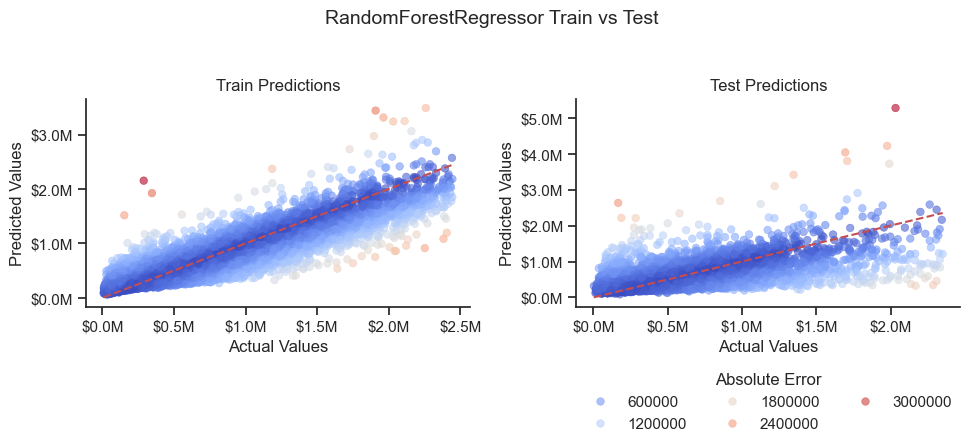

model  \
0  RandomForestRegressor   

                                                                                                                                                                                                                                                                                                                                                                                                 model_params  \
0  {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 21, 'max_features': 9, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 98, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}   

    mean_CV_RMSE   std_CV_RMSE  training_RMSE      test_RMSE  \
0  401830.304377  37084.889132    196138.2785  352056.944567   

                        run_comment  
0  Random Forest Fine-Tuning No Log

In [ ]:
run_model(
          model=RandomForestRegressor,
          X_train=feature_engineering_X_train_no_log,
          y_train=feature_engineering_y_train_no_log,
          X_test=feature_engineering_X_test_no_log,
          y_test= feature_engineering_y_test_no_log,
          n_repeats=5,
          n_jobs=-1, 
          concat_results=False,
          run_comment="Random Forest Fine-Tuning No Log", 
          target_is_logged=False,
          plot_pred=True, 
          **RF_Best_Params
          )

#### **Base Feature Engineering (Log)**

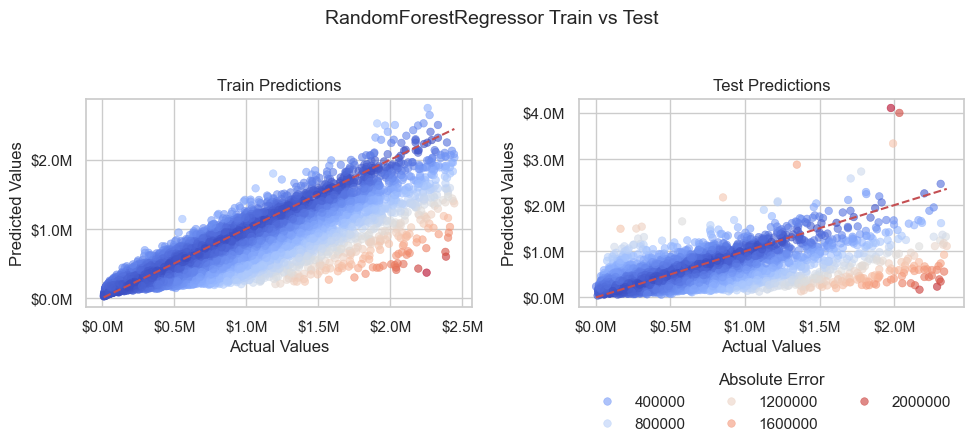

model  \
0  RandomForestRegressor   

                                                                                                                                                                                                                                                                                                                                                                                                 model_params  \
0  {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 21, 'max_features': 9, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 98, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}   

    mean_CV_RMSE   std_CV_RMSE  training_RMSE      test_RMSE  \
0  420226.345156  30307.374971  255708.464262  368978.689257   

                     run_comment  
0  Random Forest Fine-Tuning Log

In [ ]:
run_model(
    model=RandomForestRegressor,
    X_train=feature_engineering_X_train_log,
    y_train=feature_engineering_y_train_log, 
    X_test=feature_engineering_X_test_log,   # added
    y_test=feature_engineering_y_test_log,   # added
    n_repeats=5,
    n_jobs=-1, 
    concat_results=True,
    run_comment="Random Forest Fine-Tuning Log", 
    target_is_logged=True,
    plot_pred=True, 
    **RF_Best_Params
)

#### **With Feature Selection on No Log Dataset**

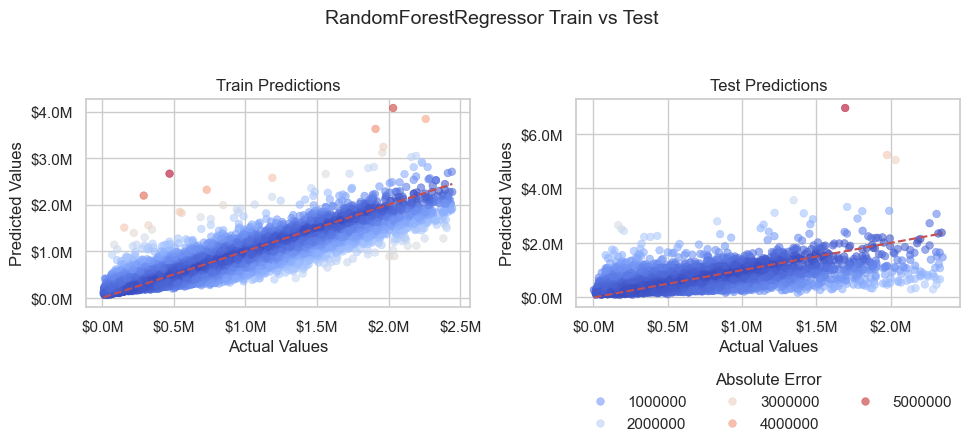

model  \
0  RandomForestRegressor   

                                                                                                                                                                                                                                                                                                                                                                                                 model_params  \
0  {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 21, 'max_features': 9, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 98, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}   

    mean_CV_RMSE   std_CV_RMSE  training_RMSE      test_RMSE  \
0  407516.553494  36443.512351  190914.463205  363867.771466   

                               run_comment  
0  Random Forest Fine-Tuning Best Features

In [ ]:
run_model(
          model=RandomForestRegressor,
          X_train=RF_Best_Features_X_train,
          y_train=RF_Best_Features_y_train,
          X_test=RF_Best_Features_X_test,
          y_test=RF_Best_Features_y_test, 
          n_repeats=5,
          n_jobs=-1, 
          concat_results=True,
          run_comment="Random Forest Fine-Tuning Best Features", 
          target_is_logged=False,
          plot_pred=True, 
          **RF_Best_Params
          )

____

### **3rd Place Model Parameter Sweep / GridSearch CV: Linear Regression**

#### **Top Parameter Selection and Feature Standardization**

In [ ]:
Parameters_LG = Default_Parameters_LinearRegression.copy()
Parameters_LG_List = []

fine_tuning_df_standardized = standardize_features(fine_tuning_df)
LG4_X_train, LG4_X_test, LG4_y_train, LG4_y_test = train_test_split_data(fine_tuning_df_standardized, 'taxvaluedollarcnt')

In [ ]:
Parameters_LG = Default_Parameters_LinearRegression.copy()
Parameters_LG_List = []

# fine_tuning_df_standardized = standardize_features(fine_tuning_df)
LG4_X_train, LG4_X_test, LG4_y_train, LG4_y_test = train_test_split_data(fine_tuning_df, 'taxvaluedollarcnt')
fine_tuning_X_standardized = standardize_features(LG4_X_train)


#### **Linear Regression Parameter Sweep**

Sweeping fit_intercept: 100%|██████████| 2/2 [00:01<00:00,  1.91it/s]


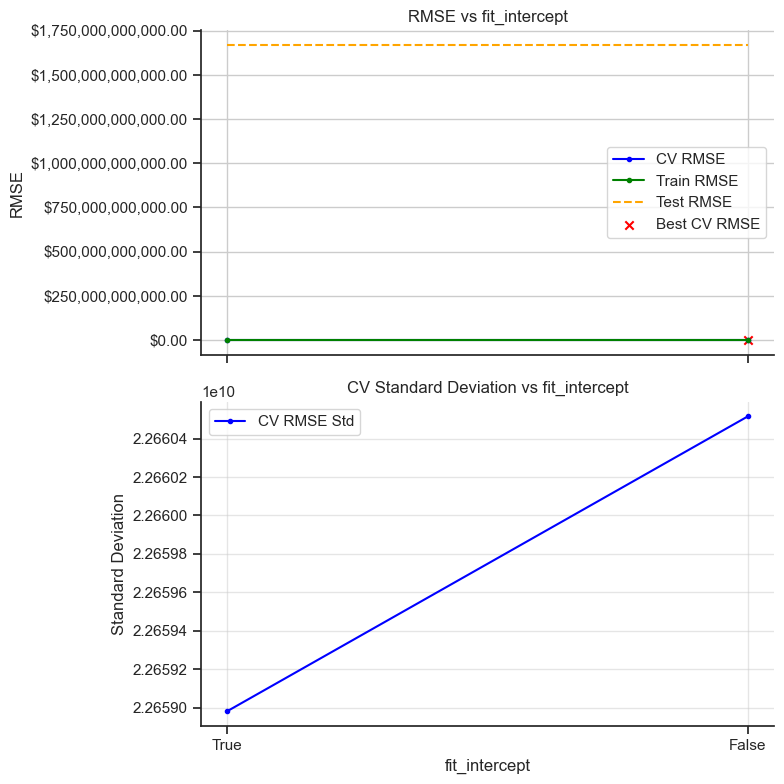

Execution Time: 00:00:01

 Parameter fit_intercept = False    RMSE = $413,959.84

{'fit_intercept': False, 'positive': False, 'MSE_found': np.float64(171362750389.25278)}



Sweeping positive: 100%|██████████| 2/2 [00:00<00:00,  3.29it/s]


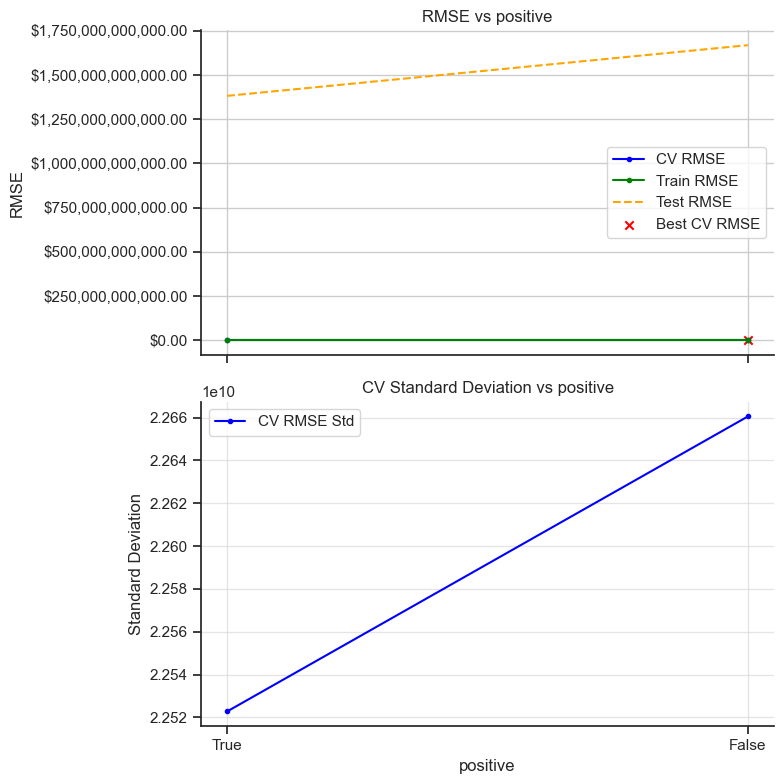

Execution Time: 00:00:00

 Parameter positive = False    RMSE = $413,959.84

{'fit_intercept': False, 'positive': False, 'MSE_found': np.float64(171362750389.25278)}



fit_intercept  positive     MSE_found
0          False     False  1.713628e+11
1          False     False  1.713628e+11

In [ ]:
# Your code here -- Add as many code cells as necessary

start = time.time()

parameters_and_ranges = [
    ('fit_intercept', [True, False]),
    ('positive', [True, False])
]

for param, parameter_list in parameters_and_ranges:
    Parameters_LG = sweep_parameter(
        LinearRegression,
        Parameters_LG,
        param,
        parameter_list,
        X_train=fine_tuning_X_standardized,
        y_train=LG4_y_train,
        X_test=LG4_X_test,
        y_test=LG4_y_test,
        n_jobs=-1,
        n_repeats=2
    )

    print(f"\n Parameter {param} = {Parameters_LG[param]}    RMSE = ${Parameters_LG['RMSE_found']**0.5:,.2f}\n")
    print(Parameters_LG)
    print()

Parameters_LG_List.append(Parameters_LG)
LG4_Results = pd.DataFrame(Parameters_LG_List)
LG4_Results


In this case, we chose fit_intercept = True. First, the increase in standard deviation when using fit_intercept = False is concerning, and the relative performance gains are negligible. To minimize variability and maintain interpretability—especially in the context of housing data—fit_intercept = True makes the most sense.


#### **GridSearchCV, LinearRegression**

In [ ]:
# Filenames for cached outputs
result_csv = "data_cache/LG_gridsearch_results.csv"
summary_csv = "data_cache/LG_summary.csv"

# Check if the results already exist
if os.path.exists(result_csv) and os.path.exists(summary_csv):
    print("Loading cached GridSearchCV results...")

    renamed_results = pd.read_csv(result_csv)
    LG_summary_df = pd.read_csv(summary_csv)

    best_cv_rmse = LG_summary_df["Best CV RMSE"].values[0]
    best_params = eval(LG_summary_df["Best Parameters"].values[0])  # Convert string back to dict if needed

else:
    print("Running GridSearchCV...")

    start = time.time()

    LinearReg = LinearRegression()

    param_dist = {
        'fit_intercept': [True, False],
        'positive': [False]
    }

    rcv = RepeatedKFold(n_repeats=5, random_state=42)

    search = GridSearchCV(
        estimator=LinearReg,
        param_grid=param_dist,
        scoring='neg_mean_squared_error',
        cv=rcv,
        n_jobs=-1,
        return_train_score=True
    )

    search.fit(LG4_X_train, LG4_y_train)  

    results = pd.DataFrame(search.cv_results_)

    results = results[[
        'param_fit_intercept', 'param_positive', 
        'mean_test_score', 'std_test_score', 'mean_train_score', 'std_train_score', 'rank_test_score'
    ]]

    results['mean_test_score'] = -results['mean_test_score']
    results['mean_train_score'] = -results['mean_train_score']
    results = results.sort_values(by='rank_test_score')

    renamed_results = results.rename(columns={
        'param_fit_intercept': 'fit_intercept',
        'param_positive': 'positive',
        'mean_test_score': 'mean_cv_score',
        'std_test_score': 'std_cv_score',
        'mean_train_score': 'mean_train_score',
        'std_train_score': 'std_train_score'
    }).drop(columns=['rank_test_score'])

    best_params = search.best_params_
    best_cv_mse = -search.best_score_
    best_cv_rmse = np.sqrt(best_cv_mse)
    best_cv_std = renamed_results.loc[renamed_results['mean_cv_score'] == best_cv_mse, 'std_cv_score'].values[0]

    LG_summary_df = pd.DataFrame({
        "Best Parameters": [str(best_params)],
        "Best CV RMSE": [best_cv_rmse],
        "Std Dev of Best CV MSE": [best_cv_std]
    })

    end = time.time()
    execution_time = time.strftime('%H:%M:%S', time.gmtime(end - start))
    print(f"Execution Time: {execution_time}")

    # Save to CSV
    renamed_results.to_csv(result_csv, index=False)
    LG_summary_df.to_csv(summary_csv, index=False)

# Print summary
print("\nSearch Results (Top 5) (Scaled & Standardized Scores):\n")
print(renamed_results.head(5).to_string(index=False))
print(f"\nBest Parameters: {best_params}")
print(f"Best CV (Scaled) RMSE: {best_cv_rmse:,.2f}")

Loading cached GridSearchCV results...

Search Results (Top 5) (Scaled & Standardized Scores):

 fit_intercept  positive  standardized_mean_cv_score  standardized_std_cv_score  standardized_mean_train_score  standardied_std_train_score
         False     False                    0.633118                   0.118474                       0.627021                     0.029456
          True     False                    0.633125                   0.118468                       0.627021                     0.029456

Best Parameters: {'fit_intercept': False, 'positive': False}
Best CV (Scaled) RMSE: 0.80


#### **Linear Regression Model Run Tests with Best Parameters**

In [ ]:
final_results[final_results['model'].str.contains("LinearRegression")]

model  \
0  LinearRegression   

                                                                 model_params  \
0  {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}   

    mean_CV_RMSE  std_CV_RMSE  training_RMSE test_RMSE  \
0  411237.680017  37334.26056  411888.104579      None   

                       run_comment  Selected_Feature_Count  \
0  Final CV with selected features                      32   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      Selected_Features  
0  ['bathroomcnt', 'bedroomcnt', 'fullbathcnt', 'lotsizesquarefeet', 'roomcnt', 'unitcnt', 'propertyage', 'yearbuilt_decade', 'fireplaceflag_new', 'storageshed_flag', 'hashottuborspa_flag', 'hasairconditioning_flag', 'hasgarage_flag', 'county_name_Orange County', 'county_name_Ventura County', 'landuse_Planned_Unit_Development', 'landuse_Quadruplex', 'heating_label_heating_or_system_type_unknown', 'building_label_building_quality_type_id_10', 'building_label_building_quality_type_id_11', 'building_label_building_quality_type_id_12', 'building_label_building_quality_type_id_3', 'building_label_building_quality_type_id_4', 'building_label_building_quality_type_id_5', 'building_label_building_quality_type_id_7', 'building_label_building_quality_type_id_8', 'building_label_building_quality_type_id_9', 'calculatedfinishedsquarefeet_squared', 'bedroomcnt_by_bathroomcnt', 'hasgarage_flag_by_bedroomcnt', 'propertyage_log', 'yearbuilt_decade_log']

**Linear Regression Best Params**

In [ ]:
LG_Best_Params = {
    'fit_intercept': True, 
    'positive': False
}

**Scaled Version of 'Best Features' Selection from Part 3**

In [ ]:
# Best Feature Set Gradient Boosted Trees - (From Unlogged Version)
LG_Best_Features = feature_engineering_df_no_log[['calculatedfinishedsquarefeet', 'calculatedfinishedsquarefeet_squared', 'lotsizesquarefeet', 'propertyage_by_calculatedfinishedsquarefeet', 'propertyage_log', 'propertyage', 'bedroomcnt_by_bathroomcnt', 'bedroomcnt', 'bathroomcnt', 'unitcnt', 'building_label_building_quality_type_id_9', 'fullbathcnt', 'roomcnt', 'yearbuilt_decade', 'hasairconditioning_flag', 'yearbuilt_decade_log', 'building_label_building_quality_type_id_6', 'building_label_building_quality_type_id_10', 'building_label_building_quality_type_id_7', 'building_label_building_quality_type_id_11', 'landuse_Single_Family_Residential', 'heating_label_heating_or_system_type_solar', 'building_label_building_quality_type_id_8', 'taxvaluedollarcnt']]
LG_Best_Features_X_train, LG_Best_Features_X_test, LG_Best_Features_y_train, LG_Best_Features_y_test = train_test_split_data(LG_Best_Features, 'taxvaluedollarcnt')
scaled_LG_Best_Features_X_train = standardize_features(LG_Best_Features_X_train)

**Base Feature Engineering (No Log)**

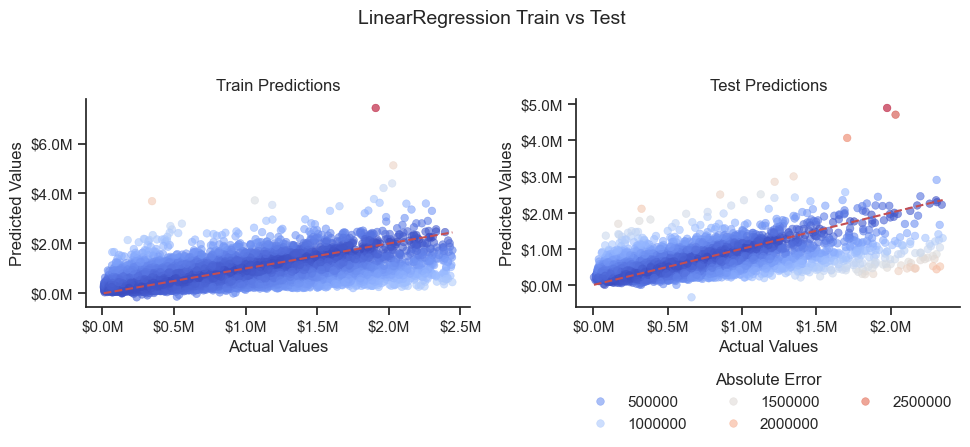

model  \
0  LinearRegression   

                                                                 model_params  \
0  {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}   

    mean_CV_RMSE   std_CV_RMSE  training_RMSE      test_RMSE  \
0  412042.722972  37003.955595  411627.283509  359917.496644   

                            run_comment  
0  Linear Regression Fine-Tuning No Log

In [ ]:
run_model(
          model=LinearRegression,
          X_train=feature_engineering_X_train_no_log,
          y_train=feature_engineering_y_train_no_log,
          X_test=feature_engineering_X_test_no_log,
          y_test=feature_engineering_y_test_no_log,            
          n_repeats=5,
          n_jobs=1, 
          concat_results=True,
          run_comment="Linear Regression Fine-Tuning No Log", 
          target_is_logged=False,
          plot_pred=True, 
          **LG_Best_Params
          )

**Base Feature Engineering (Log)**

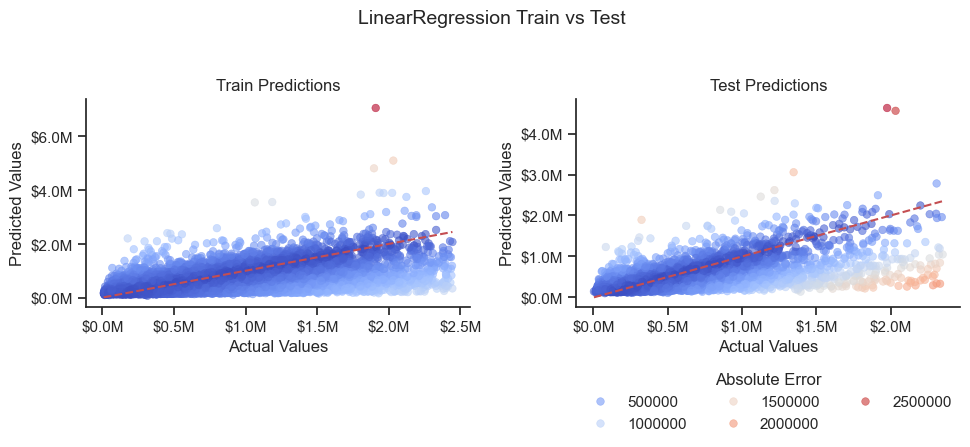

model  \
0  LinearRegression   

                                                                 model_params  \
0  {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}   

    mean_CV_RMSE   std_CV_RMSE  training_RMSE      test_RMSE  \
0  431333.985681  32938.515204  430509.499793  376636.324272   

                         run_comment  
0  Linear Regression Fine-Tuning Log

In [ ]:
run_model(
          model=LinearRegression,
          X_train=feature_engineering_X_train_log,
          y_train=feature_engineering_y_train_log,
          X_test=feature_engineering_X_test_log,
          y_test=feature_engineering_y_test_log,           
          n_repeats=5,
          n_jobs=-1, 
          concat_results=True,
          run_comment="Linear Regression Fine-Tuning Log", 
          target_is_logged=True,
          plot_pred=True, 
          **LG_Best_Params
          )

**With Feature Selection on No Log Dataset**

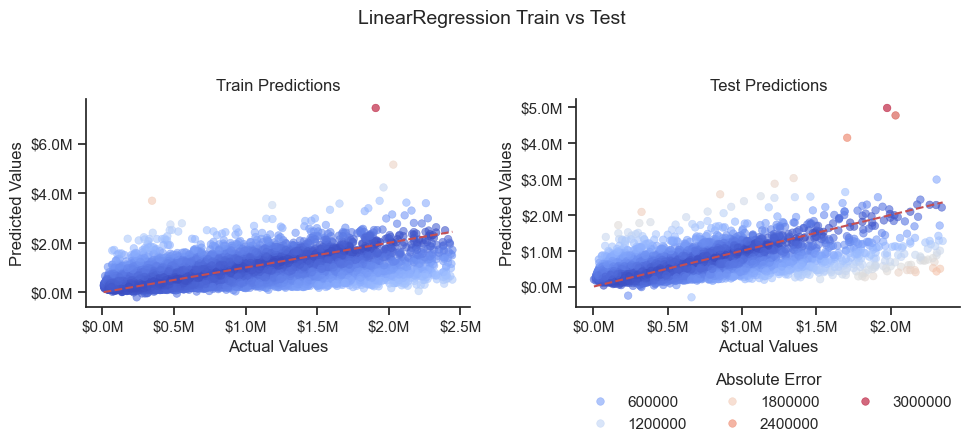

model  \
0  LinearRegression   

                                                                 model_params  \
0  {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}   

    mean_CV_RMSE   std_CV_RMSE  training_RMSE      test_RMSE  \
0  415746.403153  37071.212079  415922.421098  364124.997883   

                                   run_comment  
0  Linear Regression Fine-Tuning Best Features

In [ ]:
run_model(
          model=LinearRegression,
          X_train=LG_Best_Features_X_train,
          y_train=LG_Best_Features_y_train,
          X_test=LG_Best_Features_X_test,
          y_test=LG_Best_Features_y_test,            
          n_repeats=5,
          n_jobs=-1, 
          concat_results=True,
          run_comment="Linear Regression Fine-Tuning Best Features", 
          target_is_logged=False,
          plot_pred=True, 
          **LG_Best_Params
          )

____

#### **Part 4 Discussion Prelude**

In [ ]:
combined_results[combined_results['run_comment'].str.contains("Fine-")]

model  \
21  GradientBoostingRegressor   
22           LinearRegression   
23           LinearRegression   
24           LinearRegression   
25  GradientBoostingRegressor   
27  GradientBoostingRegressor   
28      RandomForestRegressor   
29      RandomForestRegressor   
30      RandomForestRegressor   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                  model_params  \
21  {'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.09, 'loss': 'squared_error', 'max_depth': 5, 'max_features': 12, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 194, 'n_iter_no_change': None, 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}   
22                                                                                                                                                                                                                                                                                                                                                                                                  {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}   
23                                                                                                                                                                                                                                                                                                                                                                                                  {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}   
24                                                                                                                                                                                                                                                                                                                                                                                                  {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}   
25  {'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.09, 'loss': 'squared_error', 'max_depth': 5, 'max_features': 12, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 194, 'n_iter_no_change': None, 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}   
27  {'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.09, 'loss': 'squared_error', 'max_depth': 5, 'max_features': 12, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 194, 'n_iter_no_change': None, 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}   
28                                                                  {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 21, 'max_features': 9, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 98, 'n_jobs': None, 'oob_score': False, 'random_state': None, 've

In [ ]:
part4results = combined_results
# part4results = pd.read_csv("data_cache/part4results.csv")
part4results.sort_values(by='mean_CV_RMSE')
part4_plot_ = part4results[['run_comment', 'mean_CV_RMSE', 'training_RMSE', 'test_RMSE']]
part4_plot2 = part4_plot_[part4_plot_['run_comment'].str.contains('Fine-Tuning')]
part4_plot2


run_comment   mean_CV_RMSE  training_RMSE  \
21                          GBT Fine-Tuning Log  414607.576164  381203.856277   
22         Linear Regression Fine-Tuning No Log  412042.722972  411627.283509   
23            Linear Regression Fine-Tuning Log  431333.985681  430509.499793   
24  Linear Regression Fine-Tuning Best Features  415746.403153  415922.421098   
25            GBT Fine-Tuning Selected Features  417900.849328  315943.449395   
27                 GBT Fine-Tuning No Log Final  402019.306084  322254.617799   
28             Random Forest Fine-Tuning No Log  401694.552878  194320.028584   
29      Random Forest Fine-Tuning Best Features  407516.553494  190914.463205   
30                Random Forest Fine-Tuning Log  420226.345156  255708.464262   

        test_RMSE  
21  364241.739254  
22  359917.496644  
23  376636.324272  
24  364124.997883  
25  374296.476511  
27  372784.243634  
28  353826.045162  
29  363867.771466  
30  368978.689257

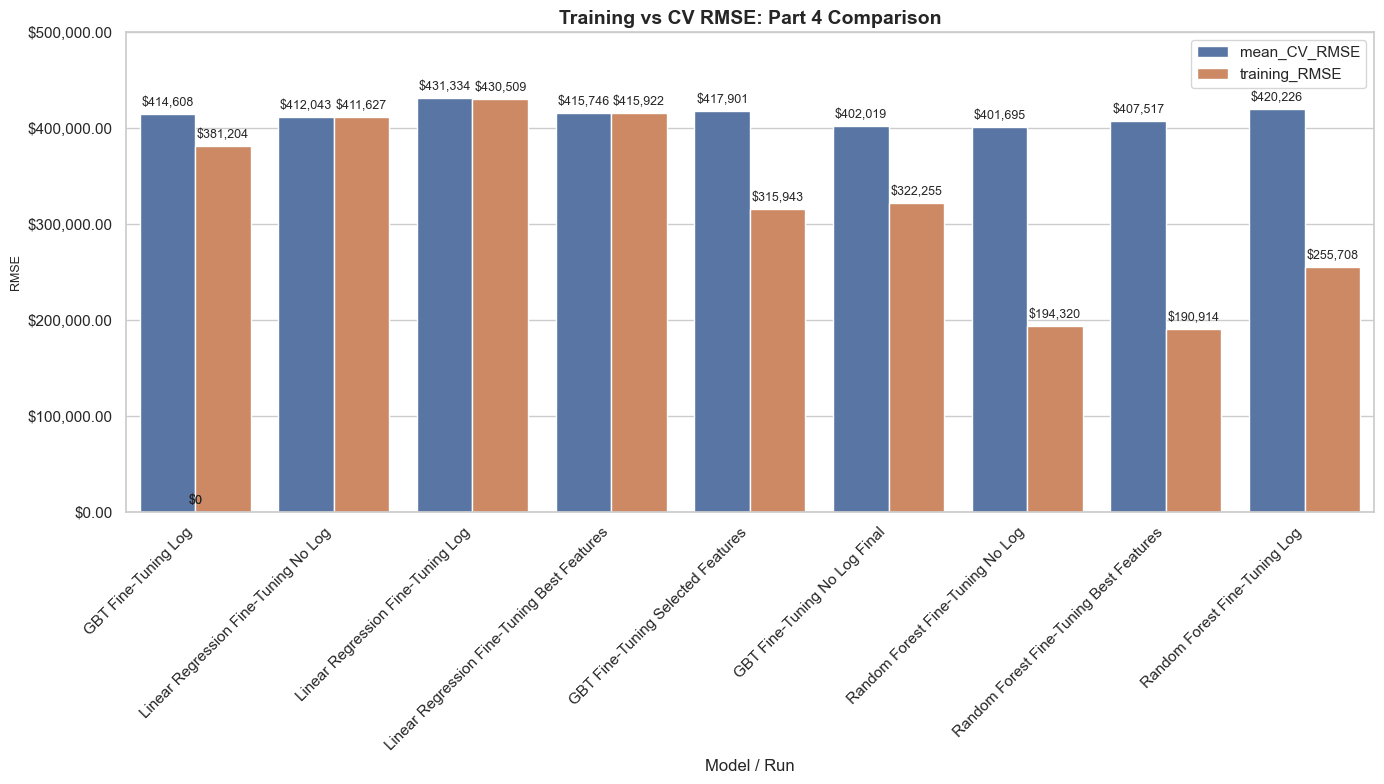

In [ ]:
part4_plot(part4_plot2, title="Training vs CV RMSE: Part 4 Comparison")

### Part 4: Discussion [4 pts]

Reflect on your tuning process and final results:

- What was your tuning strategy for each model? Why did you choose those hyperparameters?
- Did you find that certain types of preprocessing or feature engineering worked better with specific models?
- Provide a ranking of your three models and explain your reasoning — not just based on RMSE, but also interpretability, training time, or generalizability.
- Conclude by considering whether this workflow has produced the results you expected. Typically, you would repeat steps 2 - 4 and also reconsider the choices you made in Milestone 1 when cleaning the dataset, until reaching the point of diminishing returns; do you think that would that have helped here?

#### **Answer**

#### **1. Tuning Strategy**

We began by identifying the most influential hyperparameters for each model, referencing insights from both prior homeworks and AIML recommendations (see references). We also cross-validated these choices using ChatGPT to ensure alignment with current best practices.

After identifying the top three performing models from our initial cross-validation runs in Parts 1–3, we applied the following tuning strategy for each:

- Conducted a broad parameter sweep to identify promising hyperparameter ranges
- Executed a refined sweep over narrower ranges when needed
- Performed a final GridSearchCV using 5-fold cross-validation for fine-tuning

Once the optimal hyperparameters were selected, we evaluated each model using three different feature sets, running additional rounds of cross-validation:

- The full set of non-log-transformed features
- The full set of features with log transformations applied where appropriate
- The reduced ‘optimal’ feature set identified in Part 3, with no log transformation

We compiled the results into a unified dataframe that included CV RMSE, standard deviation, and training RMSE for all 9 cross-validation runs (3 models × 3 feature sets). These were then compared holistically to determine our final model rankings.



#### **2. We found some general trends in the data:**

In our analysis we found a few interesting things to note: 

**General Trends in the Data**

- Applying a logarithmic transformation to the target variable generally worsened performance across all models
- Feature engineering yielded the greatest performance gains overall. 
- Hyperparameter tuning led to modest gains in performance across the board. 

**Model Specific Findings**

- Ensemble models (such as Random Forests and Gradient Boosted Trees) performed best when trained on the full feature set.
- Linear regression models performed slightly better when trained on the reduced set of ‘selected features’.
- Linear Regression outperformed both Ridge and Lasso Regression.

Interestingly, Linear Regression’s superior performance over its regularized counterparts (Ridge and Lasso) highlights the strength of the manual feature engineering that was done. It suggests that the cleaned and engineered dataset already captured key patterns in the data, and the added regularization from the more complex regression methods may have hurt performance overall. 

#### **3. Model Ranking**

All models struggled to fully capture the variation in home values upper price ranges. This was evident in both the predicted vs. actual plots and residual error plots, which revealed that the models increasingly overshot as prices rose. 

Additionally, while the Random Forest achieved the lowest cross-validated RMSE, it also had the largest train-test gap, indicating potential overfitting. Gradient Boosted Trees demonstrated better generalization, despite slightly higher overall error and some overshooting (like all the models) on high-value homes.

Despite this, our final ranking was:

1.	Gradient Boosted Trees (trained on full dataset / no log)
2.	Random Forest (trained on full dataset / no log)
3.	Linear Regression (trained on ‘best features’ / not logged)

While Random Forest technically performed best overall, the narrow margin (~$5,000) combined with signs of overfitting made us cautious about its robustness. Gradient Boosted Trees offered a better balance of accuracy and generalizability.

Interesting to note, however, Linear Regression, though slightly behind in raw RMSE (by $10,000–$15,000), was by far the most interpretable. In scenarios where explainability is important (e.g., working with stakeholders), it could be the top choice, especially if further steps are taken to enhance the results overall. 


#### **4. Workflow Reflection**

Although this workflow produced better results than earlier iterations, we had hoped for stronger overall model performance. We believe there was still room for improvement by revisiting steps 2–4, particularly for the Gradient Boosted Trees model — (and possibly the Linear Regression model if maximum interpretability was a priority).

During our initial data exploration, we observed a high number of outliers at the upper end of the target variable (some nearing $50M, while most homes fell within the $0–1M range). While we removed the most extreme values, we may not have gone far enough as we had initially assumed that log-transforming the target would mitigate this skew. In practice, however, this did not improve performance as much as expected.

To address this, we may explore **segmented modeling**, training separate models for properties in different value ranges (e.g., <$1M, $1M–$5M, >$5M). This can reduce the impact of outliers by capturing the distinct patterns that drive value in each segment, potentially improving accuracy—especially in the higher price tiers where our current models tend to overpredict.

Upon further analysis, we suspect that revisiting our outlier handling -- especially in the $5 M+ range -- might yield greater improvements. Many of our models consistently overshot predictions above the $1M mark, suggesting these upper outliers were still exerting disproportionate influence on each of our models.

Additionally, in Part 1, we consolidated a large number of categorical variables into boolean flags. If further improvement were needed, we could revisit this feature engineering step to explore its impact on cross-validation results. However, it’s likely that by this point, we were approaching the point of diminishing returns in terms of model refinement.


______

#### **References**

1.Hyperparameter Tuning Guide.AIML.com. (2023, October 3). What are the key hyperparameters for a GBM model? https://aiml.com/what-are-the-key-hyper-parameters-for-a-gbm-model/


____

#### **Appendix:**

**LinearRegression**

1.	**fit_intercept** (default: **True**)
Determines whether the model should include an intercept term. This is essential if your data isn’t centered — turning it off can drastically affect model performance.
	
2.	**positive** (default: **False**)
If set to True, constrains the coefficients to be non-negative. This is a strong constraint and can drastically change the learned relationships, especially when domain knowledge suggests only positive effects.


**(Only 2 -- other parameters seem to be deprecated or just control memory usage)**

**Ridge**

**Most Important Parameters**

1.	**alpha** (default: **1.0**)
Controls the strength of L2 regularization. Higher values shrink the coefficients more, helping prevent overfitting. Tuning this is often essential to get the best performance.

2.	**fit_intercept** (default: **True**)
As with LinearRegression, this determines whether to include an intercept term. It’s critical for correctly modeling uncentered data.

3.	**solver** (default: **‘auto’**)
Chooses the algorithm used to optimize the model. While “auto” usually selects a good default, specific solvers like “saga” or “lsqr” can be more efficient or stable in certain settings, especially with large data.

**Less Important Parameters**

4.	**max_iter** (default: **1000**)
The maximum number of iterations for solvers that use iterative optimization. It only matters if the solver doesn’t converge — not a direct influence on model quality.

5.	**tol** (default: **0.001**)
Tolerance for stopping criteria in solvers. Lower values can lead to more precise but slower solutions.

**Lasso**

**Most Important Parameters**

1.	**alpha** (default: **1.0**)
Controls the strength of L1 regularization. A larger alpha forces more coefficients to exactly zero, encouraging sparsity. Crucial for feature selection and regularization.

2.	**fit_intercept** (default: **True**)
Same as in LinearRegression and Ridge — determines whether an intercept is included in the model.
	
3.	**positive** (default: **False**)
Forces all coefficients to be non-negative if set to True. When enabled, it introduces a hard constraint that can drastically alter the model’s coefficients and predictions.

**Less Important Parameters**

4.	**max_iter** (default: **1000**)
Sets the number of iterations for coordinate descent optimization. Only relevant if the solver doesn’t converge.

5.	**tol** (default: **0.0001**)
Tolerance for stopping the optimization algorithm. Smaller values can yield more precise results at the cost of speed.

6.	**warm_start** (default: **False**)
If True, reuse the solution of the previous call to fit as initialization. Useful when fitting multiple models iteratively (e.g., for cross-validation or alpha tuning).

**DecisionTreeRegressor**

**Most Important Parameters**

1. **max_depth** (default: **None**)  
   *Controls the maximum depth of the tree, which is crucial for managing overfitting and overall model complexity.*

2. **max_leaf_nodes** (default: **None**)  
   *An alternative to max_depth, this limits the number of leaf nodes and can be used to control tree size in a different way.*

3. **max_features** (default: **None**)  
   *Determines the maximum number of features considered when looking for the best split. Tuning this can affect the bias-variance trade-off.*

4. **min_samples_split** (default: **2**)  
   *Specifies the minimum number of samples required to split an internal node. It influences how “greedy” the tree is in creating splits.*

**Less Important Parameters**

5. **criterion** (default: **'squared_error'**)  
   *Chooses the function to measure the quality of a split (e.g., squared_error, absolute_error, etc.). Experimenting with this can reveal how different error metrics impact performance.*

6. **splitter** (default: **'best'**)  
   *Decides the strategy used to choose the split at each node (typically "best" or "random"). While its effect is subtler, exploring it can be educational.*

7. **min_samples_leaf** (default: **1**)  
   *Sets the minimum number of samples that must be present in a leaf. This parameter helps prevent creating leaves with very few samples, thus reducing overfitting.*

8. **ccp_alpha** (default: **0.0**)  
   *The complexity parameter for Minimal Cost-Complexity Pruning. It’s useful for understanding pruning techniques, though it’s a bit more advanced.*

9. **min_impurity_decrease** (default: **0.0**)  
   *A node will be split only if the split results in a decrease in impurity greater than or equal to this threshold. It provides another way to control overfitting.*

10. **min_weight_fraction_leaf** (default: **0.0**)  
    *Ensures that each leaf has a minimum weighted fraction of the total. It’s less commonly tuned but can be relevant when sample weights matter.*

11. **random_state** (default: **None**)  
    *Used only for reproducibility, traditionally as `random_state = 42`. It doesn’t affect the model’s learning, but ensures that results are consistent across runs. Set to `None` for more realistic random behavior typical for deployed systems. 

**BaggingRegressor // (HW7)**

**Most Important Parameters**

1. **n_estimators** (default: **10**)  
   *Determines the number of base estimators in the ensemble. Increasing this number can reduce variance and improve performance, though it comes with higher computational cost.*

2. **max_samples** (default: **1.0**)  
   *Specifies the number (or fraction) of samples to draw from the training set for each base estimator. This is crucial for controlling the diversity of the estimators and can directly affect bias and variance.*

3. **max_features** (default: **1.0**)  
   *Specifies the number (or fraction) of features to consider when training each base estimator. Adjusting this parameter can help manage overfitting by limiting the complexity of each individual estimator.*

4. **bootstrap** (default: **True**)  
   *Indicates whether samples are drawn with replacement. Bootstrap sampling introduces randomness into the training process, leading to more diverse estimators and often improved ensemble performance.*

**Less Important Parameters**

5. **base_estimator** (default: **None**)  // **Deprecated?**

   *Defines the underlying estimator to be used. If set to `None`, BaggingRegressor defaults to using a DecisionTreeRegressor. Experimenting with different base estimators can provide valuable insights into model performance.*

6. **oob_score** (default: **False**)  
   *If enabled, the model uses out-of-bag samples to estimate the generalization error, providing an internal validation metric without the need for a separate validation set.*

7. **bootstrap_features** (default: **False**)  
   *Specifies whether features are sampled with replacement. This additional layer of randomness can further increase estimator diversity, though its impact is typically less significant than sample bootstrapping.*


**RandomForestRegressor   // (HW7)**

**Most Important Parameters**

1. **n_estimators** (default: **100**)  
   *Determines the number of trees in the forest. Increasing this number generally improves performance and model stability, albeit with higher computational cost.*

2. **max_features** (default: **None**)  
   *Specifies the number of features to consider when looking for the best split. Adjusting this can help manage the bias-variance trade-off and affect the diversity among the trees.*

3. **max_depth** (default: **None**)  
   *Limits the depth of each tree. Restricting the maximum depth is an effective way to control overfitting and reduce the complexity of the model.*

4. **bootstrap** (default: **True**)  
   *Indicates whether bootstrap samples are used when building trees. Enabling bootstrap sampling introduces randomness into the training process, which can improve the generalization of the ensemble.*

**Less Important Parameters**

5. **min_samples_split** (default: **2**)  
   *Defines the minimum number of samples required to split an internal node. Tuning this parameter affects how the tree grows, influencing its granularity and robustness.*

6. **min_samples_leaf** (default: **1**)  
   *Specifies the minimum number of samples that must be present in a leaf node. This parameter ensures that leaves are not created with too few samples, which can help mitigate overfitting.*

7. **oob_score** (default: **False**)  
   *If enabled, uses out-of-bag samples to estimate the generalization error, providing an internal validation measure without the need for a separate validation set.*

8. **criterion** (default: **'squared_error'**)  
   *Determines the function used to measure the quality of a split. While its effect is typically subtle, experimenting with this parameter can reveal how different error metrics impact performance.*

**GradientBoostingRegressor // (HW7)**

**Most Important Parameters**

1. **learning_rate** (default: **0.1**)  
   *Controls the contribution of each individual tree. A lower learning rate generally requires more trees but can lead to improved generalization.*

2. **n_estimators** (default: **100**)  
   *Specifies the number of boosting stages (i.e., the number of trees in the ensemble). More estimators can improve performance but also increase the risk of overfitting if not tuned properly.*

3. **max_depth** (default: **3**)  
   *Limits the depth of the individual regression trees. Restricting the depth helps control overfitting and reduces the complexity of each base learner.*

4. **max_features** (default: **None**)  
   *Controls the number of features to consider when looking for the best split. Adjusting this can influence the bias-variance trade-off of the model.*

**Less Important Parameters**

5. **min_samples_split** (default: **2**)  
   *Defines the minimum number of samples required to split an internal node. This parameter controls the growth of each tree and can prevent overly specific splits.*

6. **min_samples_leaf** (default: **1**)  
   *Specifies the minimum number of samples that must be present in a leaf node. This helps in ensuring that trees do not become too tailored to the training data.*

7. **max_leaf_nodes** (default: **None**)  
    *An optional parameter that sets a maximum number of leaf nodes for each tree. This can provide an additional way to control the complexity of the model.*

8. **subsample** (default: **1.0**)  
   *Determines the fraction of samples used for fitting each individual tree. Values less than 1.0 introduce randomness into the boosting process, which can help reduce overfitting.*

9. **loss** (default: **'squared_error'**)  
   *Determines the loss function to be optimized during training. Different loss functions can be used depending on the specific characteristics of the regression problem.*